In [1]:
import os
from pathlib import Path
from typing import Optional, Tuple, Union, Callable, Literal
import math

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
import masknmf
from masknmf.compression.pmd_array import PMDArray
from masknmf import display
from masknmf.utils import torch_select_device
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set default device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

No windowing system present. Using surfaceless platform
No config found!
No config found!
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
✅,Quadro RTX 8000,DiscreteGPU,Vulkan,565.57.01
❌,Quadro RTX 8000/PCIe/SSE2,Unknown,OpenGL,3.3.0 NVIDIA 565.57.01


Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Using device: cuda


In [2]:
class MotionBinDataset:
    """Load a memmapped suite2p data.bin together with metadata (.npy/.zip)."""
    
    def __init__(self, data_path: str, metadata_path: str, dtype=np.int16):
        self.bin_path = Path(data_path)
        self.ops_path = Path(metadata_path)
        self._dtype = dtype
        self._shape = self._compute_shape()
        self.data = np.memmap(self.bin_path, mode='r', dtype=self._dtype, shape=self._shape)

    def _compute_shape(self) -> Tuple[int, int, int]:
        _, ext = os.path.splitext(self.ops_path)
        if ext == ".zip":
            ops = np.load(self.ops_path, allow_pickle=True)['ops'].item()
        elif ext == ".npy":
            ops = np.load(self.ops_path, allow_pickle=True).item()
        else:
            raise ValueError("Metadata file must be .zip or .npy")
        return int(ops['nframes']), int(ops['Ly']), int(ops['Lx'])

    @property
    def shape(self) -> Tuple[int, int, int]:
        return self._shape

    def __getitem__(self, item):
        return self.data[item].copy()

In [3]:
# ==============================================================================
# V REFINEMENT WITH EXPANDED BLOCK REGRESSION
# ==============================================================================
# This is the main new functionality: refining V by regressing on expanded U blocks

def regress_expanded_block_for_u(
        dataset: Union[np.ndarray, torch.Tensor],
        v: torch.tensor,
        start_h: int, end_h: int,
        start_w: int, end_w: int,
        dataset_mean: torch.tensor,
        dataset_noise_variance: torch.tensor,
        frame_batch_size: int,
        dtype: torch.dtype,
        device: str,
) -> torch.tensor:
    """
    Regress expanded block data onto V to get U.
    
    Computes: U = (Data - Mean) / Noise_var @ V^T / (V @ V^T)
    
    Args:
        dataset: Full dataset
        v: Current temporal components, shape (num_components, num_frames)
        start_h, end_h, start_w, end_w: Expanded block boundaries
        dataset_mean: Mean image
        dataset_noise_variance: Noise variance
        frame_batch_size: Batch size
        dtype: Data type
        device: Device
        
    Returns:
        u_block: Spatial components for expanded block, shape (height*width, num_components)
    """
    num_frames = dataset.shape[0]
    height = end_h - start_h
    width = end_w - start_w
    num_components = v.shape[0]
    
    # Extract block parameters
    mean_block = dataset_mean[start_h:end_h, start_w:end_w].reshape(-1, 1)
    noise_block = dataset_noise_variance[start_h:end_h, start_w:end_w].reshape(-1, 1)
    
    # Compute V @ V^T for normalization
    vtv = v @ v.T  # (num_components, num_components)
    vtv_inv = torch.linalg.pinv(vtv)  # Pseudo-inverse for stability
    
    # Accumulate U in batches
    u_accumulator = torch.zeros(height * width, num_components, device=device, dtype=dtype)
    
    num_iters = math.ceil(num_frames / frame_batch_size)
    
    for batch_idx in range(num_iters):
        start_frame = batch_idx * frame_batch_size
        end_frame = min(start_frame + frame_batch_size, num_frames)
        
        # Load data batch for this block
        data_batch = dataset[start_frame:end_frame, start_h:end_h, start_w:end_w]
        if isinstance(data_batch, torch.Tensor):
            data_batch = data_batch.to(device).to(dtype)
        else:
            data_batch = torch.from_numpy(data_batch).to(device).to(dtype)
        
        # Reshape: (batch_frames, height, width) -> (height*width, batch_frames)
        data_batch = data_batch.permute(1, 2, 0).reshape(height * width, -1)
        
        # Standardize
        data_batch = (data_batch - mean_block) / noise_block
        
        # Project onto V: (height*width, batch_frames) @ (batch_frames, num_components)
        v_batch = v[:, start_frame:end_frame].T  # (batch_frames, num_components)
        u_accumulator += data_batch @ v_batch
    
    # Normalize by V @ V^T
    u_block = u_accumulator @ vtv_inv
    
    return u_block


def regress_for_v_from_blocks(
        dataset: Union[np.ndarray, torch.Tensor],
        u_blocks: list,
        block_locations: list,
        dataset_mean: torch.tensor,
        dataset_noise_variance: torch.tensor,
        frame_batch_size: int,
        dtype: torch.dtype,
        device: str,
) -> torch.tensor:
    """
    Regress dataset onto U blocks to get updated V.
    
    For overlapping blocks, we average the contributions.
    
    Args:
        dataset: Full dataset
        u_blocks: List of U tensors, each shape (block_h, block_w, num_components)
        block_locations: List of (start_h, start_w, height, width) tuples
        dataset_mean: Mean image
        dataset_noise_variance: Noise variance
        frame_batch_size: Batch size
        dtype: Data type
        device: Device
        
    Returns:
        v: Updated temporal components, shape (num_components, num_frames)
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    
    # Determine total number of components
    num_components = u_blocks[0].shape[2]
    
    # Build weighted sparse U matrix
    cumulative_weights = torch.zeros(fov_dim1, fov_dim2, device=device, dtype=dtype)
    u_weighted_sum = torch.zeros(fov_dim1, fov_dim2, num_components, device=device, dtype=dtype)
    
    for u_block, (start_h, start_w, block_h, block_w) in zip(u_blocks, block_locations):
        u_block = u_block.to(device).to(dtype)
        end_h = start_h + block_h
        end_w = start_w + block_w
        
        # Simple averaging weight (could use distance-based weighting)
        weight = 1.0
        
        u_weighted_sum[start_h:end_h, start_w:end_w, :] += u_block * weight
        cumulative_weights[start_h:end_h, start_w:end_w] += weight
    
    # Normalize by cumulative weights
    u_weighted_sum = u_weighted_sum / cumulative_weights[:, :, None].clamp(min=1e-6)
    
    # Reshape for regression
    u_flat = u_weighted_sum.reshape(fov_dim1 * fov_dim2, num_components)
    mean_flat = dataset_mean.reshape(fov_dim1 * fov_dim2, 1)
    noise_flat = dataset_noise_variance.reshape(fov_dim1 * fov_dim2, 1)
    
    # Weight U by inverse noise variance
    u_weighted = u_flat / noise_flat
    
    # Precompute mean projection
    mean_projection = u_weighted.T @ mean_flat  # (num_components, 1)
    
    # Compute V in batches
    v_list = []
    num_iters = math.ceil(num_frames / frame_batch_size)
    
    for batch_idx in tqdm(range(num_iters), desc="Regressing V"):
        start_frame = batch_idx * frame_batch_size
        end_frame = min(start_frame + frame_batch_size, num_frames)
        
        # Load data batch
        data_batch = dataset[start_frame:end_frame]
        if isinstance(data_batch, torch.Tensor):
            data_batch = data_batch.to(device).to(dtype)
        else:
            data_batch = torch.from_numpy(data_batch).to(device).to(dtype)
        
        # Reshape: (batch_frames, fov_dim1, fov_dim2) -> (fov_dim1*fov_dim2, batch_frames)
        data_batch = data_batch.permute(1, 2, 0).reshape(fov_dim1 * fov_dim2, -1)
        
        # Project: U^T @ Data - U^T @ Mean
        v_batch = u_weighted.T @ data_batch - mean_projection
        
        v_list.append(v_batch)
    
    v = torch.cat(v_list, dim=1)
    
    return v


def refine_v_with_expanded_blocks(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        v_initial: torch.tensor,
        block_locations: list,  # List of (start_h, start_w, height, width) tuples
        expansion_factor: int,
        dataset_mean: torch.tensor,
        dataset_noise_variance: torch.tensor,
        spatial_denoiser: Optional[torch.nn.Module] = None,
        num_iterations: int = 3,
        frame_batch_size: int = 1000,
        dtype: torch.dtype = torch.float32,
        device: str = "cpu",
        visualize: bool = True,
        save_path: Optional[str] = None
) -> torch.tensor:
    """
    Refines temporal components V by iteratively:
    1. Regressing to get U on expanded blocks
    2. Denoising the expanded U images
    3. Truncating denoised U back to original blocks
    4. Regressing to update V
    
    Args:
        dataset: Input dataset with shape (num_frames, fov_dim1, fov_dim2)
        v_initial: Initial temporal components, shape (num_components, num_frames)
        block_locations: List of tuples (start_h, start_w, height, width) for each block
        expansion_factor: How many pixels to expand each block in all directions
        dataset_mean: Mean image, shape (fov_dim1, fov_dim2)
        dataset_noise_variance: Noise variance, shape (fov_dim1, fov_dim2)
        spatial_denoiser: Optional denoiser for U images
        num_iterations: Number of refinement iterations
        frame_batch_size: Batch size for loading frames
        dtype: Data type for computation
        device: Computing device
        visualize: Whether to generate visualizations
        save_path: Path to save visualizations (optional)
        
    Returns:
        v_refined: Refined temporal components, shape (num_components, num_frames)
    """
    print(f"\n{'#'*70}")
    print(f"# Starting V Refinement with Expanded Block Regression")
    print(f"{'#'*70}")
    print(f"Dataset shape: {dataset.shape}")
    print(f"Initial V shape: {v_initial.shape}")
    print(f"Number of blocks: {len(block_locations)}")
    print(f"Expansion factor: {expansion_factor}")
    print(f"Number of iterations: {num_iterations}")
    print(f"Device: {device}")
    print(f"Spatial denoiser: {'Yes' if spatial_denoiser is not None else 'No'}")
    print(f"{'#'*70}\n")
    
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    v_current = v_initial.clone().to(device).to(dtype)
    v_previous = None
    
    # Move constants to device
    dataset_mean = dataset_mean.to(device).to(dtype)
    dataset_noise_variance = dataset_noise_variance.to(device).to(dtype)
    
    if spatial_denoiser is not None:
        spatial_denoiser.to(device)
    
    for iteration in range(num_iterations):
        print(f"\n{'*'*70}")
        print(f"* ITERATION {iteration + 1}/{num_iterations}")
        print(f"{'*'*70}")
        
        # Step 1 & 2: Regress to get U on expanded blocks and denoise
        print(f"\nStep 1 & 2: Computing U on expanded blocks...")
        u_expanded_blocks = []
        expanded_block_info = []
        
        for block_idx, (start_h, start_w, block_h, block_w) in enumerate(tqdm(block_locations, desc="Processing blocks")):
            # Define expanded block boundaries
            exp_start_h = max(0, start_h - expansion_factor)
            exp_end_h = min(fov_dim1, start_h + block_h + expansion_factor)
            exp_start_w = max(0, start_w - expansion_factor)
            exp_end_w = min(fov_dim2, start_w + block_w + expansion_factor)
            
            exp_height = exp_end_h - exp_start_h
            exp_width = exp_end_w - exp_start_w
            
            print(f"  Block {block_idx}: Original ({block_h}x{block_w}) -> Expanded ({exp_height}x{exp_width})")
            
            # Store expanded block info
            expanded_block_info.append({
                'exp_start_h': exp_start_h,
                'exp_end_h': exp_end_h,
                'exp_start_w': exp_start_w,
                'exp_end_w': exp_end_w,
                'orig_start_h': start_h,
                'orig_end_h': start_h + block_h,
                'orig_start_w': start_w,
                'orig_end_w': start_w + block_w,
            })
            
            # Regress expanded block data onto current V to get U
            print(f"    Regressing for U...")
            u_expanded = regress_expanded_block_for_u(
                dataset,
                v_current,
                exp_start_h, exp_end_h,
                exp_start_w, exp_end_w,
                dataset_mean,
                dataset_noise_variance,
                frame_batch_size,
                dtype,
                device
            )
            print(f"    U shape: {u_expanded.shape}, mean: {u_expanded.mean().item():.4f}, std: {u_expanded.std().item():.4f}")
            
            # Denoise U if denoiser provided
            if spatial_denoiser is not None:
                print(f"    Denoising U...")
                u_before_denoise = u_expanded.clone()
                u_expanded = u_expanded.reshape(exp_height, exp_width, -1)
                u_expanded = spatial_denoiser(u_expanded)
                u_expanded = u_expanded.reshape(exp_height * exp_width, -1)
                denoise_change = torch.norm(u_expanded - u_before_denoise) / torch.norm(u_before_denoise)
                print(f"    Denoising relative change: {denoise_change.item():.6f}")
            
            u_expanded_blocks.append(u_expanded)
        
        # Step 3: Truncate denoised U back to original blocks
        print(f"\nStep 3: Truncating U back to original blocks...")
        u_truncated_blocks = []
        for block_idx, info in enumerate(expanded_block_info):
            u_exp = u_expanded_blocks[block_idx].reshape(
                info['exp_end_h'] - info['exp_start_h'],
                info['exp_end_w'] - info['exp_start_w'],
                -1
            )
            
            # Calculate relative positions
            rel_start_h = info['orig_start_h'] - info['exp_start_h']
            rel_end_h = rel_start_h + (info['orig_end_h'] - info['orig_start_h'])
            rel_start_w = info['orig_start_w'] - info['exp_start_w']
            rel_end_w = rel_start_w + (info['orig_end_w'] - info['orig_start_w'])
            
            # Truncate to original block
            u_truncated = u_exp[rel_start_h:rel_end_h, rel_start_w:rel_end_w, :]
            u_truncated_blocks.append(u_truncated)
            
            print(f"  Block {block_idx}: Truncated shape {u_truncated.shape}")
        
        # Step 4: Regress to update V using truncated U blocks
        print(f"\nStep 4: Regressing to update V...")
        v_current = regress_for_v_from_blocks(
            dataset,
            u_truncated_blocks,
            block_locations,
            dataset_mean,
            dataset_noise_variance,
            frame_batch_size,
            dtype,
            device
        )
        
        # Print statistics
        print_iteration_stats(
            iteration + 1,
            v_current,
            v_previous,
            u_expanded_blocks,
            u_truncated_blocks
        )
        
        # Visualize if requested
        if visualize:
            print(f"\nGenerating visualizations...")
            visualize_iteration_results(
                iteration + 1,
                u_expanded_blocks,
                u_truncated_blocks,
                v_current,
                expanded_block_info,
                block_locations,
                num_samples=min(3, len(block_locations)),
                save_path=save_path
            )
        
        v_previous = v_current.clone()
    
    print(f"\n{'#'*70}")
    print(f"# V Refinement Complete!")
    print(f"{'#'*70}")
    print(f"Final V shape: {v_current.shape}")
    print(f"Final V mean: {v_current.mean().item():.6f}")
    print(f"Final V std: {v_current.std().item():.6f}")
    print(f"{'#'*70}\n")
    
    return v_current.cpu()

In [13]:
# ==============================================================================
# V REFINEMENT UTILITIES - ENHANCED VISUALIZATION VERSION
# ==============================================================================

def print_iteration_stats(
        iteration: int,
        v_current: torch.tensor,
        v_previous: Optional[torch.tensor],
        u_expanded_blocks: list,
        u_truncated_blocks: list,
):
    """
    Print detailed statistics for each iteration
    """
    print(f"\n{'='*70}")
    print(f"ITERATION {iteration} STATISTICS")
    print(f"{'='*70}")
    
    # V statistics - overall
    print(f"\nV Statistics (Overall):")
    print(f"  Shape: {v_current.shape}")
    print(f"  Mean: {v_current.mean().item():.6f}")
    print(f"  Std: {v_current.std().item():.6f}")
    print(f"  Min: {v_current.min().item():.6f}")
    print(f"  Max: {v_current.max().item():.6f}")
    
    if v_previous is not None:
        v_change = torch.norm(v_current - v_previous) / torch.norm(v_previous)
        print(f"  Relative change from previous: {v_change.item():.6f}")
        
        # Per-component changes
        component_changes = torch.norm(v_current - v_previous, dim=1) / torch.norm(v_previous, dim=1).clamp(min=1e-6)
        print(f"  Component changes - Mean: {component_changes.mean().item():.6f}")
        print(f"  Component changes - Std: {component_changes.std().item():.6f}")
        print(f"  Component changes - Max: {component_changes.max().item():.6f}")
        print(f"  Top 5 changed components: {component_changes.argsort(descending=True)[:5].tolist()}")
    
    # V statistics - per component variance
    component_variance = torch.var(v_current, dim=1)
    print(f"\nV Component Variance:")
    print(f"  Mean variance: {component_variance.mean().item():.6f}")
    print(f"  Std of variances: {component_variance.std().item():.6f}")
    print(f"  Max variance: {component_variance.max().item():.6f}")
    print(f"  Min variance: {component_variance.min().item():.6f}")
    print(f"  Top 10 component variances: {component_variance.sort(descending=True)[0][:10].tolist()}")
    
    # U statistics
    print(f"\nU Statistics (across {len(u_expanded_blocks)} blocks):")
    
    exp_means = [u.mean().item() for u in u_expanded_blocks]
    exp_stds = [u.std().item() for u in u_expanded_blocks]
    exp_maxs = [u.max().item() for u in u_expanded_blocks]
    exp_mins = [u.min().item() for u in u_expanded_blocks]
    
    trunc_means = [u.mean().item() for u in u_truncated_blocks]
    trunc_stds = [u.std().item() for u in u_truncated_blocks]
    trunc_maxs = [u.max().item() for u in u_truncated_blocks]
    trunc_mins = [u.min().item() for u in u_truncated_blocks]
    
    print(f"  Expanded U:")
    print(f"    Mean: {np.mean(exp_means):.6f} ± {np.std(exp_means):.6f}")
    print(f"    Std: {np.mean(exp_stds):.6f} ± {np.std(exp_stds):.6f}")
    print(f"    Max: {np.mean(exp_maxs):.6f} ± {np.std(exp_maxs):.6f}")
    print(f"    Min: {np.mean(exp_mins):.6f} ± {np.std(exp_mins):.6f}")
    
    print(f"  Truncated U:")
    print(f"    Mean: {np.mean(trunc_means):.6f} ± {np.std(trunc_means):.6f}")
    print(f"    Std: {np.mean(trunc_stds):.6f} ± {np.std(trunc_stds):.6f}")
    print(f"    Max: {np.mean(trunc_maxs):.6f} ± {np.std(trunc_maxs):.6f}")
    print(f"    Min: {np.mean(trunc_mins):.6f} ± {np.std(trunc_mins):.6f}")
    
    # Block dimensions
    print(f"\nBlock Dimensions (first 5 blocks):")
    for idx, (u_exp, u_trunc) in enumerate(zip(u_expanded_blocks[:5], u_truncated_blocks[:5])):
        print(f"  Block {idx}: Expanded {u_exp.shape} -> Truncated {u_trunc.shape}")
    if len(u_expanded_blocks) > 5:
        print(f"  ... and {len(u_expanded_blocks) - 5} more blocks")
    
    print(f"{'='*70}\n")


def visualize_iteration_results(
        iteration: int,
        u_expanded_blocks: list,
        u_truncated_blocks: list,
        v_current: torch.tensor,
        expanded_block_info: list,
        block_locations: list,
        num_samples: int = 3,
        save_path: Optional[str] = None,
):
    """
    Enhanced visualization with more detailed views
    """
    num_blocks = min(num_samples, len(u_expanded_blocks))
    num_components_to_show = min(3, u_truncated_blocks[0].shape[2])
    
    # ========================================================================
    # FIGURE 1: U Expansion and Truncation (Spatial Components)
    # ========================================================================
    fig = plt.figure(figsize=(20, 6 * num_blocks))
    
    for block_idx in range(num_blocks):
        info = expanded_block_info[block_idx]
        u_exp = u_expanded_blocks[block_idx].cpu().numpy()
        u_trunc = u_truncated_blocks[block_idx].cpu().numpy()
        
        exp_h = info['exp_end_h'] - info['exp_start_h']
        exp_w = info['exp_end_w'] - info['exp_start_w']
        orig_h = info['orig_end_h'] - info['orig_start_h']
        orig_w = info['orig_end_w'] - info['orig_start_w']
        
        u_exp = u_exp.reshape(exp_h, exp_w, -1)
        
        for comp_idx in range(num_components_to_show):
            # Expanded U
            ax1 = plt.subplot(num_blocks, num_components_to_show * 2, 
                            block_idx * num_components_to_show * 2 + comp_idx * 2 + 1)
            im1 = ax1.imshow(u_exp[:, :, comp_idx], cmap='RdBu_r', aspect='auto')
            ax1.set_title(f'Block {block_idx}, Comp {comp_idx}\nExpanded U\n'
                         f'Range: [{u_exp[:,:,comp_idx].min():.4f}, {u_exp[:,:,comp_idx].max():.4f}]',
                         fontsize=9)
            plt.colorbar(im1, ax=ax1, fraction=0.046)
            
            # Draw original block boundary
            rel_start_h = info['orig_start_h'] - info['exp_start_h']
            rel_start_w = info['orig_start_w'] - info['exp_start_w']
            from matplotlib.patches import Rectangle
            rect = Rectangle((rel_start_w, rel_start_h), orig_w, orig_h,
                           linewidth=2, edgecolor='yellow', facecolor='none')
            ax1.add_patch(rect)
            
            # Truncated U
            ax2 = plt.subplot(num_blocks, num_components_to_show * 2,
                            block_idx * num_components_to_show * 2 + comp_idx * 2 + 2)
            im2 = ax2.imshow(u_trunc[:, :, comp_idx], cmap='RdBu_r', aspect='auto')
            ax2.set_title(f'Block {block_idx}, Comp {comp_idx}\nTruncated U\n'
                         f'Range: [{u_trunc[:,:,comp_idx].min():.4f}, {u_trunc[:,:,comp_idx].max():.4f}]',
                         fontsize=9)
            plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    plt.suptitle(f'Iteration {iteration}: U Expansion and Truncation', fontsize=16, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_iter{iteration}_U_spatial.png", dpi=150, bbox_inches='tight')
        print(f"  Saved U spatial visualization to {save_path}_iter{iteration}_U_spatial.png")
    plt.show()
    
    # ========================================================================
    # FIGURE 2: V Temporal Traces (Top 10 components by variance)
    # ========================================================================
    component_variance = torch.var(v_current, dim=1)
    top_indices = torch.argsort(component_variance, descending=True)[:10]
    
    fig, axes = plt.subplots(10, 1, figsize=(18, 20))
    
    for plot_idx, comp_idx in enumerate(top_indices):
        axes[plot_idx].plot(v_current[comp_idx].cpu().numpy(), linewidth=0.5, alpha=0.8)
        variance = component_variance[comp_idx].item()
        mean_val = v_current[comp_idx].mean().item()
        std_val = v_current[comp_idx].std().item()
        max_val = v_current[comp_idx].max().item()
        min_val = v_current[comp_idx].min().item()
        
        axes[plot_idx].set_title(
            f'V Component {comp_idx} (Rank #{plot_idx+1} by variance)\n'
            f'Var={variance:.2f}, Mean={mean_val:.2f}, Std={std_val:.2f}, Range=[{min_val:.2f}, {max_val:.2f}]',
            fontsize=10
        )
        axes[plot_idx].set_xlabel('Frame')
        axes[plot_idx].set_ylabel('Amplitude')
        axes[plot_idx].grid(True, alpha=0.3)
        axes[plot_idx].axhline(y=0, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
    
    plt.suptitle(f'Iteration {iteration}: Top 10 Temporal Components (V) by Variance', 
                 fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_iter{iteration}_V_top10.png", dpi=150, bbox_inches='tight')
        print(f"  Saved V top 10 visualization to {save_path}_iter{iteration}_V_top10.png")
    plt.show()
    
    # ========================================================================
    # FIGURE 3: V Component Variance Distribution
    # ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Variance spectrum
    sorted_var, _ = torch.sort(component_variance, descending=True)
    axes[0, 0].semilogy(sorted_var.cpu().numpy(), linewidth=2)
    axes[0, 0].set_xlabel('Component Index (sorted)')
    axes[0, 0].set_ylabel('Variance (log scale)')
    axes[0, 0].set_title(f'Component Variance Spectrum\nTotal components: {len(component_variance)}')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cumulative variance explained
    cumsum_var = torch.cumsum(sorted_var, dim=0) / torch.sum(sorted_var)
    axes[0, 1].plot(cumsum_var.cpu().numpy(), linewidth=2)
    axes[0, 1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
    axes[0, 1].axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
    axes[0, 1].axhline(y=0.99, color='green', linestyle='--', label='99% variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Variance Explained')
    axes[0, 1].set_title('Cumulative Variance Explained')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram of variances
    axes[1, 0].hist(torch.log10(component_variance + 1e-10).cpu().numpy(), bins=50, alpha=0.7)
    axes[1, 0].set_xlabel('Log10(Variance)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Distribution of Component Variances')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Show how many components are above various thresholds
    max_var = component_variance.max()
    thresholds = [0.1, 0.05, 0.01, 0.005, 0.001]
    counts = [(component_variance > max_var * t).sum().item() for t in thresholds]
    axes[1, 1].bar(range(len(thresholds)), counts)
    axes[1, 1].set_xticks(range(len(thresholds)))
    axes[1, 1].set_xticklabels([f'{t*100}%' for t in thresholds])
    axes[1, 1].set_xlabel('Threshold (% of max variance)')
    axes[1, 1].set_ylabel('Number of Components')
    axes[1, 1].set_title('Components Above Variance Thresholds')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add text annotations
    for i, (thresh, count) in enumerate(zip(thresholds, counts)):
        axes[1, 1].text(i, count, str(count), ha='center', va='bottom')
    
    plt.suptitle(f'Iteration {iteration}: V Component Analysis', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_iter{iteration}_V_analysis.png", dpi=150, bbox_inches='tight')
        print(f"  Saved V analysis to {save_path}_iter{iteration}_V_analysis.png")
    plt.show()
    
    # ========================================================================
    # FIGURE 4: Sample V traces across different variance levels
    # ========================================================================
    fig, axes = plt.subplots(5, 3, figsize=(18, 15))
    
    # Select components from different variance quantiles
    sorted_indices = torch.argsort(component_variance, descending=True)
    num_comps = len(component_variance)
    
    sample_positions = [
        ('Top 1%', sorted_indices[:max(1, num_comps//100)]),
        ('Top 10%', sorted_indices[num_comps//100:max(2, num_comps//10)]),
        ('Top 50%', sorted_indices[num_comps//10:max(3, num_comps//2)]),
        ('Bottom 50%', sorted_indices[num_comps//2:max(4, num_comps*9//10)]),
        ('Bottom 10%', sorted_indices[num_comps*9//10:]),
    ]
    
    for row_idx, (label, indices) in enumerate(sample_positions):
        # Sample 3 components from this group
        if len(indices) > 0:
            sample_size = min(3, len(indices))
            sampled_indices = indices[torch.randperm(len(indices))[:sample_size]]
            
            for col_idx in range(3):
                if col_idx < len(sampled_indices):
                    comp_idx = sampled_indices[col_idx]
                    trace = v_current[comp_idx].cpu().numpy()
                    axes[row_idx, col_idx].plot(trace, linewidth=0.5, alpha=0.8)
                    axes[row_idx, col_idx].set_title(
                        f'{label} - Comp {comp_idx}\nVar={component_variance[comp_idx]:.4f}',
                        fontsize=9
                    )
                    axes[row_idx, col_idx].grid(True, alpha=0.3)
                    axes[row_idx, col_idx].axhline(y=0, color='r', linestyle='--', 
                                                   linewidth=0.5, alpha=0.5)
                else:
                    axes[row_idx, col_idx].text(0.5, 0.5, 'N/A', 
                                               ha='center', va='center',
                                               transform=axes[row_idx, col_idx].transAxes)
                    axes[row_idx, col_idx].set_xticks([])
                    axes[row_idx, col_idx].set_yticks([])
        
        axes[row_idx, 0].set_ylabel('Amplitude', fontsize=9)
        if row_idx == 4:
            for col_idx in range(3):
                axes[row_idx, col_idx].set_xlabel('Frame', fontsize=9)
    
    plt.suptitle(f'Iteration {iteration}: V Components Across Variance Levels', fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_iter{iteration}_V_samples.png", dpi=150, bbox_inches='tight')
        print(f"  Saved V samples to {save_path}_iter{iteration}_V_samples.png")
    plt.show()
    
    # ========================================================================
    # FIGURE 5: U Statistics Across Blocks
    # ========================================================================
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Collect U statistics
    num_blocks_to_analyze = len(u_expanded_blocks)
    exp_means = [u.mean().item() for u in u_expanded_blocks]
    exp_stds = [u.std().item() for u in u_expanded_blocks]
    exp_maxs = [u.max().item() for u in u_expanded_blocks]
    trunc_means = [u.mean().item() for u in u_truncated_blocks]
    trunc_stds = [u.std().item() for u in u_truncated_blocks]
    trunc_maxs = [u.max().item() for u in u_truncated_blocks]
    
    # Plot means
    axes[0, 0].plot(exp_means, 'b-', alpha=0.5, label='Expanded')
    axes[0, 0].plot(trunc_means, 'r-', alpha=0.5, label='Truncated')
    axes[0, 0].set_xlabel('Block Index')
    axes[0, 0].set_ylabel('Mean')
    axes[0, 0].set_title('U Mean Across Blocks')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot stds
    axes[0, 1].plot(exp_stds, 'b-', alpha=0.5, label='Expanded')
    axes[0, 1].plot(trunc_stds, 'r-', alpha=0.5, label='Truncated')
    axes[0, 1].set_xlabel('Block Index')
    axes[0, 1].set_ylabel('Std')
    axes[0, 1].set_title('U Std Across Blocks')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot maxs
    axes[0, 2].plot(exp_maxs, 'b-', alpha=0.5, label='Expanded')
    axes[0, 2].plot(trunc_maxs, 'r-', alpha=0.5, label='Truncated')
    axes[0, 2].set_xlabel('Block Index')
    axes[0, 2].set_ylabel('Max')
    axes[0, 2].set_title('U Max Across Blocks')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Histograms
    axes[1, 0].hist(exp_means, bins=30, alpha=0.5, label='Expanded')
    axes[1, 0].hist(trunc_means, bins=30, alpha=0.5, label='Truncated')
    axes[1, 0].set_xlabel('Mean')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Distribution of U Means')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].hist(exp_stds, bins=30, alpha=0.5, label='Expanded')
    axes[1, 1].hist(trunc_stds, bins=30, alpha=0.5, label='Truncated')
    axes[1, 1].set_xlabel('Std')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Distribution of U Stds')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].hist(exp_maxs, bins=30, alpha=0.5, label='Expanded')
    axes[1, 2].hist(trunc_maxs, bins=30, alpha=0.5, label='Truncated')
    axes[1, 2].set_xlabel('Max')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Distribution of U Maxs')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Iteration {iteration}: U Statistics Across {num_blocks_to_analyze} Blocks', 
                 fontsize=16)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_iter{iteration}_U_stats.png", dpi=150, bbox_inches='tight')
        print(f"  Saved U statistics to {save_path}_iter{iteration}_U_stats.png")
    plt.show()


def refine_v_from_pmd_array(
        pmd_arr,  # PMDArray object
        dataset,  # Original data
        block_sizes: Tuple[int, int],
        overlap: Tuple[int, int],
        expansion_factor: int = 10,
        spatial_denoiser: Optional[torch.nn.Module] = None,
        num_iterations: int = 1,
        frame_batch_size: int = 1000,
        device: str = "cpu",
        visualize: bool = True,
        save_path: Optional[str] = None,
) -> torch.tensor:
    """
    Convenience function: Run V refinement directly from PMDArray object
    
    Args:
        pmd_arr: PMDArray object (from pmd_decomposition)
        dataset: Original data
        block_sizes: Block size (height, width)
        overlap: Overlap size (height, width)
        Other args: Same as refine_v_with_expanded_blocks
    
    Returns:
        v_refined: Refined temporal components
    """
    # Extract from PMDArray
    v_initial = pmd_arr.v
    dataset_mean = pmd_arr.mean_img
    dataset_noise_variance = pmd_arr.var_img
    
    # Get FOV dimensions
    _, fov_dim1, fov_dim2 = pmd_arr.shape
    
    # Build block_locations
    print("Building block locations...")
    block_locations = []
    
    dim_1_iters = list(range(0, fov_dim1 - block_sizes[0] + 1, block_sizes[0] - overlap[0]))
    if dim_1_iters and dim_1_iters[-1] != fov_dim1 - block_sizes[0] and fov_dim1 - block_sizes[0] != 0:
        dim_1_iters.append(fov_dim1 - block_sizes[0])
    
    dim_2_iters = list(range(0, fov_dim2 - block_sizes[1] + 1, block_sizes[1] - overlap[1]))
    if dim_2_iters and dim_2_iters[-1] != fov_dim2 - block_sizes[1] and fov_dim2 - block_sizes[1] != 0:
        dim_2_iters.append(fov_dim2 - block_sizes[1])
    
    for i in dim_1_iters:
        for j in dim_2_iters:
            block_locations.append((i, j, block_sizes[0], block_sizes[1]))
    
    print(f"Created {len(block_locations)} blocks")
    
    # Print initial V statistics
    print("\n" + "="*70)
    print("INITIAL V STATISTICS")
    print("="*70)
    component_variance = torch.var(v_initial, dim=1)
    print(f"Number of components: {v_initial.shape[0]}")
    print(f"Component variance - Mean: {component_variance.mean():.6f}")
    print(f"Component variance - Max: {component_variance.max():.6f}")
    print(f"Component variance - Min: {component_variance.min():.6f}")
    sorted_var, _ = torch.sort(component_variance, descending=True)
    print(f"Top 10 variances: {sorted_var[:10].tolist()}")
    print("="*70 + "\n")
    
    # Run refinement
    v_refined = refine_v_with_expanded_blocks(
        dataset=dataset,
        v_initial=v_initial,
        block_locations=block_locations,
        expansion_factor=expansion_factor,
        dataset_mean=dataset_mean,
        dataset_noise_variance=dataset_noise_variance,
        spatial_denoiser=spatial_denoiser,
        num_iterations=num_iterations,
        frame_batch_size=frame_batch_size,
        dtype=torch.float32,
        device=device,
        visualize=visualize,
        save_path=save_path,
    )
    
    return v_refined

In [5]:
# ==============================================================================
# SVD AND MATRIX DECOMPOSITION
# ==============================================================================

def truncated_random_svd(
        input_matrix: torch.tensor, rank: int, num_oversamples: int = 5, device: str = "cpu"
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    Randomized SVD for low-rank approximation
    
    Assumptions:
    (1) input_matrix has been adequately mean-subtracted
    (2) rank + num_oversamples is less than all dimensions of input_matrix
    """
    num_frames = input_matrix.shape[1]
    input_matrix = input_matrix.to(device)
    random_data = torch.randn(num_frames, rank + num_oversamples, device=device)
    projected = input_matrix @ random_data
    q, r = torch.linalg.qr(projected, mode="reduced")
    b = q.T @ input_matrix
    u, s, v = torch.linalg.svd(b, full_matrices=False)
    u_final = q @ u
    v_final = v
    return u_final[:, :rank], s[:rank], v_final[:rank, :]


def compute_factorized_svd_with_leftbasis(
        p: torch.sparse_coo_tensor, v: torch.tensor
) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
    """
    Factorized SVD with specific left basis structure
    
    Use case: factorized movie UPV where U is sparse and UP has orthonormal columns.
    Reformats into UPV = (UR)sV_new where (UR) are left singular vectors.
    
    Args:
        p: shape (rank, rank)
        v: shape (rank, num_frames)
    """
    q, m = [i.float().T for i in torch.linalg.qr(v.T, mode="reduced")]
    
    mtm = m.T @ m
    eig_vecs, eig_vals, _ = [
        i.float() for i in torch.linalg.svd(mtm, full_matrices=True)
    ]

    print(f"{torch.allclose(mtm, mtm.T)}")
    print(
        f"When we ran the leftbasis eigh routine, the smallest value we saw was {np.amin(eig_vals.cpu().numpy())}"
    )
    print(
        f"When we ran the eigh routine, the smallest value we saw was {np.amin(eig_vals.cpu().numpy())}"
    )
    
    good_components = eig_vals > 0
    eig_vecs = eig_vecs[:, good_components]
    eig_vals = eig_vals[good_components]

    s = torch.sqrt(eig_vals)
    r = p @ (eig_vecs / s[None, :])
    v = eig_vecs.T @ q
    return r, s, v


def compute_lowrank_factorized_svd(
        u: torch.sparse_coo_tensor,
        v: torch.tensor,
):
    """
    Compute factorized SVD of low-rank matrix u @ v
    
    This is not a full SVD; truncated to preserve efficiency.
    Uses eigh on spatial basis to exploit low rank.
    
    Args:
        u: Sparse left matrix, shape (pixels, low_rank)
        v: Dense right matrix, shape (low_rank, frames)
    
    Returns:
        spatial_mixing_matrix: Orthonormal column basis
        singular_values: 1D vector of singular values
        right_singular_vectors: Orthonormal temporal components
    """
    q, p = [
        i.float().T for i in torch.linalg.qr(v.T, mode="reduced")
    ]
    ut_u = torch.sparse.mm(u.T, u).to_dense()

    ptut_up = (p.T @ ut_u) @ p

    eig_vals, eig_vecs = [i.float() for i in torch.linalg.eigh(ptut_up.double())]

    good_components = eig_vals > 0
    eig_vals = eig_vals[good_components]
    eig_vecs = eig_vecs[:, good_components]

    eig_vals = torch.flip(eig_vals, dims=[0])
    eig_vecs = torch.flip(eig_vecs, dims=[1])

    s = torch.sqrt(eig_vals)
    r = p @ (eig_vecs / s[None, :])
    new_v = eig_vecs.T @ q

    return r, s, new_v


In [6]:

# ==============================================================================
# ROUGHNESS STATISTICS AND COMPONENT FILTERING
# ==============================================================================

def temporal_roughness_statistic(temporal_traces: torch.tensor) -> torch.tensor:
    """
    Compute temporal roughness statistics
    
    Args:
        temporal_traces: shape (num_traces, num_frames)
    
    Returns:
        stats: shape (num_traces)
    """
    left_term = temporal_traces[:, :-2]
    right_term = temporal_traces[:, 2:]
    center_term = temporal_traces[:, 1:-1]

    numerator = torch.mean(torch.abs(left_term + right_term - 2 * center_term), dim=1)
    denominator = torch.mean(torch.abs(temporal_traces), dim=1)
    denominator[denominator == 0] = 1.0
    return numerator / denominator


def spatial_roughness_statistic(spatial_comps: torch.tensor) -> torch.tensor:
    """
    Compute spatial roughness statistic
    
    Args:
        spatial_comps: shape (fov_dim1, fov_dim2, num_components)
    
    Returns:
        stats: shape (num_components)
    """
    d1, d2 = spatial_comps.shape[0], spatial_comps.shape[1]
    
    # Vertical differences
    top_vertical = spatial_comps[:-1, :, :]
    bottom_vertical = spatial_comps[1:, :, :]
    vertical_diffs = torch.abs(top_vertical - bottom_vertical)

    # Horizontal differences
    left_horizontal = spatial_comps[:, :-1, :]
    right_horizontal = spatial_comps[:, 1:, :]
    horizontal_diffs = torch.abs(left_horizontal - right_horizontal)

    # Diagonal differences (top-left to bottom-right)
    top_left = spatial_comps[:-1, :-1, :]
    bottom_right = spatial_comps[1:, 1:, :]
    top_bottom_diag_diffs = torch.abs(top_left - bottom_right)

    # Diagonal differences (bottom-left to top-right)
    top_right = spatial_comps[1:, 1:, :]
    bottom_left = spatial_comps[:-1, :-1, :]
    bottom_top_diag_diffs = torch.abs(top_right - bottom_left)

    total_terms = (
            torch.prod(torch.tensor(vertical_diffs.shape[:2]))
            + torch.prod(torch.tensor(horizontal_diffs.shape[:2]))
            + torch.prod(torch.tensor(top_bottom_diag_diffs.shape[:2]))
            + torch.prod(torch.tensor(bottom_top_diag_diffs.shape[:2]))
    )

    avg_diff = (
            torch.sum(vertical_diffs, dim=(0, 1))
            + torch.sum(horizontal_diffs, dim=(0, 1))
            + torch.sum(top_bottom_diag_diffs, dim=(0, 1))
            + torch.sum(top_bottom_diag_diffs, dim=(0, 1))
    )
    avg_diff /= total_terms

    return avg_diff / torch.mean(torch.abs(spatial_comps), dim=(0, 1))


def evaluate_fitness(
        spatial_comps: torch.tensor,
        temporal_traces: torch.tensor,
        spatial_statistic_threshold: float,
        temporal_statistic_threshold: float,
) -> torch.tensor:
    """
    Evaluate component fitness based on roughness thresholds
    
    Args:
        spatial_comps: shape (fov_dim1, fov_dim2, num_components)
        temporal_traces: shape (num_components, num_frames)
        spatial_statistic_threshold: Maximum allowed spatial roughness
        temporal_statistic_threshold: Maximum allowed temporal roughness
    
    Returns:
        decisions: Boolean tensor indicating which components pass
    """
    evaluated_spatial_stats = spatial_roughness_statistic(spatial_comps)
    evaluated_temporal_stats = temporal_roughness_statistic(temporal_traces)

    spatial_decisions = evaluated_spatial_stats < spatial_statistic_threshold
    temporal_decisions = evaluated_temporal_stats < temporal_statistic_threshold

    return torch.logical_and(spatial_decisions, temporal_decisions)


def filter_by_failures(
        decisions: torch.tensor, max_consecutive_failures: int
) -> torch.tensor:
    """
    Filter decisions based on maximum consecutive failures
    
    Args:
        decisions: 1D boolean tensor
        max_consecutive_failures: Maximum consecutive failures allowed
    
    Returns:
        Filtered boolean tensor
    """
    false_tensor = (~decisions).to(dtype=torch.float32)
    kernel = torch.ones(
        max_consecutive_failures, device=false_tensor.device, dtype=torch.float32
    )[None, None, :]
    seq = false_tensor.to(torch.float32)[None, None, :]

    # Convolve to find runs of n consecutive False values
    conv_result = torch.nn.functional.conv1d(
        seq, kernel, stride=1, padding=max_consecutive_failures - 1
    ).squeeze(0, 1)[: false_tensor.shape[0]]

    over_threshold = (conv_result >= max_consecutive_failures).to(torch.float32)
    keep_comps = (
            torch.cumsum(torch.cumsum(over_threshold, dim=0), dim=0) <= 1
    )

    return keep_comps


def threshold_heuristic(
        dimensions: Tuple[int, int, int],
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        spatial_denoiser: Optional[torch.nn.Module],
        temporal_denoiser: Optional[torch.nn.Module],
        dtype: torch.dtype,
        num_comps: int = 1,
        iters: int = 250,
        percentile_threshold: float = 5,
        device: str = "cpu",
) -> Tuple[float, float]:
    """
    Generate roughness thresholds by running decomposition on random noise
    
    Args:
        dimensions: (d1, d2, T) - spatial dimensions and number of frames
        spatial_avg_factor: Spatial downsampling factor
        temporal_avg_factor: Temporal downsampling factor
        spatial_denoiser: Optional spatial denoiser
        temporal_denoiser: Optional temporal denoiser
        dtype: Data type for tensors
        num_comps: Number of components to identify
        iters: Number of simulation iterations
        percentile_threshold: Percentile for threshold cutoff
        device: Computing device
    
    Returns:
        spatial_threshold: Spatial roughness cutoff
        temporal_threshold: Temporal roughness cutoff
    """
    spatial_list = []
    temporal_list = []

    d1, d2, t = dimensions
    sim_mean = torch.zeros((d1, d2), device=device, dtype=dtype)
    sim_noise_normalizer = torch.ones((d1, d2), device=device, dtype=dtype)
    pixel_weighting = torch.ones((d1, d2), device=device, dtype=dtype)
    max_components = num_comps

    for k in tqdm(range(iters)):
        sim_data = torch.randn(t, d1 * d2, device=device, dtype=dtype).reshape(
            (t, d1, d2)
        )

        spatial, temporal = blockwise_decomposition(
            sim_data,
            sim_mean,
            sim_noise_normalizer,
            pixel_weighting,
            max_components,
            spatial_avg_factor,
            temporal_avg_factor,
            dtype,
            spatial_denoiser=spatial_denoiser,
            temporal_denoiser=temporal_denoiser,
            device=device,
        )

        spatial_stat = spatial_roughness_statistic(spatial)
        temporal_stat = temporal_roughness_statistic(temporal)
        spatial_list.append(spatial_stat)
        temporal_list.append(temporal_stat)

    spatial_list = torch.concatenate(spatial_list, dim=0).cpu().numpy()
    temporal_list = torch.concatenate(temporal_list, dim=0).cpu().numpy()

    spatial_threshold = np.percentile(spatial_list.flatten(), percentile_threshold)
    temporal_threshold = np.percentile(temporal_list.flatten(), percentile_threshold)
    return spatial_threshold, temporal_threshold


In [7]:

# ==============================================================================
# DATASET STATISTICS AND FULL FOV BASIS COMPUTATION
# ==============================================================================

def compute_mean_and_normalizer_dataset(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        compute_normalizer: bool,
        pixel_batch_size: int,
        device: str,
        dtype: torch.dtype,
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Compute pixelwise mean and noise variance estimate
    
    Args:
        dataset: Dataset loader
        compute_normalizer: Whether to compute noise normalizer
        pixel_batch_size: Number of pixels per dimension to load at once
        device: Computing device
        dtype: Data type
    
    Returns:
        mean_img: shape (fov_dim1, fov_dim2)
        var_img: shape (fov_dim1, fov_dim2)
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape

    height_iters = math.ceil(fov_dim1 / pixel_batch_size)
    width_iters = math.ceil(fov_dim2 / pixel_batch_size)

    noise_normalizer = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)
    mean_value = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)

    for i in range(height_iters):
        for j in range(width_iters):
            start_height = pixel_batch_size * i
            end_height = min(fov_dim1, start_height + pixel_batch_size)
            start_width = pixel_batch_size * j
            end_width = min(fov_dim2, start_width + pixel_batch_size)

            data_subset = torch.from_numpy(dataset[:, start_height:end_height, start_width:end_width]).to(device).to(dtype)
            mean_value[start_height:end_height, start_width:end_width] = torch.mean(data_subset, dim=0)
            if compute_normalizer:
                data_subset -= mean_value[start_height:end_height, start_width:end_width][None, :, :]
                noise_term = ((torch.sum(data_subset**2, dim=0)/num_frames) -
                              (torch.sum(data_subset[1:, :, :]*data_subset[:-1, :, :], dim=0)) / (num_frames-1))
                noise_normalizer[start_height:end_height, start_width:end_width] = torch.sqrt(noise_term)

    noise_normalizer[noise_normalizer <= 0] = 1.0
    return mean_value.cpu(), noise_normalizer.cpu()


def compute_full_fov_spatial_basis(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        mean_img: torch.tensor,
        noise_variance_img: torch.tensor,
        background_rank: int,
        dtype: torch.dtype = torch.float32,
        device: str = "cpu",
        num_samples: int = 1000,
):
    """
    Approximate full FOV low-rank spatial basis
    
    Args:
        dataset: Input dataset
        mean_img: Mean image, shape (fov_dim1, fov_dim2)
        noise_variance_img: Noise variance, shape (fov_dim1, fov_dim2)
        background_rank: Rank of background term
        dtype: Data type
        device: Computing device
        num_samples: Number of frames to sample
    
    Returns:
        spatial_basis: shape (fov_dim1, fov_dim2, net_rank)
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    if background_rank <= 0:
        return torch.zeros((fov_dim1, fov_dim2, 1)).to(dtype)
    
    sample_list = [i for i in range(0, num_frames)]
    random_data = np.random.choice(
        sample_list, replace=False, size=min(num_samples, num_frames)
    )

    mean_img = mean_img.to(device).to(dtype)
    noise_variance_img = noise_variance_img.to(device).to(dtype)
    my_data = torch.tensor(dataset[random_data]).to(device).to(dtype)
    my_data = (my_data - mean_img[None, :, :]) / noise_variance_img[None, :, :]
    my_data = my_data.permute(1, 2, 0).reshape((fov_dim1 * fov_dim2, -1))

    my_data = my_data.to(device).to(dtype)
    spatial_basis, _, _ = truncated_random_svd(my_data, background_rank, device=device)

    return spatial_basis.cpu().reshape((fov_dim1, fov_dim2, -1))


def compute_full_fov_temporal_basis(
        dataset: torch.tensor,
        mean_img: torch.tensor,
        noise_variance_img: torch.tensor,
        full_fov_spatial_basis: torch.tensor,
        dtype: torch.dtype,
        frame_batch_size: int,
        device: str = "cpu",
        temporal_denoiser: Optional[torch.nn.Module] = None
) -> torch.tensor:
    """
    Regress data onto spatial basis to get temporal basis
    
    Args:
        dataset: shape (frames, fov_dim1, fov_dim2)
        mean_img: Mean image
        noise_variance_img: Noise variance image
        full_fov_spatial_basis: shape (fov_dim1, fov_dim2, rank)
        dtype: Data type
        frame_batch_size: Batch size
        device: Computing device
        temporal_denoiser: Optional temporal denoiser
    
    Returns:
        spatial_basis: shape (fov_dim1, fov_dim2, rank)
        temporal_basis: shape (rank, num_frames)
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    mean_img = mean_img.to(device).to(dtype)
    noise_variance_img = noise_variance_img.to(device).to(dtype)
    num_iters = math.ceil(dataset.shape[0] / frame_batch_size)
    final_results = []

    mean_img_r = mean_img.reshape((fov_dim1 * fov_dim2, 1)).T
    noise_variance_img_r = noise_variance_img.reshape((fov_dim1 * fov_dim2, 1))
    spatial_basis_r = (
        full_fov_spatial_basis.to(device).to(dtype).reshape((fov_dim1 * fov_dim2, -1))
    )
    spatial_basis_r_weighted_by_variance = spatial_basis_r * torch.reciprocal(
        noise_variance_img_r
    )
    
    for k in range(num_iters):
        if frame_batch_size >= dataset.shape[0]:
            curr_dataset = dataset.to(device).to(dtype)
        else:
            start_pt = k * frame_batch_size
            end_pt = min(dataset.shape[0], start_pt + frame_batch_size)
            curr_dataset = dataset[start_pt:end_pt].to(device).to(dtype)
        curr_dataset_r = curr_dataset.reshape((-1, fov_dim1 * fov_dim2))
        projection = (
                curr_dataset_r @ spatial_basis_r_weighted_by_variance
                - mean_img_r @ spatial_basis_r_weighted_by_variance
        )
        final_results.append(projection)

    temporal_basis = torch.concatenate(final_results, dim=0).T

    if temporal_denoiser is not None:
        temporal_basis = temporal_denoiser(temporal_basis)
        temporal_basis = _temporal_basis_pca(temporal_basis, explained_var_cutoff=.99)
        rank = temporal_basis.shape[0]

        full_fov_spatial_basis = torch.zeros((rank, fov_dim1 * fov_dim2), device=device)
        temporal_sum = temporal_basis @ torch.ones((temporal_basis.shape[1], 1), device=device,
                                                   dtype=temporal_basis.dtype)
        full_fov_spatial_basis -= temporal_sum @ mean_img_r
        for k in range(num_iters):
            if frame_batch_size >= dataset.shape[0]:
                curr_dataset = dataset.to(device).to(dtype)
                start_pt = 0
                end_pt = dataset.shape[0]
            else:
                start_pt = k * frame_batch_size
                end_pt = min(dataset.shape[0], start_pt + frame_batch_size)
                curr_dataset = dataset[start_pt:end_pt].to(device).to(dtype)
            curr_dataset_r = curr_dataset.reshape((-1, fov_dim1 * fov_dim2))
            full_fov_spatial_basis += temporal_basis[:, start_pt:end_pt] @ curr_dataset_r
        full_fov_spatial_basis *= torch.reciprocal(noise_variance_img_r.T)
        left_sing, sing, right_sing = torch.linalg.svd(full_fov_spatial_basis, full_matrices=False)
        temporal_basis = temporal_basis.T @ (left_sing * sing[None, :])
        return right_sing.T.reshape(fov_dim1, fov_dim2, -1), temporal_basis.T
    else:
        return full_fov_spatial_basis, temporal_basis


def regress_onto_spatial_basis(
        dataset: Union[masknmf.ArrayLike, masknmf.LazyFrameLoader],
        u_aggregated: torch.sparse_coo_tensor,
        frame_batch_size: int,
        dataset_mean: torch.tensor,
        dataset_noise_variance: torch.tensor,
        dtype: torch.dtype,
        device: str = "cpu",
) -> torch.tensor:
    """
    Project dataset onto spatial basis
    
    Computes: v_aggregate = u^T (I_{norms} * (Data - Mean))
    
    Args:
        dataset: Array-like dataset
        u_aggregated: Sparse spatial basis
        frame_batch_size: Batch size
        dataset_mean: Mean image
        dataset_noise_variance: Noise variance
        dtype: Data type
        device: Computing device
    
    Returns:
        temporal components, shape (num_components, num_frames)
    """
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    num_iters = math.ceil(dataset.shape[0] / frame_batch_size)
    dataset_mean = dataset_mean.to(device).to(dtype).reshape((fov_dim1 * fov_dim2, 1))
    dataset_noise_variance = (
        dataset_noise_variance.to(device).to(dtype).reshape((fov_dim1 * fov_dim2, 1))
    )

    u_t = u_aggregated.T.coalesce()

    row_indices, col_indices = u_t.indices()
    ut_values = u_t.values()

    new_values = ut_values / dataset_noise_variance[col_indices].squeeze()

    u_t_normalized = torch.sparse_coo_tensor(
        u_t.indices(), new_values, u_t.shape
    ).coalesce()

    mean_projected = torch.sparse.mm(u_t_normalized, dataset_mean)

    temporal_results = []
    for k in tqdm(range(num_iters)):
        start_pt = k * frame_batch_size
        end_pt = min(start_pt + frame_batch_size, num_frames)
        curr_data = dataset[start_pt:end_pt]
        if isinstance(curr_data, np.ndarray):
            curr_data = torch.from_numpy(curr_data).to(device).to(dtype).permute(1, 2, 0).reshape((fov_dim1*fov_dim2,-1))
        elif isinstance(curr_data, torch.Tensor):
            curr_data = curr_data.to(device).to(dtype).permute(1, 2, 0).reshape((fov_dim1*fov_dim2,-1))
        else:
            raise ValueError(f"Dataset returns data of type {type(curr_data)}. Only valid return types are np.ndarray and torch.tensor")

        projection = torch.sparse.mm(u_t_normalized, curr_data)
        projection -= mean_projected

        temporal_results.append(projection)
    
    return torch.concatenate(temporal_results, dim=1)


def _temporal_basis_pca(temporal_basis: torch.tensor,
                        explained_var_cutoff: float = 0.99) -> torch.tensor:
    """
    Keep top PCA components explaining >= explained_var_cutoff variance
    
    Args:
        temporal_basis: shape (num_timeseries, num_timesteps)
        explained_var_cutoff: Variance threshold (0-1)
    
    Returns:
        truncated_temporal_basis: shape (truncated_num, num_timesteps)
    """
    temporal_basis_mean = torch.mean(temporal_basis, dim=1, keepdim=True)
    temporal_basis_meansub = temporal_basis - temporal_basis_mean
    _, sing, right_vec = torch.linalg.svd(temporal_basis_meansub, full_matrices=False)
    explained_ratios = torch.cumsum(sing ** 2, dim=0) / torch.sum(sing ** 2, dim=0)

    ind = torch.nonzero(explained_ratios >= explained_var_cutoff, as_tuple=True)
    if ind[0].numel() == 0:
        ind = temporal_basis.shape[0]
    else:
        ind = ind[0][0].item() + 1
    new_basis = right_vec[:ind, :]
    return new_basis


In [8]:

# ==============================================================================
# DOWNSAMPLING FUNCTIONS
# ==============================================================================

def temporal_downsample(tensor: torch.Tensor, temporal_avg_factor: int) -> torch.Tensor:
    """
    Temporally downsample using avg_pool1d
    
    Args:
        tensor: shape (height, width, num_frames)
        temporal_avg_factor: Downsampling factor
    
    Returns:
        Downsampled tensor, shape (height, width, ceil(num_frames / factor))
    """
    height, width, num_frames = tensor.shape
    tensor = tensor.reshape(height * width, num_frames).unsqueeze(1)
    downsampled = torch.nn.functional.avg_pool1d(
        tensor,
        kernel_size=temporal_avg_factor,
        stride=temporal_avg_factor,
        ceil_mode=True,
    )
    return downsampled.squeeze().reshape(height, width, -1)


def spatial_downsample(
        image_stack: torch.Tensor, spatial_avg_factor: int
) -> torch.Tensor:
    """
    Spatially downsample using avg_pool2d
    
    Args:
        image_stack: shape (height, width, num_frames)
        spatial_avg_factor: Downsampling factor
    
    Returns:
        Downsampled tensor, shape (H//factor, W//factor, T)
    """
    image_stack = image_stack.permute(2, 0, 1).unsqueeze(1)  # (T, 1, H, W)
    downsampled = torch.nn.functional.avg_pool2d(
        image_stack, kernel_size=spatial_avg_factor, stride=spatial_avg_factor
    )
    return downsampled.squeeze(1).permute(1, 2, 0)


def downsample_sparse(sparse_tensor: torch.sparse_coo_tensor,
                      fov_dims: Tuple[int, int],
                      downsample_factor: int):
    """
    Spatially downsample a sparse tensor
    
    Args:
        sparse_tensor: shape (height*width, columns)
        fov_dims: (height, width)
        downsample_factor: Downsampling factor
    
    Returns:
        Downsampled sparse tensor, shape ((H//factor)*(W//factor), columns)
    """
    if not sparse_tensor.is_coalesced():
        sparse_tensor = sparse_tensor.coalesce()

    divisor = downsample_factor ** 2
    height, width = fov_dims[0], fov_dims[1]
    rows, cols = sparse_tensor.indices()
    sparse_values = sparse_tensor.values()
    h_vals = torch.floor(rows / width)
    w_vals = rows - h_vals * width

    new_height, new_width = height // downsample_factor, width // downsample_factor
    h_vals /= downsample_factor
    w_vals /= downsample_factor
    h_vals = torch.floor(h_vals).long()
    good_indices = (h_vals < new_height).long()
    w_vals = torch.floor(w_vals).long()
    good_indices *= (w_vals < new_width).long()
    new_rows = h_vals * new_width + w_vals

    new_rows *= good_indices

    final_indices = torch.stack([new_rows, cols], dim=0)
    downsampled_sparse_tensor = torch.sparse_coo_tensor(
        final_indices,
        (sparse_values * good_indices) / divisor,
        (new_height * new_width, sparse_tensor.shape[1]),
    ).coalesce()

    return downsampled_sparse_tensor


In [9]:

# ==============================================================================
# BLOCKWISE DECOMPOSITION
# ==============================================================================

def blockwise_decomposition(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[Callable] = None,
        temporal_denoiser: Optional[Callable] = None,
        device: str = "cpu",
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Wrapper for blockwise decomposition
    """
    first_spatial, first_temporal = blockwise_decomposition_singlepass(
        video_subset,
        subset_mean,
        subset_noise_variance,
        subset_pixel_weighting,
        max_components,
        spatial_avg_factor,
        temporal_avg_factor,
        dtype,
        spatial_denoiser=spatial_denoiser,
        temporal_denoiser=temporal_denoiser,
        device=device
    )
    return first_spatial, first_temporal


def blockwise_decomposition_singlepass(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[Callable] = None,
        temporal_denoiser: Optional[Callable] = None,
        device: str = "cpu",
) -> Tuple[torch.tensor, torch.tensor]:
    """
    Single-pass blockwise decomposition implementation
    
    Args:
        video_subset: shape (num_frames, fov_dim1, fov_dim2)
        subset_mean: Mean image for this block
        subset_noise_variance: Noise variance for this block
        subset_pixel_weighting: Pixel weighting for this block
        max_components: Maximum number of components
        spatial_avg_factor: Spatial downsampling factor
        temporal_avg_factor: Temporal downsampling factor
        dtype: Data type
        spatial_denoiser: Optional spatial denoiser
        temporal_denoiser: Optional temporal denoiser
        device: Computing device
    
    Returns:
        local_spatial_basis: shape (fov_dim1, fov_dim2, num_components)
        local_temporal_basis: shape (num_components, num_frames)
    """
    num_frames, fov_dim1, fov_dim2 = video_subset.shape
    empty_values = torch.zeros((fov_dim1, fov_dim2, 1), device=device, dtype=dtype), torch.zeros((1, num_frames),
                                                                                                 device=device,
                                                                                                 dtype=dtype)
    subset = video_subset.to(device).to(dtype)
    subset = subset - subset_mean.to(device).to(dtype)[None, :, :]
    subset /= subset_noise_variance.to(device).to(dtype)[None, :, :]
    subset = subset.permute(1, 2, 0)
    subset_weighted = subset * subset_pixel_weighting.to(device).to(dtype)[:, :, None]

    if spatial_avg_factor != 1:
        spatial_pooled_subset = spatial_downsample(subset_weighted, spatial_avg_factor)
    else:
        spatial_pooled_subset = subset_weighted

    spatial_pooled_subset_r = spatial_pooled_subset.reshape(
        (-1, spatial_pooled_subset.shape[2])
    )

    if temporal_avg_factor != 1:
        spatiotemporal_pooled_subset = temporal_downsample(
            spatial_pooled_subset, temporal_avg_factor
        )
        spatiotemporal_pooled_subset -= torch.mean(spatiotemporal_pooled_subset, dim=2, keepdim=True)
    else:
        spatiotemporal_pooled_subset = spatial_pooled_subset

    spatiotemporal_pooled_subset_r = spatiotemporal_pooled_subset.reshape(
        (-1, spatiotemporal_pooled_subset.shape[2])
    )

    lowres_spatial_basis_r, interm_sing_values, _ = truncated_random_svd(
        spatiotemporal_pooled_subset_r, max_components, device=device
    )
    if torch.count_nonzero(interm_sing_values) == 0:
        return empty_values

    temporal_projection_from_downsample = (
            lowres_spatial_basis_r.T @ spatial_pooled_subset_r
    )
    if temporal_denoiser is not None:
        temporal_projection_from_downsample = temporal_denoiser(
            temporal_projection_from_downsample
        )
    std_values = torch.std(temporal_projection_from_downsample, dim=1)
    if torch.count_nonzero(std_values) == 0:
        return empty_values
    else:
        temporal_projection_from_downsample = temporal_projection_from_downsample[std_values != 0]

    if temporal_denoiser is None or temporal_projection_from_downsample.shape[0] <= 1:
        temporal_basis_from_downsample = _temporal_basis_pca(temporal_projection_from_downsample,
                                                             explained_var_cutoff=1.0)
    else:
        temporal_basis_from_downsample = _temporal_basis_pca(temporal_projection_from_downsample,
                                                             explained_var_cutoff=0.99)

    subset_weighted_r = subset_weighted.reshape((-1, subset_weighted.shape[2]))
    spatial_basis_fullres = subset_weighted_r @ temporal_basis_from_downsample.T

    if spatial_denoiser is not None:
        spatial_basis_fullres = spatial_basis_fullres.reshape((fov_dim1, fov_dim2, -1))
        spatial_basis_fullres = spatial_denoiser(spatial_basis_fullres)
        spatial_basis_fullres = spatial_basis_fullres.reshape((fov_dim1 * fov_dim2, -1))

    spatial_basis_orthogonal, interm_sing_vals, _ = torch.linalg.svd(
        spatial_basis_fullres, full_matrices=False
    )
    if torch.count_nonzero(interm_sing_vals) == 0:
        return empty_values
    else:
        spatial_basis_orthogonal = spatial_basis_orthogonal[:, interm_sing_vals != 0]

    # Regress original (unweighted) data onto this basis
    subset_r = subset.reshape((-1, subset.shape[2]))
    final_temporal_projection = spatial_basis_orthogonal.T @ subset_r
    left, sing, right = torch.linalg.svd(final_temporal_projection, full_matrices=False)
    if torch.count_nonzero(sing) == 0:
        return empty_values
    else:
        indices_to_keep = sing != 0
        left = left[:, indices_to_keep]
        right = right[indices_to_keep, :]
        sing = sing[indices_to_keep]
    
    local_spatial_basis = (spatial_basis_orthogonal @ left).reshape(
        (fov_dim1, fov_dim2, -1)
    )
    local_temporal_basis = sing[:, None] * right

    if temporal_denoiser is not None:
        local_temporal_basis = temporal_denoiser(local_temporal_basis)
        if torch.count_nonzero(local_temporal_basis) == 0:
            return empty_values
        else:
            local_temporal_basis -= torch.mean(local_temporal_basis, dim=1, keepdims=True)

    return local_spatial_basis, local_temporal_basis


def residual_std_calculation(spatial_decomposition: torch.tensor,
                             temporal_decomposition: torch.tensor,
                             data_block: torch.tensor):
    """
    Calculate residual standard deviation
    
    Args:
        spatial_decomposition: Spatial components
        temporal_decomposition: Temporal components
        data_block: Original data block
    
    Returns:
        Standard deviation of residuals
    """
    output = spatial_decomposition @ temporal_decomposition
    resid = data_block - output.permute(2, 0, 1)
    return torch.std(resid, dim=0)


def blockwise_decomposition_with_rank_selection(
        video_subset: torch.tensor,
        subset_mean: torch.tensor,
        subset_noise_variance: torch.tensor,
        subset_pixel_weighting: torch.tensor,
        max_components: int,
        max_consecutive_failures: int,
        spatial_roughness_threshold: float,
        temporal_roughness_threshold: float,
        spatial_avg_factor: int,
        temporal_avg_factor: int,
        dtype: torch.dtype,
        spatial_denoiser: Optional[torch.nn.Module] = None,
        temporal_denoiser: Optional[torch.nn.Module] = None,
        device: str = "cpu",
):
    """
    Blockwise decomposition with automatic rank selection
    
    Performs decomposition and filters components based on roughness criteria
    """
    local_spatial_basis, local_temporal_basis = blockwise_decomposition(
        video_subset,
        subset_mean,
        subset_noise_variance,
        subset_pixel_weighting,
        max_components,
        spatial_avg_factor,
        temporal_avg_factor,
        dtype,
        spatial_denoiser=spatial_denoiser,
        temporal_denoiser=temporal_denoiser,
        device=device,
    )

    decisions = evaluate_fitness(
        local_spatial_basis,
        local_temporal_basis,
        spatial_roughness_threshold,
        temporal_roughness_threshold,
    )

    decisions = filter_by_failures(decisions, max_consecutive_failures)
    return local_spatial_basis[:, :, decisions], local_temporal_basis[decisions, :]


In [10]:

# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def identify_window_chunks(
        frame_range: int, total_frames: int, window_chunks: int
) -> list:
    """
    Sample continuous chunks throughout the movie
    
    Args:
        frame_range: Number of frames to fit
        total_frames: Total frames in movie
        window_chunks: Size of each chunk
    
    Returns:
        List of frame indices
    """
    if frame_range > total_frames:
        raise ValueError("Requested more frames than available")
    if window_chunks > frame_range:
        raise ValueError("Chunk size bigger than frame range")

    num_intervals = math.ceil(frame_range / window_chunks)

    available_intervals = np.arange(0, total_frames, window_chunks)
    if available_intervals[-1] > total_frames - window_chunks:
        available_intervals[-1] = total_frames - window_chunks
    starting_points = np.random.choice(
        available_intervals, size=num_intervals, replace=False
    )
    starting_points = np.sort(starting_points)
    display("sampled from the following regions: {}".format(starting_points))

    net_frames = []
    for k in starting_points:
        curr_start = k
        curr_end = min(k + window_chunks, total_frames)
        curr_frame_list = [i for i in range(curr_start, curr_end)]
        net_frames.extend(curr_frame_list)
    return net_frames


def check_fov_size(fov_dims: Tuple[int, int], min_allowed_value: int = 10) -> None:
    """
    Check if FOV dimensions are valid
    
    Args:
        fov_dims: (height, width)
        min_allowed_value: Minimum allowed dimension
    
    Raises:
        ValueError if dimensions too small
    """
    for k in fov_dims:
        if k < min_allowed_value:
            raise ValueError(
                f"At least one FOV dimension is lower than {min_allowed_value}, "
                "too small to process"
            )


def update_block_sizes(
        blocks: tuple,
        fov_shape: tuple,
        min_block_value: int = 4,
) -> list:
    """
    Adjust block sizes to FOV dimensions
    
    Args:
        blocks: (height, width) block sizes
        fov_shape: (height, width) FOV dimensions
        min_block_value: Minimum block dimension
    
    Returns:
        Adjusted block sizes
    """
    if blocks[0] < min_block_value or blocks[1] < min_block_value:
        raise ValueError(
            f"One of the block dimensions was less than min allowed value of {min_block_value}"
        )
    final_blocks = []
    if blocks[0] > fov_shape[0]:
        display(
            f"Height blocksize was set to {blocks[0]} but corresponding dimension has size {fov_shape[0]}. "
            f"Truncating to {fov_shape[0]}"
        )
        final_blocks.append(fov_shape[0])
    else:
        final_blocks.append(blocks[0])
    if blocks[1] > fov_shape[1]:
        display(
            f"Width blocksize was set to {blocks[1]} but corresponding dimension has size {fov_shape[1]}. "
            f"Truncating to {fov_shape[1]}"
        )
        final_blocks.append(fov_shape[1])
    else:
        final_blocks.append(blocks[1])
    return final_blocks


def construct_weighting_scheme(dim1, dim2) -> torch.tensor:
    """
    Create block weighting matrix that emphasizes centers over edges
    
    Args:
        dim1: Height dimension
        dim2: Width dimension
    
    Returns:
        Weighting matrix, shape (dim1, dim2)
    """
    block_weights = np.ones((dim1, dim2), dtype=np.float32)
    hbh = dim1 // 2
    hbw = dim2 // 2
    # Increase weights to value block centers more than edges
    block_weights[:hbh, :hbw] += np.minimum(
        np.tile(np.arange(0, hbw), (hbh, 1)), np.tile(np.arange(0, hbh), (hbw, 1)).T
    )
    block_weights[:hbh, hbw:] = np.fliplr(block_weights[:hbh, :hbw])
    block_weights[hbh:, :] = np.flipud(block_weights[:hbh, :])
    block_weights = torch.from_numpy(block_weights)
    return block_weights


In [11]:

# ==============================================================================
# MAIN PMD DECOMPOSITION ALGORITHM
# ==============================================================================

def pmd_decomposition(
        dataset: Union[np.ndarray, masknmf.ArrayLike],
        block_sizes: Tuple[int, int],
        frame_range: int | None = None,
        max_components: int = 20,
        sim_conf: int = 5,
        frame_batch_size: int = 10000,
        max_consecutive_failures=1,
        spatial_avg_factor: int = 1,
        temporal_avg_factor: int = 1,
        window_chunks: Optional[int] = None,
        compute_normalizer: bool = True,
        pixel_weighting: Optional[np.ndarray] = None,
        spatial_denoiser: Optional[torch.nn.Module] = None,
        temporal_denoiser: Optional[torch.nn.Module] = None,
        device: Literal["auto", "cuda", "cpu"] = "auto",
) -> PMDArray:
    """
    General PMD Compression method
    
    Args:
        dataset: Array-like object with shape (frames, fov_dim1, fov_dim2)
        block_sizes: (height, width) block sizes for compression
        frame_range: Number of frames used to fit spatial basis
        max_components: Max components per block
        sim_conf: Percentile for roughness thresholds
        frame_batch_size: Max frames loaded at once
        max_consecutive_failures: Max consecutive bad components before stopping
        spatial_avg_factor: Spatial downsampling factor
        temporal_avg_factor: Temporal downsampling factor
        window_chunks: Chunk size for frame sampling
        compute_normalizer: Whether to compute noise variance
        pixel_weighting: Optional pixel weighting, shape (fov_dim1, fov_dim2)
        spatial_denoiser: Optional spatial denoiser
        temporal_denoiser: Optional temporal denoiser
        device: Computing device
    
    Returns:
        PMDArray object with compression results
    """
    device = torch_select_device(device)

    display("Starting compression")
    num_frames, fov_dim1, fov_dim2 = dataset.shape
    dtype = torch.float32
    check_fov_size((dataset.shape[1], dataset.shape[2]))

    # Move denoisers to device
    if temporal_denoiser is not None:
        temporal_denoiser.to(device)
    if spatial_denoiser is not None:
        spatial_denoiser.to(device)

    # Decide which chunks to use for spatial PMD fits
    if frame_range is None:
        frame_range = dataset.shape[0]

    if window_chunks is None:
        window_chunks = frame_range

    if dataset.shape[0] < frame_range:
        display("WARNING: Specified using more frames than in dataset.")
        frame_range = dataset.shape[0]
        start = 0
        end = dataset.shape[0]
        frames = [i for i in range(start, end)]
        if frame_range <= window_chunks:
            window_chunks = frame_range
    else:
        if frame_range <= window_chunks:
            window_chunks = frame_range
        frames = identify_window_chunks(frame_range, dataset.shape[0], window_chunks)
    display(f"Initializing on {len(frames)} frames")

    block_sizes = update_block_sizes(block_sizes, (dataset.shape[1], dataset.shape[2]))
    overlap = [math.ceil(block_sizes[0] / 2), math.ceil(block_sizes[1] / 2)]

    dataset_mean, dataset_noise_variance = compute_mean_and_normalizer_dataset(
        dataset, compute_normalizer, block_sizes[0], device, dtype
    )

    dataset_mean = dataset_mean.to(device).to(dtype)
    dataset_noise_variance = dataset_noise_variance.to(device).to(dtype)

    display("Loading data to estimate complete spatial basis")

    if temporal_avg_factor >= len(frames):
        raise ValueError(f"Need at least {temporal_avg_factor} frames")

    display("Skipping frame cutoff pruning")
    
    if len(frames) // temporal_avg_factor <= max_components:
        display(
            f"WARNING: temporal avg factor too big, max rank adjusted to {len(frames) // temporal_avg_factor}.\n"
            "To avoid this, initialize with more frames or reduce temporal avg factor"
        )
        max_components = int(len(frames) // temporal_avg_factor)

    if frame_batch_size >= num_frames:
        dataset = torch.from_numpy(dataset[:]).to(device).to(dtype)
        move_to_torch = False
    else:
        move_to_torch = True

    if pixel_weighting is None:
        pixel_weighting = torch.ones((fov_dim1, fov_dim2), device=device, dtype=dtype)
    else:
        pixel_weighting = torch.from_numpy(pixel_weighting).to(device).to(dtype)

    # Define block iterations
    dim_1_iters = list(
        range(
            0,
            fov_dim1 - block_sizes[0] + 1,
            block_sizes[0] - overlap[0],
        )
    )
    if (
            dim_1_iters[-1] != fov_dim1 - block_sizes[0]
            and fov_dim1 - block_sizes[0] != 0
    ):
        dim_1_iters.append(fov_dim1 - block_sizes[0])

    dim_2_iters = list(
        range(
            0,
            fov_dim2 - block_sizes[1] + 1,
            block_sizes[1] - overlap[1],
        )
    )
    if (
            dim_2_iters[-1] != fov_dim2 - block_sizes[1]
            and fov_dim2 - block_sizes[1] != 0
    ):
        dim_2_iters.append(fov_dim2 - block_sizes[1])

    # Define block weighting matrix
    block_weights = (
        construct_weighting_scheme(block_sizes[0], block_sizes[1]).to(device).to(dtype)
    )

    sparse_indices = torch.arange(
        fov_dim1 * fov_dim2, dtype=torch.long, device=device
    ).reshape((fov_dim1, fov_dim2))

    column_number = 0
    final_row_indices = []
    final_column_indices = []
    spatial_overall_values = []
    spatial_overall_unweighted_values = []
    cumulative_weights = torch.zeros((fov_dim1, fov_dim2), dtype=dtype, device=device)
    total_temporal_fit = []

    display("Finding spatiotemporal roughness thresholds")
    spatial_roughness_threshold, temporal_roughness_threshold = threshold_heuristic(
        [block_sizes[0], block_sizes[1], window_chunks],
        spatial_avg_factor,
        temporal_avg_factor,
        spatial_denoiser,
        temporal_denoiser,
        dtype,
        num_comps=1,
        iters=250,
        percentile_threshold=sim_conf,
        device=device,
    )

    display("Running Blockwise Decompositions")
    for k in dim_1_iters:
        for j in dim_2_iters:
            slice_dim1 = slice(k, k + block_sizes[0])
            slice_dim2 = slice(j, j + block_sizes[1])
            if move_to_torch:
                current_data_for_fit = torch.from_numpy(dataset[frames, slice_dim1, slice_dim2]).to(device).to(dtype)
            else:
                current_data_for_fit = dataset[frames, slice_dim1, slice_dim2]
            
            (
                unweighted_local_spatial_basis,
                local_temporal_basis,
            ) = blockwise_decomposition_with_rank_selection(
                current_data_for_fit,
                dataset_mean[slice_dim1, slice_dim2],
                dataset_noise_variance[slice_dim1, slice_dim2],
                pixel_weighting[slice_dim1, slice_dim2],
                max_components,
                max_consecutive_failures,
                spatial_roughness_threshold,
                temporal_roughness_threshold,
                spatial_avg_factor,
                temporal_avg_factor,
                dtype,
                spatial_denoiser=spatial_denoiser,
                temporal_denoiser=temporal_denoiser,
                device=device,
            )

            total_temporal_fit.append(local_temporal_basis)

            # Weight spatial components
            local_spatial_basis = (
                    unweighted_local_spatial_basis * block_weights[:, :, None]
            )
            current_cumulative_weight = block_weights
            cumulative_weights[
            k: k + block_sizes[0], j: j + block_sizes[1]
            ] += current_cumulative_weight

            curr_spatial_row_indices = sparse_indices[
                                       k: k + block_sizes[0], j: j + block_sizes[1]
                                       ][:, :, None]
            curr_spatial_row_indices = curr_spatial_row_indices + torch.zeros(
                (1, 1, local_spatial_basis.shape[2]), device=device, dtype=torch.long
            )

            curr_spatial_col_indices = torch.zeros_like(
                curr_spatial_row_indices, device=device
            )
            addend = torch.arange(
                column_number,
                column_number + local_spatial_basis.shape[2],
                device=device,
                dtype=torch.long,
            )[None, None, :]
            curr_spatial_col_indices = curr_spatial_col_indices + addend

            sparse_row_indices_f = curr_spatial_row_indices.flatten()
            sparse_col_indices_f = curr_spatial_col_indices.flatten()
            spatial_values_f = local_spatial_basis.flatten()

            final_row_indices.append(sparse_row_indices_f)
            final_column_indices.append(sparse_col_indices_f)
            spatial_overall_values.append(spatial_values_f)
            spatial_overall_unweighted_values.append(
                unweighted_local_spatial_basis.flatten()
            )
            column_number += local_spatial_basis.shape[2]

    # Construct U matrix
    final_row_indices = torch.concatenate(final_row_indices, dim=0)
    final_column_indices = torch.concatenate(final_column_indices, dim=0)
    spatial_overall_values = torch.concatenate(spatial_overall_values, dim=0)
    final_indices = torch.stack([final_row_indices, final_column_indices], dim=0)

    spatial_overall_unweighted_values = torch.concatenate(
        spatial_overall_unweighted_values, dim=0
    )
    u_spatial_fit = torch.sparse_coo_tensor(
        final_indices,
        spatial_overall_unweighted_values,
        (fov_dim1 * fov_dim2, column_number),
    ).coalesce()

    if total_temporal_fit[0].shape[1] != num_frames:
        display("Regressing full dataset onto learned spatial basis. "
                "Temporal denoising not supported here.")
        v_aggregated = regress_onto_spatial_basis(
            dataset,
            u_spatial_fit,
            frame_batch_size,
            dataset_mean,
            dataset_noise_variance,
            dtype,
            device,
        )
    else:
        v_aggregated = torch.concatenate(total_temporal_fit, dim=0)

    interpolation_weightings = torch.reciprocal(
        cumulative_weights.flatten()[final_row_indices]
    )
    spatial_overall_values *= interpolation_weightings

    num_cols = column_number
    num_rows = fov_dim1 * fov_dim2
    u_local_projector = torch.sparse_coo_tensor(
        final_indices, spatial_overall_unweighted_values, (num_rows, num_cols)
    )

    final_indices = torch.stack([final_row_indices, final_column_indices], dim=0)
    u_aggregated = torch.sparse_coo_tensor(
        final_indices, spatial_overall_values, (num_rows, num_cols)
    )
    display(f"Constructed U matrix. Rank of U is {u_aggregated.shape[1]}")

    final_pmd_arr = PMDArray(
        (num_frames, fov_dim1, fov_dim2),
        u_aggregated.cpu(),
        v_aggregated.cpu(),
        dataset_mean,
        dataset_noise_variance,
        u_local_projector=u_local_projector.cpu()
        if u_local_projector is not None
        else None,
        device="cpu",
    )
    display("PMD Object constructed")
    return final_pmd_arr


In [12]:
my_data = MotionBinDataset('/burg-archive/home/lm3879/plane4/data.bin', '/burg-archive/home/lm3879/plane4/ops.npy')
    
# Run PMD decomposition first
pmd_arr = pmd_decomposition(my_data,
                            (32, 32),
                            frame_range=my_data.shape[0],
                            max_components=20,
                            device="cuda" if torch.cuda.is_available() else "cpu")


[26-01-26 00:04:03]: Starting compression
[26-01-26 00:04:03]: sampled from the following regions: [0]
[26-01-26 00:04:03]: Initializing on 11700 frames
[26-01-26 00:05:37]: Loading data to estimate complete spatial basis
[26-01-26 00:05:37]: Skipping frame cutoff pruning
[26-01-26 00:05:37]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:11<00:00, 22.11it/s] 


[26-01-26 00:05:49]: Running Blockwise Decompositions
[26-01-26 00:06:48]: Constructed U matrix. Rank of U is 2622
[26-01-26 00:06:50]: PMD Object constructed


Building block locations...
Created 1178 blocks

INITIAL V STATISTICS
Number of components: 2622
Component variance - Mean: 4.199941
Component variance - Max: 18.774300
Component variance - Min: 2.251485
Top 10 variances: [18.77429962158203, 18.692974090576172, 16.527570724487305, 15.560588836669922, 15.065081596374512, 14.757523536682129, 14.659844398498535, 14.584941864013672, 14.242532730102539, 14.239587783813477]


######################################################################
# Starting V Refinement with Expanded Block Regression
######################################################################
Dataset shape: (11700, 500, 620)
Initial V shape: torch.Size([2622, 11700])
Number of blocks: 1178
Expansion factor: 10
Number of iterations: 1
Device: cuda
Spatial denoiser: No
######################################################################


**********************************************************************
* ITERATION 1/1
*****************************************

Processing blocks:   0%|          | 0/1178 [00:00<?, ?it/s]

  Block 0: Original (32x32) -> Expanded (42x42)
    Regressing for U...


Processing blocks:   0%|          | 1/1178 [00:02<45:36,  2.33s/it]

    U shape: torch.Size([1764, 2622]), mean: 0.0000, std: 0.0053
  Block 1: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   0%|          | 2/1178 [00:03<34:31,  1.76s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0052
  Block 2: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   0%|          | 3/1178 [00:05<30:56,  1.58s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 3: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   0%|          | 4/1178 [00:06<29:16,  1.50s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 4: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   0%|          | 5/1178 [00:07<28:22,  1.45s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 5: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 6/1178 [00:09<27:45,  1.42s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 6: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 7/1178 [00:10<27:20,  1.40s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 7: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 8/1178 [00:11<27:08,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 8: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 9/1178 [00:13<26:58,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 9: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 10/1178 [00:14<26:49,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 10: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 11/1178 [00:15<26:45,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 11: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 12/1178 [00:17<26:39,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 12: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 13/1178 [00:18<26:37,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 13: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|          | 14/1178 [00:20<26:34,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 14: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|▏         | 15/1178 [00:21<26:30,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 15: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|▏         | 16/1178 [00:22<26:29,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 16: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   1%|▏         | 17/1178 [00:24<26:29,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 17: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 18/1178 [00:25<26:27,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 18: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 19/1178 [00:26<26:25,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 19: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 20/1178 [00:28<26:23,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 20: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 21/1178 [00:29<26:21,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 21: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 22/1178 [00:31<26:17,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 22: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 23/1178 [00:32<26:14,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 23: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 24/1178 [00:33<26:14,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 24: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 25/1178 [00:35<26:15,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 25: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 26/1178 [00:36<26:11,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 26: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 27/1178 [00:37<26:08,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 27: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 28/1178 [00:39<26:10,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 28: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   2%|▏         | 29/1178 [00:40<26:09,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 29: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 30/1178 [00:41<26:07,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 30: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 31/1178 [00:43<26:05,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 31: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 32/1178 [00:44<26:03,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 32: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 33/1178 [00:46<26:01,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 33: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 34/1178 [00:47<25:59,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 34: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 35/1178 [00:48<25:58,  1.36s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 35: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 36/1178 [00:50<25:59,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 36: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:   3%|▎         | 37/1178 [00:51<25:58,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 37: Original (32x32) -> Expanded (42x42)
    Regressing for U...


Processing blocks:   3%|▎         | 38/1178 [00:52<25:56,  1.37s/it]

    U shape: torch.Size([1764, 2622]), mean: -0.0000, std: 0.0053
  Block 38: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:   3%|▎         | 39/1178 [00:54<25:57,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 39: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   3%|▎         | 40/1178 [00:55<26:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 40: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   3%|▎         | 41/1178 [00:56<26:01,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 41: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▎         | 42/1178 [00:58<26:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 42: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▎         | 43/1178 [00:59<25:59,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 43: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▎         | 44/1178 [01:01<25:58,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 44: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 45/1178 [01:02<26:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 45: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 46/1178 [01:03<26:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 46: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 47/1178 [01:05<26:09,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 47: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 48/1178 [01:06<26:10,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 48: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 49/1178 [01:08<26:11,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 49: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 50/1178 [01:09<26:11,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 50: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 51/1178 [01:10<26:11,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 51: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 52/1178 [01:12<26:10,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 52: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   4%|▍         | 53/1178 [01:13<26:09,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 53: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▍         | 54/1178 [01:15<26:08,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 54: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▍         | 55/1178 [01:16<26:07,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 55: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▍         | 56/1178 [01:17<26:05,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 56: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▍         | 57/1178 [01:19<26:04,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 57: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▍         | 58/1178 [01:20<26:03,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 58: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 59/1178 [01:22<26:02,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 59: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 60/1178 [01:23<26:01,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 60: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 61/1178 [01:24<25:59,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 61: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 62/1178 [01:26<25:58,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 62: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 63/1178 [01:27<25:56,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 63: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   5%|▌         | 64/1178 [01:29<25:55,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 64: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 65/1178 [01:30<25:53,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 65: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 66/1178 [01:31<25:52,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 66: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 67/1178 [01:33<25:51,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 67: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 68/1178 [01:34<25:49,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 68: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 69/1178 [01:36<25:48,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 69: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 70/1178 [01:37<25:46,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 70: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 71/1178 [01:38<25:45,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 71: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 72/1178 [01:40<25:44,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0052
  Block 72: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▌         | 73/1178 [01:41<25:43,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 73: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▋         | 74/1178 [01:42<25:41,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0052
  Block 74: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   6%|▋         | 75/1178 [01:44<25:40,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0052
  Block 75: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:   6%|▋         | 76/1178 [01:45<25:37,  1.40s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 76: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:   7%|▋         | 77/1178 [01:47<25:26,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 77: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 78/1178 [01:48<25:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 78: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 79/1178 [01:49<25:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 79: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 80/1178 [01:51<25:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 80: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 81/1178 [01:52<25:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 81: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 82/1178 [01:54<25:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 82: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 83/1178 [01:55<25:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 83: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 84/1178 [01:56<25:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 84: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 85/1178 [01:58<25:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 85: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 86/1178 [01:59<25:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 86: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 87/1178 [02:00<25:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 87: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   7%|▋         | 88/1178 [02:02<25:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 88: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 89/1178 [02:03<25:08,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 89: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 90/1178 [02:05<25:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 90: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 91/1178 [02:06<25:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 91: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 92/1178 [02:07<25:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 92: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 93/1178 [02:09<25:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 93: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 94/1178 [02:10<25:01,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 94: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 95/1178 [02:12<25:00,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 95: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 96/1178 [02:13<24:58,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 96: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 97/1178 [02:14<24:57,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 97: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 98/1178 [02:16<24:55,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 98: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 99/1178 [02:17<24:54,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 99: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   8%|▊         | 100/1178 [02:18<24:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 100: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▊         | 101/1178 [02:20<24:51,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 101: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▊         | 102/1178 [02:21<24:50,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 102: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▊         | 103/1178 [02:23<24:49,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 103: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 104/1178 [02:24<24:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 104: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 105/1178 [02:25<24:46,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 105: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 106/1178 [02:27<24:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 106: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 107/1178 [02:28<24:43,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 107: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 108/1178 [02:30<24:42,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 108: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 109/1178 [02:31<24:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 109: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 110/1178 [02:32<24:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 110: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:   9%|▉         | 111/1178 [02:34<24:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 111: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|▉         | 112/1178 [02:35<24:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 112: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|▉         | 113/1178 [02:36<24:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 113: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  10%|▉         | 114/1178 [02:38<24:32,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 114: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  10%|▉         | 115/1178 [02:39<24:29,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 115: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|▉         | 116/1178 [02:41<24:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 116: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|▉         | 117/1178 [02:42<24:29,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 117: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 118/1178 [02:43<24:28,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 118: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 119/1178 [02:45<24:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 119: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 120/1178 [02:46<24:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 120: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 121/1178 [02:48<24:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 121: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 122/1178 [02:49<24:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 122: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  10%|█         | 123/1178 [02:50<24:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 123: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 124/1178 [02:52<24:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 124: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 125/1178 [02:53<24:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 125: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 126/1178 [02:54<24:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 126: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 127/1178 [02:56<24:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 127: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 128/1178 [02:57<24:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 128: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 129/1178 [02:59<24:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 129: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 130/1178 [03:00<24:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 130: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 131/1178 [03:01<24:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 131: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█         | 132/1178 [03:03<24:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 132: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█▏        | 133/1178 [03:04<23:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 133: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█▏        | 134/1178 [03:05<23:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 134: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  11%|█▏        | 135/1178 [03:07<23:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 135: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 136/1178 [03:08<23:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 136: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 137/1178 [03:10<23:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 137: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 138/1178 [03:11<23:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 138: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 139/1178 [03:12<23:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 139: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 140/1178 [03:14<23:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 140: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 141/1178 [03:15<23:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 141: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 142/1178 [03:16<23:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 142: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 143/1178 [03:18<23:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 143: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 144/1178 [03:19<23:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 144: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 145/1178 [03:21<23:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 145: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 146/1178 [03:22<23:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 146: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  12%|█▏        | 147/1178 [03:23<23:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 147: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 148/1178 [03:25<23:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 148: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 149/1178 [03:26<23:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 149: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 150/1178 [03:27<23:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 150: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 151/1178 [03:29<23:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 151: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  13%|█▎        | 152/1178 [03:30<23:31,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 152: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  13%|█▎        | 153/1178 [03:32<23:37,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 153: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 154/1178 [03:33<23:40,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 154: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 155/1178 [03:34<23:40,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 155: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 156/1178 [03:36<23:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 156: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 157/1178 [03:37<23:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 157: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 158/1178 [03:39<23:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 158: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  13%|█▎        | 159/1178 [03:40<23:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 159: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▎        | 160/1178 [03:41<23:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 160: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▎        | 161/1178 [03:43<23:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 161: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 162/1178 [03:44<23:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 162: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 163/1178 [03:45<23:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 163: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 164/1178 [03:47<23:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 164: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 165/1178 [03:48<23:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 165: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 166/1178 [03:50<23:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 166: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 167/1178 [03:51<23:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 167: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 168/1178 [03:52<23:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 168: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 169/1178 [03:54<23:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 169: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  14%|█▍        | 170/1178 [03:55<23:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 170: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 171/1178 [03:57<23:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 171: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 172/1178 [03:58<23:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 172: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 173/1178 [03:59<23:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 173: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 174/1178 [04:01<23:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 174: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 175/1178 [04:02<23:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 175: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▍        | 176/1178 [04:03<23:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 176: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 177/1178 [04:05<23:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 177: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 178/1178 [04:06<23:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 178: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 179/1178 [04:08<23:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 179: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 180/1178 [04:09<23:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 180: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 181/1178 [04:10<22:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 181: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  15%|█▌        | 182/1178 [04:12<22:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 182: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 183/1178 [04:13<22:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 183: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 184/1178 [04:14<22:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 184: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 185/1178 [04:16<22:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 185: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 186/1178 [04:17<22:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 186: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 187/1178 [04:19<22:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 187: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 188/1178 [04:20<22:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 188: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▌        | 189/1178 [04:21<22:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 189: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  16%|█▌        | 190/1178 [04:23<22:44,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 190: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  16%|█▌        | 191/1178 [04:24<22:40,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 191: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▋        | 192/1178 [04:26<22:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 192: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▋        | 193/1178 [04:27<22:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 193: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  16%|█▋        | 194/1178 [04:28<22:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 194: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 195/1178 [04:30<22:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 195: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 196/1178 [04:31<22:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 196: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 197/1178 [04:32<22:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 197: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 198/1178 [04:34<22:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 198: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 199/1178 [04:35<22:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 199: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 200/1178 [04:37<22:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 200: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 201/1178 [04:38<22:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 201: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 202/1178 [04:39<22:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 202: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 203/1178 [04:41<22:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 203: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 204/1178 [04:42<22:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 204: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 205/1178 [04:43<22:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 205: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  17%|█▋        | 206/1178 [04:45<22:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 206: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 207/1178 [04:46<22:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 207: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 208/1178 [04:48<22:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 208: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 209/1178 [04:49<22:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 209: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 210/1178 [04:50<22:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 210: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 211/1178 [04:52<22:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 211: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 212/1178 [04:53<22:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 212: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 213/1178 [04:55<22:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 213: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 214/1178 [04:56<22:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 214: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 215/1178 [04:57<22:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 215: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 216/1178 [04:59<22:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 216: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  18%|█▊        | 217/1178 [05:00<22:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 217: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▊        | 218/1178 [05:01<22:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 218: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▊        | 219/1178 [05:03<22:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 219: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▊        | 220/1178 [05:04<22:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 220: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 221/1178 [05:06<22:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 221: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 222/1178 [05:07<21:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 222: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 223/1178 [05:08<21:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 223: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 224/1178 [05:10<21:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 224: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 225/1178 [05:11<21:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 225: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 226/1178 [05:12<21:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 226: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  19%|█▉        | 227/1178 [05:14<21:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 227: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  19%|█▉        | 228/1178 [05:15<21:50,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 228: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  19%|█▉        | 229/1178 [05:17<21:54,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 229: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 230/1178 [05:18<21:55,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 230: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 231/1178 [05:19<21:57,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 231: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 232/1178 [05:21<21:53,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 232: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 233/1178 [05:22<21:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 233: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 234/1178 [05:24<21:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 234: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|█▉        | 235/1178 [05:25<21:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 235: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 236/1178 [05:26<21:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 236: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 237/1178 [05:28<21:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 237: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 238/1178 [05:29<21:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 238: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 239/1178 [05:30<21:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 239: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 240/1178 [05:32<21:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 240: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  20%|██        | 241/1178 [05:33<21:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 241: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 242/1178 [05:35<21:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 242: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 243/1178 [05:36<21:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 243: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 244/1178 [05:37<21:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 244: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 245/1178 [05:39<21:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 245: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 246/1178 [05:40<21:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 246: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 247/1178 [05:41<21:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 247: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 248/1178 [05:43<21:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 248: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 249/1178 [05:44<21:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 249: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██        | 250/1178 [05:46<21:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 250: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██▏       | 251/1178 [05:47<21:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 251: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██▏       | 252/1178 [05:48<21:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 252: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  21%|██▏       | 253/1178 [05:50<21:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 253: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 254/1178 [05:51<21:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 254: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 255/1178 [05:53<21:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 255: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 256/1178 [05:54<21:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 256: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 257/1178 [05:55<21:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 257: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 258/1178 [05:57<21:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 258: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 259/1178 [05:58<21:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 259: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 260/1178 [05:59<21:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 260: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 261/1178 [06:01<21:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 261: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 262/1178 [06:02<21:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 262: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 263/1178 [06:04<21:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 263: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 264/1178 [06:05<20:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 264: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  22%|██▏       | 265/1178 [06:06<20:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 265: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  23%|██▎       | 266/1178 [06:08<20:55,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 266: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  23%|██▎       | 267/1178 [06:09<20:52,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 267: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 268/1178 [06:10<20:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 268: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 269/1178 [06:12<20:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 269: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 270/1178 [06:13<20:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 270: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 271/1178 [06:15<20:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 271: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 272/1178 [06:16<20:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 272: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 273/1178 [06:17<20:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 273: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 274/1178 [06:19<20:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 274: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 275/1178 [06:20<20:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 275: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  23%|██▎       | 276/1178 [06:21<20:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 276: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▎       | 277/1178 [06:23<20:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 277: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▎       | 278/1178 [06:24<20:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 278: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▎       | 279/1178 [06:26<20:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 279: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 280/1178 [06:27<20:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 280: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 281/1178 [06:28<20:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 281: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 282/1178 [06:30<20:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 282: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 283/1178 [06:31<20:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 283: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 284/1178 [06:33<20:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 284: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 285/1178 [06:34<20:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 285: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 286/1178 [06:35<20:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 286: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 287/1178 [06:37<20:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 287: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  24%|██▍       | 288/1178 [06:38<20:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 288: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 289/1178 [06:39<20:45,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 289: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 290/1178 [06:41<20:37,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 290: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 291/1178 [06:42<20:32,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 291: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 292/1178 [06:44<20:28,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 292: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 293/1178 [06:45<20:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 293: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▍       | 294/1178 [06:46<20:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 294: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 295/1178 [06:48<20:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 295: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 296/1178 [06:49<20:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 296: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 297/1178 [06:51<20:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 297: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 298/1178 [06:52<20:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 298: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 299/1178 [06:53<20:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 299: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  25%|██▌       | 300/1178 [06:55<20:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 300: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 301/1178 [06:56<20:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 301: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 302/1178 [06:57<20:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 302: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 303/1178 [06:59<20:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 303: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  26%|██▌       | 304/1178 [07:00<20:03,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 304: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  26%|██▌       | 305/1178 [07:02<20:07,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 305: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 306/1178 [07:03<20:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 306: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 307/1178 [07:04<20:07,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 307: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 308/1178 [07:06<20:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 308: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▌       | 309/1178 [07:07<20:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 309: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▋       | 310/1178 [07:08<19:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 310: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▋       | 311/1178 [07:10<19:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 311: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  26%|██▋       | 312/1178 [07:11<19:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 312: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 313/1178 [07:13<19:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 313: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 314/1178 [07:14<19:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 314: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 315/1178 [07:15<19:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 315: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 316/1178 [07:17<19:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 316: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 317/1178 [07:18<19:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 317: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 318/1178 [07:19<19:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 318: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 319/1178 [07:21<19:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 319: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 320/1178 [07:22<19:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 320: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 321/1178 [07:24<19:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 321: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 322/1178 [07:25<19:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 322: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  27%|██▋       | 323/1178 [07:26<19:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 323: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 324/1178 [07:28<19:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 324: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 325/1178 [07:29<19:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 325: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 326/1178 [07:30<19:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 326: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 327/1178 [07:32<19:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 327: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 328/1178 [07:33<19:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 328: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 329/1178 [07:35<19:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 329: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 330/1178 [07:36<19:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 330: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 331/1178 [07:37<19:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 331: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 332/1178 [07:39<19:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 332: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 333/1178 [07:40<19:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 333: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 334/1178 [07:41<19:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 334: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  28%|██▊       | 335/1178 [07:43<19:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 335: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▊       | 336/1178 [07:44<19:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 336: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▊       | 337/1178 [07:46<19:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 337: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▊       | 338/1178 [07:47<19:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 338: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 339/1178 [07:48<19:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 339: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 340/1178 [07:50<19:12,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 340: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 341/1178 [07:51<19:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 341: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  29%|██▉       | 342/1178 [07:52<19:08,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 342: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  29%|██▉       | 343/1178 [07:54<19:11,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 343: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 344/1178 [07:55<19:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 344: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 345/1178 [07:57<19:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 345: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 346/1178 [07:58<19:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 346: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  29%|██▉       | 347/1178 [07:59<19:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 347: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 348/1178 [08:01<19:10,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 348: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 349/1178 [08:02<19:10,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 349: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 350/1178 [08:04<19:09,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 350: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 351/1178 [08:05<19:08,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 351: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 352/1178 [08:06<19:07,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 352: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|██▉       | 353/1178 [08:08<19:06,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 353: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 354/1178 [08:09<19:17,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 354: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 355/1178 [08:11<19:12,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 355: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 356/1178 [08:12<19:08,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 356: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 357/1178 [08:13<19:06,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 357: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 358/1178 [08:15<19:03,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 358: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  30%|███       | 359/1178 [08:16<19:01,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 359: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 360/1178 [08:18<18:59,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 360: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 361/1178 [08:19<18:57,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 361: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 362/1178 [08:20<18:55,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 362: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 363/1178 [08:22<18:53,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 363: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 364/1178 [08:23<18:52,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 364: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 365/1178 [08:24<18:50,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 365: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 366/1178 [08:26<18:49,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 366: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 367/1178 [08:27<18:48,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 367: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███       | 368/1178 [08:29<18:46,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 368: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███▏      | 369/1178 [08:30<18:45,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 369: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███▏      | 370/1178 [08:31<18:43,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 370: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  31%|███▏      | 371/1178 [08:33<18:42,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 371: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 372/1178 [08:34<18:40,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 372: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 373/1178 [08:36<18:39,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 373: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 374/1178 [08:37<18:38,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 374: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 375/1178 [08:38<18:36,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 375: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 376/1178 [08:40<18:35,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 376: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 377/1178 [08:41<18:34,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 377: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 378/1178 [08:43<18:32,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 378: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 379/1178 [08:44<18:31,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 379: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  32%|███▏      | 380/1178 [08:45<18:28,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 380: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  32%|███▏      | 381/1178 [08:47<18:23,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 381: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  32%|███▏      | 382/1178 [08:48<18:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 382: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 383/1178 [08:49<18:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 383: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 384/1178 [08:51<18:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 384: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 385/1178 [08:52<18:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 385: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 386/1178 [08:54<18:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 386: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 387/1178 [08:55<18:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 387: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 388/1178 [08:56<18:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 388: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 389/1178 [08:58<18:04,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 389: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 390/1178 [08:59<18:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 390: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 391/1178 [09:00<18:01,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 391: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 392/1178 [09:02<18:00,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 392: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 393/1178 [09:03<17:58,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 393: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  33%|███▎      | 394/1178 [09:05<17:56,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 394: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▎      | 395/1178 [09:06<17:55,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 395: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▎      | 396/1178 [09:07<17:54,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 396: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▎      | 397/1178 [09:09<17:52,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 397: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 398/1178 [09:10<17:51,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 398: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 399/1178 [09:11<17:49,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 399: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 400/1178 [09:13<17:48,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 400: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 401/1178 [09:14<17:47,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 401: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 402/1178 [09:16<17:45,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 402: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 403/1178 [09:17<17:44,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 403: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 404/1178 [09:18<17:43,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 404: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 405/1178 [09:20<17:41,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 405: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  34%|███▍      | 406/1178 [09:21<17:40,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 406: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 407/1178 [09:22<17:39,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 407: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 408/1178 [09:24<17:37,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 408: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 409/1178 [09:25<17:36,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 409: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 410/1178 [09:27<17:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 410: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 411/1178 [09:28<17:33,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 411: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▍      | 412/1178 [09:29<17:32,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 412: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▌      | 413/1178 [09:31<17:30,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 413: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▌      | 414/1178 [09:32<17:29,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 414: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▌      | 415/1178 [09:33<17:28,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 415: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▌      | 416/1178 [09:35<17:26,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 416: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  35%|███▌      | 417/1178 [09:36<17:25,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 417: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  35%|███▌      | 418/1178 [09:38<17:23,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 418: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  36%|███▌      | 419/1178 [09:39<17:22,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 419: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 420/1178 [09:40<17:20,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 420: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 421/1178 [09:42<17:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 421: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 422/1178 [09:43<17:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 422: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 423/1178 [09:44<17:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 423: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 424/1178 [09:46<17:15,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 424: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 425/1178 [09:47<17:13,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 425: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 426/1178 [09:49<17:10,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 426: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▌      | 427/1178 [09:50<17:08,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 427: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▋      | 428/1178 [09:51<17:07,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 428: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  36%|███▋      | 429/1178 [09:53<17:05,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 429: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 430/1178 [09:54<17:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 430: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 431/1178 [09:55<17:02,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 431: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 432/1178 [09:57<17:00,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 432: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 433/1178 [09:58<16:59,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 433: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 434/1178 [09:59<16:58,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 434: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 435/1178 [10:01<16:56,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 435: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 436/1178 [10:02<16:55,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 436: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 437/1178 [10:04<16:53,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 437: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 438/1178 [10:05<16:52,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 438: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 439/1178 [10:06<16:50,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 439: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 440/1178 [10:08<16:49,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 440: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  37%|███▋      | 441/1178 [10:09<16:48,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 441: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 442/1178 [10:10<16:47,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 442: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 443/1178 [10:12<16:45,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 443: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 444/1178 [10:13<16:44,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 444: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 445/1178 [10:15<16:43,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 445: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 446/1178 [10:16<16:41,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 446: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 447/1178 [10:17<16:40,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 447: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 448/1178 [10:19<16:39,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 448: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 449/1178 [10:20<16:37,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 449: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 450/1178 [10:21<16:36,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 450: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 451/1178 [10:23<16:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 451: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 452/1178 [10:24<16:33,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 452: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  38%|███▊      | 453/1178 [10:25<16:32,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 453: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▊      | 454/1178 [10:27<16:30,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 454: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▊      | 455/1178 [10:28<16:29,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 455: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  39%|███▊      | 456/1178 [10:30<16:27,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 456: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  39%|███▉      | 457/1178 [10:31<16:25,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 457: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 458/1178 [10:32<16:28,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 458: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 459/1178 [10:34<16:27,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 459: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 460/1178 [10:35<16:26,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 460: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 461/1178 [10:36<16:25,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 461: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 462/1178 [10:38<16:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 462: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 463/1178 [10:39<16:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 463: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 464/1178 [10:41<16:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 464: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  39%|███▉      | 465/1178 [10:42<16:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 465: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 466/1178 [10:43<16:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 466: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 467/1178 [10:45<16:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 467: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 468/1178 [10:46<16:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 468: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 469/1178 [10:47<16:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 469: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 470/1178 [10:49<16:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 470: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|███▉      | 471/1178 [10:50<16:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 471: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 472/1178 [10:52<16:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 472: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 473/1178 [10:53<16:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 473: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 474/1178 [10:54<16:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 474: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 475/1178 [10:56<16:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 475: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 476/1178 [10:57<16:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 476: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  40%|████      | 477/1178 [10:58<16:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 477: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 478/1178 [11:00<16:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 478: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 479/1178 [11:01<16:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 479: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 480/1178 [11:03<15:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 480: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 481/1178 [11:04<15:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 481: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 482/1178 [11:05<15:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 482: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 483/1178 [11:07<15:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 483: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 484/1178 [11:08<15:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 484: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████      | 485/1178 [11:09<15:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 485: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████▏     | 486/1178 [11:11<15:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 486: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████▏     | 487/1178 [11:12<15:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 487: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  41%|████▏     | 488/1178 [11:14<15:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 488: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 489/1178 [11:15<15:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 489: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 490/1178 [11:16<15:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 490: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 491/1178 [11:18<15:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 491: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 492/1178 [11:19<15:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 492: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 493/1178 [11:20<15:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 493: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  42%|████▏     | 494/1178 [11:22<15:40,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 494: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  42%|████▏     | 495/1178 [11:23<15:38,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 495: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 496/1178 [11:25<15:36,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 496: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 497/1178 [11:26<15:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 497: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 498/1178 [11:27<15:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 498: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 499/1178 [11:29<15:33,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 499: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  42%|████▏     | 500/1178 [11:30<15:31,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 500: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 501/1178 [11:31<15:30,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 501: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 502/1178 [11:33<15:28,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 502: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 503/1178 [11:34<15:27,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 503: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 504/1178 [11:36<15:25,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 504: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 505/1178 [11:37<15:24,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 505: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 506/1178 [11:38<15:23,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 506: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 507/1178 [11:40<15:21,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 507: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 508/1178 [11:41<15:20,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 508: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 509/1178 [11:42<15:18,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 509: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 510/1178 [11:44<15:17,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 510: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 511/1178 [11:45<15:16,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 511: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  43%|████▎     | 512/1178 [11:47<15:15,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 512: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▎     | 513/1178 [11:48<15:13,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 513: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▎     | 514/1178 [11:49<15:12,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 514: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▎     | 515/1178 [11:51<15:10,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 515: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 516/1178 [11:52<15:09,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 516: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 517/1178 [11:53<15:07,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 517: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 518/1178 [11:55<15:06,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 518: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 519/1178 [11:56<15:05,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 519: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 520/1178 [11:58<15:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 520: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 521/1178 [11:59<15:02,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 521: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 522/1178 [12:00<15:01,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 522: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 523/1178 [12:02<14:59,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 523: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  44%|████▍     | 524/1178 [12:03<14:58,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 524: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 525/1178 [12:04<14:56,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 525: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 526/1178 [12:06<14:55,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 526: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 527/1178 [12:07<14:54,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 527: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 528/1178 [12:09<14:52,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 528: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 529/1178 [12:10<14:51,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 529: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▍     | 530/1178 [12:11<14:50,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 530: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▌     | 531/1178 [12:13<14:48,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 531: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  45%|████▌     | 532/1178 [12:14<14:46,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 532: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  45%|████▌     | 533/1178 [12:15<14:45,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 533: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▌     | 534/1178 [12:17<14:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 534: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  45%|████▌     | 535/1178 [12:18<14:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 535: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 536/1178 [12:20<14:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 536: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 537/1178 [12:21<14:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 537: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 538/1178 [12:22<14:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 538: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 539/1178 [12:24<14:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 539: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 540/1178 [12:25<14:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 540: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 541/1178 [12:26<14:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 541: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 542/1178 [12:28<14:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 542: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 543/1178 [12:29<14:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 543: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▌     | 544/1178 [12:31<14:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 544: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▋     | 545/1178 [12:32<14:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 545: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▋     | 546/1178 [12:33<14:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 546: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  46%|████▋     | 547/1178 [12:35<14:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 547: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 548/1178 [12:36<14:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 548: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 549/1178 [12:38<14:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 549: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 550/1178 [12:39<14:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 550: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 551/1178 [12:40<14:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 551: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 552/1178 [12:42<14:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 552: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 553/1178 [12:43<14:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 553: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 554/1178 [12:44<14:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 554: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 555/1178 [12:46<14:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 555: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 556/1178 [12:47<14:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 556: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 557/1178 [12:49<14:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 557: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 558/1178 [12:50<14:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 558: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  47%|████▋     | 559/1178 [12:51<14:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 559: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 560/1178 [12:53<14:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 560: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 561/1178 [12:54<14:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 561: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 562/1178 [12:55<14:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 562: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 563/1178 [12:57<14:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 563: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 564/1178 [12:58<14:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 564: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 565/1178 [13:00<14:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 565: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 566/1178 [13:01<14:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 566: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 567/1178 [13:02<14:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 567: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 568/1178 [13:04<14:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 568: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  48%|████▊     | 569/1178 [13:05<14:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 569: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  48%|████▊     | 570/1178 [13:06<13:58,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 570: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  48%|████▊     | 571/1178 [13:08<13:57,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 571: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▊     | 572/1178 [13:09<13:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 572: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▊     | 573/1178 [13:11<13:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 573: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▊     | 574/1178 [13:12<13:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 574: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 575/1178 [13:13<13:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 575: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 576/1178 [13:15<13:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 576: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 577/1178 [13:16<13:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 577: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 578/1178 [13:18<13:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 578: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 579/1178 [13:19<13:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 579: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 580/1178 [13:20<13:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 580: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 581/1178 [13:22<13:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 581: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 582/1178 [13:23<13:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 582: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  49%|████▉     | 583/1178 [13:24<13:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 583: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|████▉     | 584/1178 [13:26<13:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 584: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|████▉     | 585/1178 [13:27<13:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 585: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|████▉     | 586/1178 [13:29<13:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 586: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|████▉     | 587/1178 [13:30<13:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 587: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|████▉     | 588/1178 [13:31<13:37,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 588: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 589/1178 [13:33<13:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 589: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 590/1178 [13:34<13:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 590: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 591/1178 [13:36<13:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 591: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 592/1178 [13:37<13:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 592: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 593/1178 [13:38<13:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 593: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  50%|█████     | 594/1178 [13:40<13:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 594: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 595/1178 [13:41<13:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 595: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 596/1178 [13:42<13:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 596: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 597/1178 [13:44<13:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 597: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 598/1178 [13:45<13:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 598: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 599/1178 [13:47<13:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 599: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 600/1178 [13:48<13:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 600: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 601/1178 [13:49<13:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 601: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 602/1178 [13:51<13:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 602: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████     | 603/1178 [13:52<13:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 603: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████▏    | 604/1178 [13:54<13:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 604: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████▏    | 605/1178 [13:55<13:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 605: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  51%|█████▏    | 606/1178 [13:56<13:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 606: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 607/1178 [13:58<13:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 607: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  52%|█████▏    | 608/1178 [13:59<13:08,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 608: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  52%|█████▏    | 609/1178 [14:00<13:06,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 609: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 610/1178 [14:02<13:07,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 610: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 611/1178 [14:03<13:07,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 611: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 612/1178 [14:05<13:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 612: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 613/1178 [14:06<13:02,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 613: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 614/1178 [14:07<13:02,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 614: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 615/1178 [14:09<13:01,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 615: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 616/1178 [14:10<13:00,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 616: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 617/1178 [14:12<12:59,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 617: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  52%|█████▏    | 618/1178 [14:13<12:58,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 618: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 619/1178 [14:14<12:57,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 619: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 620/1178 [14:16<12:56,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 620: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 621/1178 [14:17<12:54,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 621: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 622/1178 [14:19<12:53,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 622: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 623/1178 [14:20<12:51,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 623: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 624/1178 [14:21<12:50,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 624: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 625/1178 [14:23<12:49,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 625: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 626/1178 [14:24<12:47,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 626: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 627/1178 [14:25<12:46,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 627: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 628/1178 [14:27<12:45,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 628: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 629/1178 [14:28<12:43,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 629: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  53%|█████▎    | 630/1178 [14:30<12:42,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 630: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▎    | 631/1178 [14:31<12:40,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 631: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▎    | 632/1178 [14:32<12:39,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 632: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▎    | 633/1178 [14:34<12:37,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 633: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 634/1178 [14:35<12:36,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 634: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 635/1178 [14:37<12:35,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 635: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 636/1178 [14:38<12:33,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 636: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 637/1178 [14:39<12:32,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 637: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 638/1178 [14:41<12:30,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 638: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 639/1178 [14:42<12:29,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 639: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 640/1178 [14:44<12:28,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 640: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 641/1178 [14:45<12:27,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 641: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  54%|█████▍    | 642/1178 [14:46<12:25,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 642: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▍    | 643/1178 [14:48<12:24,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 643: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▍    | 644/1178 [14:49<12:22,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 644: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▍    | 645/1178 [14:51<12:21,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 645: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  55%|█████▍    | 646/1178 [14:52<12:19,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 646: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  55%|█████▍    | 647/1178 [14:53<12:16,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 647: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 648/1178 [14:55<12:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 648: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 649/1178 [14:56<12:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 649: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 650/1178 [14:57<12:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 650: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 651/1178 [14:59<12:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 651: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 652/1178 [15:00<12:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 652: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  55%|█████▌    | 653/1178 [15:02<12:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 653: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 654/1178 [15:03<12:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 654: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 655/1178 [15:04<12:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 655: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 656/1178 [15:06<12:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 656: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 657/1178 [15:07<11:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 657: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 658/1178 [15:08<11:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 658: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 659/1178 [15:10<11:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 659: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 660/1178 [15:11<11:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 660: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 661/1178 [15:13<11:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 661: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▌    | 662/1178 [15:14<11:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 662: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▋    | 663/1178 [15:15<11:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 663: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▋    | 664/1178 [15:17<11:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 664: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  56%|█████▋    | 665/1178 [15:18<11:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 665: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 666/1178 [15:19<11:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 666: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 667/1178 [15:21<11:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 667: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 668/1178 [15:22<11:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 668: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 669/1178 [15:24<11:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 669: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 670/1178 [15:25<11:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 670: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 671/1178 [15:26<11:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 671: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 672/1178 [15:28<11:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 672: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 673/1178 [15:29<11:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 673: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 674/1178 [15:31<11:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 674: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 675/1178 [15:32<11:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 675: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 676/1178 [15:33<11:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 676: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  57%|█████▋    | 677/1178 [15:35<11:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 677: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 678/1178 [15:36<11:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 678: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 679/1178 [15:37<11:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 679: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 680/1178 [15:39<11:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 680: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 681/1178 [15:40<11:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 681: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 682/1178 [15:42<11:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 682: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 683/1178 [15:43<11:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 683: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  58%|█████▊    | 684/1178 [15:44<11:20,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 684: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  58%|█████▊    | 685/1178 [15:46<11:21,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 685: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 686/1178 [15:47<11:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 686: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 687/1178 [15:48<11:20,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 687: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 688/1178 [15:50<11:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 688: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  58%|█████▊    | 689/1178 [15:51<11:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 689: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▊    | 690/1178 [15:53<11:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 690: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▊    | 691/1178 [15:54<11:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 691: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▊    | 692/1178 [15:55<11:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 692: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 693/1178 [15:57<11:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 693: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 694/1178 [15:58<11:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 694: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 695/1178 [15:59<11:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 695: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 696/1178 [16:01<11:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 696: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 697/1178 [16:02<11:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 697: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 698/1178 [16:04<11:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 698: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 699/1178 [16:05<11:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 699: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  59%|█████▉    | 700/1178 [16:06<10:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 700: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 701/1178 [16:08<10:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 701: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 702/1178 [16:09<11:03,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 702: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 703/1178 [16:11<10:59,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 703: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 704/1178 [16:12<10:56,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 704: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 705/1178 [16:13<10:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 705: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|█████▉    | 706/1178 [16:15<10:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 706: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 707/1178 [16:16<10:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 707: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 708/1178 [16:17<10:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 708: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 709/1178 [16:19<10:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 709: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 710/1178 [16:20<10:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 710: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 711/1178 [16:22<10:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 711: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  60%|██████    | 712/1178 [16:23<10:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 712: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 713/1178 [16:24<10:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 713: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 714/1178 [16:26<10:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 714: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 715/1178 [16:27<10:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 715: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 716/1178 [16:29<10:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 716: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 717/1178 [16:30<10:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 717: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 718/1178 [16:31<10:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 718: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 719/1178 [16:33<10:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 719: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 720/1178 [16:34<10:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 720: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████    | 721/1178 [16:35<10:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 721: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  61%|██████▏   | 722/1178 [16:37<10:28,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 722: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  61%|██████▏   | 723/1178 [16:38<10:25,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 723: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  61%|██████▏   | 724/1178 [16:40<10:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 724: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 725/1178 [16:41<10:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 725: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 726/1178 [16:42<10:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 726: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 727/1178 [16:44<10:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 727: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 728/1178 [16:45<10:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 728: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 729/1178 [16:46<10:17,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 729: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 730/1178 [16:48<10:15,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 730: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 731/1178 [16:49<10:13,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 731: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 732/1178 [16:51<10:12,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 732: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 733/1178 [16:52<10:10,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 733: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 734/1178 [16:53<10:09,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 734: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 735/1178 [16:55<10:07,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 735: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  62%|██████▏   | 736/1178 [16:56<10:06,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 736: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 737/1178 [16:57<10:05,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 737: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 738/1178 [16:59<10:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 738: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 739/1178 [17:00<10:02,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 739: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 740/1178 [17:01<10:00,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 740: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 741/1178 [17:03<09:59,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 741: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 742/1178 [17:04<09:58,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 742: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 743/1178 [17:06<09:56,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 743: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 744/1178 [17:07<09:55,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 744: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 745/1178 [17:08<09:53,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 745: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 746/1178 [17:10<09:52,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 746: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 747/1178 [17:11<09:51,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 747: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  63%|██████▎   | 748/1178 [17:12<09:49,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 748: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▎   | 749/1178 [17:14<09:48,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 749: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▎   | 750/1178 [17:15<09:47,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 750: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 751/1178 [17:17<09:45,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 751: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 752/1178 [17:18<09:44,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 752: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 753/1178 [17:19<09:43,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 753: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 754/1178 [17:21<09:41,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 754: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 755/1178 [17:22<09:40,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 755: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 756/1178 [17:23<09:38,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 756: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 757/1178 [17:25<09:37,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 757: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 758/1178 [17:26<09:36,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 758: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  64%|██████▍   | 759/1178 [17:28<09:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 759: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  65%|██████▍   | 760/1178 [17:29<09:32,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 760: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  65%|██████▍   | 761/1178 [17:30<09:32,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 761: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▍   | 762/1178 [17:32<09:30,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 762: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▍   | 763/1178 [17:33<09:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 763: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▍   | 764/1178 [17:34<09:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 764: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▍   | 765/1178 [17:36<09:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 765: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 766/1178 [17:37<09:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 766: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 767/1178 [17:39<09:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 767: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 768/1178 [17:40<09:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 768: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 769/1178 [17:41<09:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 769: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 770/1178 [17:43<09:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 770: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  65%|██████▌   | 771/1178 [17:44<09:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 771: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 772/1178 [17:45<09:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0054
  Block 772: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 773/1178 [17:47<09:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0054
  Block 773: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 774/1178 [17:48<09:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 774: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 775/1178 [17:50<09:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 775: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 776/1178 [17:51<09:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 776: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 777/1178 [17:52<09:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 777: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 778/1178 [17:54<09:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 778: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 779/1178 [17:55<09:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 779: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▌   | 780/1178 [17:56<09:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 780: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▋   | 781/1178 [17:58<09:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 781: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▋   | 782/1178 [17:59<09:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 782: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  66%|██████▋   | 783/1178 [18:01<09:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 783: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 784/1178 [18:02<09:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 784: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 785/1178 [18:03<09:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 785: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 786/1178 [18:05<08:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 786: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 787/1178 [18:06<08:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 787: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 788/1178 [18:07<08:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 788: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 789/1178 [18:09<08:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 789: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 790/1178 [18:10<08:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 790: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 791/1178 [18:12<08:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 791: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 792/1178 [18:13<08:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 792: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 793/1178 [18:14<08:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 793: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 794/1178 [18:16<08:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 794: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  67%|██████▋   | 795/1178 [18:17<08:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 795: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 796/1178 [18:18<08:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 796: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 797/1178 [18:20<08:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 797: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  68%|██████▊   | 798/1178 [18:21<08:42,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 798: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  68%|██████▊   | 799/1178 [18:23<08:39,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 799: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 800/1178 [18:24<08:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 800: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 801/1178 [18:25<08:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 801: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 802/1178 [18:27<08:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 802: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 803/1178 [18:28<08:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 803: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 804/1178 [18:29<08:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 804: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 805/1178 [18:31<08:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 805: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  68%|██████▊   | 806/1178 [18:32<08:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 806: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▊   | 807/1178 [18:34<08:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 807: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▊   | 808/1178 [18:35<08:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 808: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▊   | 809/1178 [18:36<08:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 809: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 810/1178 [18:38<08:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 810: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 811/1178 [18:39<08:32,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 811: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 812/1178 [18:41<08:29,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 812: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 813/1178 [18:42<08:26,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 813: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 814/1178 [18:43<08:24,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 814: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 815/1178 [18:45<08:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 815: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 816/1178 [18:46<08:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 816: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 817/1178 [18:47<08:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 817: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  69%|██████▉   | 818/1178 [18:49<08:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 818: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 819/1178 [18:50<08:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 819: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 820/1178 [18:52<08:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 820: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 821/1178 [18:53<08:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 821: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 822/1178 [18:54<08:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 822: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 823/1178 [18:56<08:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 823: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|██████▉   | 824/1178 [18:57<08:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 824: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 825/1178 [18:59<08:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 825: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 826/1178 [19:00<08:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 826: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 827/1178 [19:01<08:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 827: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 828/1178 [19:03<08:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 828: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 829/1178 [19:04<08:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 829: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  70%|███████   | 830/1178 [19:05<08:00,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 830: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 831/1178 [19:07<07:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 831: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 832/1178 [19:08<07:57,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 832: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 833/1178 [19:10<07:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 833: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 834/1178 [19:11<07:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 834: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 835/1178 [19:12<07:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 835: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  71%|███████   | 836/1178 [19:14<07:51,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 836: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  71%|███████   | 837/1178 [19:15<07:50,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 837: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 838/1178 [19:16<07:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 838: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████   | 839/1178 [19:18<07:46,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 839: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████▏  | 840/1178 [19:19<07:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 840: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████▏  | 841/1178 [19:21<07:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 841: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  71%|███████▏  | 842/1178 [19:22<07:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 842: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 843/1178 [19:23<07:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 843: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 844/1178 [19:25<07:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 844: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 845/1178 [19:26<07:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 845: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 846/1178 [19:28<07:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 846: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 847/1178 [19:29<07:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 847: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 848/1178 [19:30<07:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 848: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 849/1178 [19:32<07:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 849: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 850/1178 [19:33<07:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 850: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 851/1178 [19:34<07:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 851: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 852/1178 [19:36<07:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 852: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 853/1178 [19:37<07:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 853: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  72%|███████▏  | 854/1178 [19:39<07:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 854: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 855/1178 [19:40<07:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 855: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 856/1178 [19:41<07:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 856: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 857/1178 [19:43<07:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 857: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 858/1178 [19:44<07:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 858: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 859/1178 [19:45<07:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 859: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 860/1178 [19:47<07:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 860: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 861/1178 [19:48<07:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 861: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 862/1178 [19:50<07:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 862: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 863/1178 [19:51<07:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 863: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 864/1178 [19:52<07:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 864: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  73%|███████▎  | 865/1178 [19:54<07:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 865: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▎  | 866/1178 [19:55<07:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 866: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▎  | 867/1178 [19:57<07:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 867: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▎  | 868/1178 [19:58<07:08,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 868: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 869/1178 [19:59<07:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 869: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 870/1178 [20:01<07:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 870: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 871/1178 [20:02<07:04,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 871: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 872/1178 [20:03<07:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 872: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 873/1178 [20:05<07:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 873: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  74%|███████▍  | 874/1178 [20:06<06:59,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 874: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  74%|███████▍  | 875/1178 [20:08<06:57,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 875: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 876/1178 [20:09<06:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 876: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  74%|███████▍  | 877/1178 [20:10<06:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 877: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 878/1178 [20:12<06:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 878: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 879/1178 [20:13<06:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 879: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 880/1178 [20:14<06:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 880: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 881/1178 [20:16<06:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 881: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 882/1178 [20:17<06:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 882: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▍  | 883/1178 [20:19<06:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 883: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 884/1178 [20:20<06:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 884: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 885/1178 [20:21<06:43,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 885: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 886/1178 [20:23<06:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 886: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 887/1178 [20:24<06:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 887: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 888/1178 [20:25<06:39,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 888: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  75%|███████▌  | 889/1178 [20:27<06:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 889: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 890/1178 [20:28<06:36,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 890: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 891/1178 [20:30<06:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 891: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 892/1178 [20:31<06:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 892: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 893/1178 [20:32<06:32,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 893: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 894/1178 [20:34<06:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 894: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 895/1178 [20:35<06:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 895: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 896/1178 [20:36<06:28,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 896: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 897/1178 [20:38<06:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 897: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▌  | 898/1178 [20:39<06:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 898: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▋  | 899/1178 [20:41<06:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 899: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▋  | 900/1178 [20:42<06:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 900: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  76%|███████▋  | 901/1178 [20:43<06:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 901: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 902/1178 [20:45<06:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 902: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 903/1178 [20:46<06:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 903: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 904/1178 [20:48<06:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 904: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 905/1178 [20:49<06:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 905: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 906/1178 [20:50<06:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 906: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 907/1178 [20:52<06:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 907: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 908/1178 [20:53<06:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 908: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 909/1178 [20:54<06:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 909: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 910/1178 [20:56<06:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 910: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  77%|███████▋  | 911/1178 [20:57<06:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 911: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  77%|███████▋  | 912/1178 [20:59<06:06,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 912: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  78%|███████▊  | 913/1178 [21:00<06:05,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 913: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 914/1178 [21:01<06:02,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 914: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 915/1178 [21:03<06:01,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 915: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 916/1178 [21:04<06:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 916: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 917/1178 [21:05<05:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 917: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 918/1178 [21:07<05:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 918: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 919/1178 [21:08<05:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 919: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 920/1178 [21:10<05:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 920: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 921/1178 [21:11<05:53,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 921: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 922/1178 [21:12<05:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 922: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 923/1178 [21:14<05:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 923: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  78%|███████▊  | 924/1178 [21:15<05:49,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 924: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▊  | 925/1178 [21:16<05:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 925: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▊  | 926/1178 [21:18<05:46,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 926: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▊  | 927/1178 [21:19<05:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 927: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 928/1178 [21:21<05:44,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 928: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 929/1178 [21:22<05:42,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 929: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 930/1178 [21:23<05:41,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 930: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 931/1178 [21:25<05:40,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 931: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 932/1178 [21:26<05:38,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 932: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 933/1178 [21:27<05:37,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 933: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 934/1178 [21:29<05:35,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 934: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 935/1178 [21:30<05:34,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 935: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  79%|███████▉  | 936/1178 [21:32<05:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 936: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 937/1178 [21:33<05:31,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 937: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 938/1178 [21:34<05:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 938: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 939/1178 [21:36<05:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 939: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 940/1178 [21:37<05:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 940: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 941/1178 [21:38<05:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 941: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|███████▉  | 942/1178 [21:40<05:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 942: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 943/1178 [21:41<05:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 943: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 944/1178 [21:43<05:22,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 944: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 945/1178 [21:44<05:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 945: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 946/1178 [21:45<05:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 946: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 947/1178 [21:47<05:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 947: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  80%|████████  | 948/1178 [21:48<05:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 948: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 949/1178 [21:49<05:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 949: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  81%|████████  | 950/1178 [21:51<05:13,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 950: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  81%|████████  | 951/1178 [21:52<05:12,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 951: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 952/1178 [21:54<05:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 952: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 953/1178 [21:55<05:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 953: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 954/1178 [21:56<05:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 954: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 955/1178 [21:58<05:08,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 955: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 956/1178 [21:59<05:08,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 956: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████  | 957/1178 [22:01<05:07,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 957: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████▏ | 958/1178 [22:02<05:05,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 958: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████▏ | 959/1178 [22:03<05:04,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 959: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  81%|████████▏ | 960/1178 [22:05<05:03,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 960: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 961/1178 [22:06<05:02,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 961: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 962/1178 [22:08<05:00,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 962: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 963/1178 [22:09<04:59,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 963: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 964/1178 [22:10<04:58,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 964: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 965/1178 [22:12<04:56,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 965: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 966/1178 [22:13<04:55,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 966: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 967/1178 [22:15<04:54,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 967: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 968/1178 [22:16<04:52,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 968: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 969/1178 [22:17<04:51,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 969: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 970/1178 [22:19<04:49,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 970: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  82%|████████▏ | 971/1178 [22:20<04:48,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 971: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 972/1178 [22:21<04:47,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 972: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 973/1178 [22:23<04:45,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 973: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 974/1178 [22:24<04:44,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 974: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 975/1178 [22:26<04:42,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 975: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 976/1178 [22:27<04:41,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 976: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 977/1178 [22:28<04:40,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 977: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 978/1178 [22:30<04:38,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 978: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 979/1178 [22:31<04:37,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 979: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 980/1178 [22:33<04:35,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 980: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 981/1178 [22:34<04:34,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 981: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 982/1178 [22:35<04:33,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 982: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  83%|████████▎ | 983/1178 [22:37<04:31,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 983: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▎ | 984/1178 [22:38<04:30,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 984: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▎ | 985/1178 [22:40<04:28,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 985: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▎ | 986/1178 [22:41<04:27,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 986: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 987/1178 [22:42<04:26,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 987: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  84%|████████▍ | 988/1178 [22:44<04:24,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 988: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  84%|████████▍ | 989/1178 [22:45<04:22,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 989: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 990/1178 [22:47<04:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 990: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 991/1178 [22:48<04:18,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 991: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 992/1178 [22:49<04:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 992: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 993/1178 [22:51<04:15,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 993: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 994/1178 [22:52<04:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 994: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  84%|████████▍ | 995/1178 [22:53<04:11,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 995: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 996/1178 [22:55<04:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 996: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 997/1178 [22:56<04:08,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 997: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 998/1178 [22:58<04:07,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 998: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 999/1178 [22:59<04:05,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 999: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 1000/1178 [23:00<04:04,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1000: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▍ | 1001/1178 [23:02<04:03,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1001: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1002/1178 [23:03<04:01,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1002: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1003/1178 [23:04<04:00,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1003: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1004/1178 [23:06<03:59,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1004: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1005/1178 [23:07<03:57,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1005: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1006/1178 [23:09<03:56,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1006: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  85%|████████▌ | 1007/1178 [23:10<03:54,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1007: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1008/1178 [23:11<03:53,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1008: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1009/1178 [23:13<03:52,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1009: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1010/1178 [23:14<03:50,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1010: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1011/1178 [23:15<03:49,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1011: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1012/1178 [23:17<03:48,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1012: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1013/1178 [23:18<03:46,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1013: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1014/1178 [23:20<03:45,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1014: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1015/1178 [23:21<03:43,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1015: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▌ | 1016/1178 [23:22<03:42,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1016: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▋ | 1017/1178 [23:24<03:41,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1017: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  86%|████████▋ | 1018/1178 [23:25<03:39,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1018: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1019/1178 [23:26<03:38,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1019: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1020/1178 [23:28<03:36,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1020: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1021/1178 [23:29<03:35,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1021: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1022/1178 [23:30<03:34,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1022: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1023/1178 [23:32<03:32,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1023: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1024/1178 [23:33<03:31,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1024: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1025/1178 [23:35<03:30,  1.37s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1025: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1026/1178 [23:36<03:28,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1026: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1027/1178 [23:37<03:28,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1027: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1028/1178 [23:39<03:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1028: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1029/1178 [23:40<03:25,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1029: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  87%|████████▋ | 1030/1178 [23:42<03:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1030: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1031/1178 [23:43<03:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1031: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1032/1178 [23:44<03:22,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1032: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1033/1178 [23:46<03:21,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1033: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1034/1178 [23:47<03:20,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1034: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1035/1178 [23:48<03:19,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1035: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1036/1178 [23:50<03:17,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1036: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1037/1178 [23:51<03:16,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1037: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1038/1178 [23:53<03:15,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1038: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1039/1178 [23:54<03:13,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1039: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1040/1178 [23:55<03:12,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1040: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1041/1178 [23:57<03:11,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1041: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  88%|████████▊ | 1042/1178 [23:58<03:09,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1042: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▊ | 1043/1178 [24:00<03:08,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1043: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▊ | 1044/1178 [24:01<03:06,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1044: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▊ | 1045/1178 [24:02<03:05,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1045: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1046/1178 [24:04<03:04,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1046: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1047/1178 [24:05<03:02,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1047: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1048/1178 [24:07<03:01,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1048: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1049/1178 [24:08<03:00,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1049: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1050/1178 [24:09<03:01,  1.42s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1050: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1051/1178 [24:11<02:59,  1.41s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1051: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1052/1178 [24:12<02:57,  1.41s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1052: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1053/1178 [24:14<02:55,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1053: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  89%|████████▉ | 1054/1178 [24:15<02:53,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1054: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1055/1178 [24:16<02:52,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1055: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1056/1178 [24:18<02:50,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1056: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1057/1178 [24:19<02:49,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1057: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1058/1178 [24:21<02:47,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1058: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1059/1178 [24:22<02:46,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1059: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|████████▉ | 1060/1178 [24:23<02:44,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1060: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|█████████ | 1061/1178 [24:25<02:43,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1061: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|█████████ | 1062/1178 [24:26<02:41,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1062: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|█████████ | 1063/1178 [24:28<02:40,  1.40s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1063: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  90%|█████████ | 1064/1178 [24:29<02:38,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1064: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  90%|█████████ | 1065/1178 [24:30<02:36,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1065: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  90%|█████████ | 1066/1178 [24:32<02:35,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1066: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1067/1178 [24:33<02:33,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1067: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1068/1178 [24:35<02:32,  1.39s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1068: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1069/1178 [24:36<02:30,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1069: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1070/1178 [24:37<02:29,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1070: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1071/1178 [24:39<02:27,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1071: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1072/1178 [24:40<02:26,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1072: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1073/1178 [24:41<02:24,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1073: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████ | 1074/1178 [24:43<02:23,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1074: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████▏| 1075/1178 [24:44<02:21,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1075: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████▏| 1076/1178 [24:46<02:20,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1076: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  91%|█████████▏| 1077/1178 [24:47<02:19,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1077: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1078/1178 [24:48<02:17,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1078: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1079/1178 [24:50<02:16,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1079: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1080/1178 [24:51<02:14,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1080: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1081/1178 [24:52<02:13,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1081: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1082/1178 [24:54<02:12,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1082: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1083/1178 [24:55<02:10,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1083: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1084/1178 [24:57<02:09,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1084: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1085/1178 [24:58<02:07,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1085: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1086/1178 [24:59<02:06,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1086: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1087/1178 [25:01<02:05,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1087: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1088/1178 [25:02<02:03,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1088: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  92%|█████████▏| 1089/1178 [25:03<02:02,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1089: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1090/1178 [25:05<02:01,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1090: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1091/1178 [25:06<01:59,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1091: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1092/1178 [25:08<01:58,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1092: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1093/1178 [25:09<01:56,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1093: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1094/1178 [25:10<01:55,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1094: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1095/1178 [25:12<01:54,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1095: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1096/1178 [25:13<01:52,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1096: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1097/1178 [25:14<01:51,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: 0.0000, std: 0.0053
  Block 1097: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1098/1178 [25:16<01:50,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1098: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1099/1178 [25:17<01:48,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1099: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1100/1178 [25:19<01:47,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1100: Original (32x32) -> Expanded (52x52)
    Regressing for U...


Processing blocks:  93%|█████████▎| 1101/1178 [25:20<01:45,  1.38s/it]

    U shape: torch.Size([2704, 2622]), mean: -0.0000, std: 0.0053
  Block 1101: Original (32x32) -> Expanded (52x42)
    Regressing for U...


Processing blocks:  94%|█████████▎| 1102/1178 [25:21<01:44,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1102: Original (32x32) -> Expanded (46x42)
    Regressing for U...


Processing blocks:  94%|█████████▎| 1103/1178 [25:23<01:43,  1.37s/it]

    U shape: torch.Size([1932, 2622]), mean: 0.0000, std: 0.0053
  Block 1103: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▎| 1104/1178 [25:24<01:41,  1.37s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1104: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1105/1178 [25:25<01:40,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1105: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1106/1178 [25:27<01:39,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1106: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1107/1178 [25:28<01:37,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1107: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1108/1178 [25:30<01:36,  1.37s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1108: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1109/1178 [25:31<01:34,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1109: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1110/1178 [25:32<01:33,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1110: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1111/1178 [25:34<01:32,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1111: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1112/1178 [25:35<01:31,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1112: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  94%|█████████▍| 1113/1178 [25:37<01:29,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1113: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1114/1178 [25:38<01:28,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1114: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1115/1178 [25:39<01:26,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1115: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1116/1178 [25:41<01:25,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1116: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1117/1178 [25:42<01:23,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1117: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1118/1178 [25:43<01:22,  1.37s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1118: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▍| 1119/1178 [25:45<01:21,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1119: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▌| 1120/1178 [25:46<01:19,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1120: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▌| 1121/1178 [25:48<01:18,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1121: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▌| 1122/1178 [25:49<01:17,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1122: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▌| 1123/1178 [25:50<01:15,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1123: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  95%|█████████▌| 1124/1178 [25:52<01:14,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1124: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1125/1178 [25:53<01:13,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1125: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1126/1178 [25:54<01:11,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1126: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1127/1178 [25:56<01:10,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1127: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1128/1178 [25:57<01:08,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1128: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1129/1178 [25:59<01:07,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1129: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1130/1178 [26:00<01:06,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1130: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1131/1178 [26:01<01:04,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1131: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1132/1178 [26:03<01:03,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1132: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▌| 1133/1178 [26:04<01:02,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1133: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▋| 1134/1178 [26:05<01:00,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1134: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▋| 1135/1178 [26:07<00:59,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: 0.0000, std: 0.0053
  Block 1135: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  96%|█████████▋| 1136/1178 [26:08<00:57,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1136: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1137/1178 [26:10<00:56,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1137: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1138/1178 [26:11<00:54,  1.37s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1138: Original (32x32) -> Expanded (46x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1139/1178 [26:12<00:53,  1.38s/it]

    U shape: torch.Size([2392, 2622]), mean: -0.0000, std: 0.0053
  Block 1139: Original (32x32) -> Expanded (46x42)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1140/1178 [26:14<00:52,  1.38s/it]

    U shape: torch.Size([1932, 2622]), mean: -0.0000, std: 0.0053
  Block 1140: Original (32x32) -> Expanded (42x42)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1141/1178 [26:15<00:50,  1.38s/it]

    U shape: torch.Size([1764, 2622]), mean: 0.0000, std: 0.0053
  Block 1141: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1142/1178 [26:16<00:49,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1142: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1143/1178 [26:18<00:48,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1143: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1144/1178 [26:19<00:46,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1144: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1145/1178 [26:21<00:45,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1145: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1146/1178 [26:22<00:44,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1146: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1147/1178 [26:23<00:42,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1147: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  97%|█████████▋| 1148/1178 [26:25<00:41,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1148: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1149/1178 [26:26<00:39,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1149: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1150/1178 [26:27<00:38,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1150: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1151/1178 [26:29<00:37,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1151: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1152/1178 [26:30<00:35,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1152: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1153/1178 [26:32<00:34,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1153: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1154/1178 [26:33<00:33,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1154: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1155/1178 [26:34<00:31,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1155: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1156/1178 [26:36<00:30,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1156: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1157/1178 [26:37<00:28,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1157: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1158/1178 [26:39<00:27,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1158: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1159/1178 [26:40<00:26,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1159: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  98%|█████████▊| 1160/1178 [26:41<00:24,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1160: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▊| 1161/1178 [26:43<00:23,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1161: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▊| 1162/1178 [26:44<00:22,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1162: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▊| 1163/1178 [26:45<00:20,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1163: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1164/1178 [26:47<00:19,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1164: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1165/1178 [26:48<00:18,  1.39s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1165: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1166/1178 [26:50<00:16,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1166: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1167/1178 [26:51<00:15,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1167: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1168/1178 [26:52<00:13,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1168: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1169/1178 [26:54<00:12,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1169: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1170/1178 [26:55<00:11,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1170: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1171/1178 [26:56<00:09,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1171: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks:  99%|█████████▉| 1172/1178 [26:58<00:08,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1172: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks: 100%|█████████▉| 1173/1178 [26:59<00:06,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: 0.0000, std: 0.0053
  Block 1173: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks: 100%|█████████▉| 1174/1178 [27:01<00:05,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1174: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks: 100%|█████████▉| 1175/1178 [27:02<00:04,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1175: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks: 100%|█████████▉| 1176/1178 [27:03<00:02,  1.38s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1176: Original (32x32) -> Expanded (42x52)
    Regressing for U...


Processing blocks: 100%|█████████▉| 1177/1178 [27:05<00:01,  1.37s/it]

    U shape: torch.Size([2184, 2622]), mean: -0.0000, std: 0.0053
  Block 1177: Original (32x32) -> Expanded (42x42)
    Regressing for U...


Processing blocks: 100%|██████████| 1178/1178 [27:06<00:00,  1.38s/it]

    U shape: torch.Size([1764, 2622]), mean: -0.0000, std: 0.0053

Step 3: Truncating U back to original blocks...
  Block 0: Truncated shape torch.Size([32, 32, 2622])
  Block 1: Truncated shape torch.Size([32, 32, 2622])
  Block 2: Truncated shape torch.Size([32, 32, 2622])
  Block 3: Truncated shape torch.Size([32, 32, 2622])
  Block 4: Truncated shape torch.Size([32, 32, 2622])
  Block 5: Truncated shape torch.Size([32, 32, 2622])
  Block 6: Truncated shape torch.Size([32, 32, 2622])
  Block 7: Truncated shape torch.Size([32, 32, 2622])
  Block 8: Truncated shape torch.Size([32, 32, 2622])
  Block 9: Truncated shape torch.Size([32, 32, 2622])
  Block 10: Truncated shape torch.Size([32, 32, 2622])
  Block 11: Truncated shape torch.Size([32, 32, 2622])
  Block 12: Truncated shape torch.Size([32, 32, 2622])
  Block 13: Truncated shape torch.Size([32, 32, 2622])
  Block 14: Truncated shape torch.Size([32, 32, 2622])
  Block 15: Truncated shape torch.Size([32, 32, 2622])
  Block 16: Tru


Regressing V: 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]



ITERATION 1 STATISTICS

V Statistics (Overall):
  Shape: torch.Size([2622, 11700])
  Mean: -0.000000
  Std: 16.318684
  Min: -302.063812
  Max: 229.364105

V Component Variance:
  Mean variance: 266.322174
  Std of variances: 85.787064
  Max variance: 373.713959
  Min variance: 53.029533
  Top 10 component variances: [373.7139587402344, 373.0818786621094, 372.7079162597656, 372.26385498046875, 371.7942199707031, 370.90545654296875, 369.234375, 368.753662109375, 368.4859924316406, 368.039306640625]

U Statistics (across 1178 blocks):
  Expanded U:
    Mean: -0.000001 ± 0.000004
    Std: 0.005312 ± 0.000029
    Max: 0.113727 ± 0.018313
    Min: -0.112778 ± 0.019732
  Truncated U:
    Mean: -0.000001 ± 0.000008
    Std: 0.005312 ± 0.000034
    Max: 0.103520 ± 0.016528
    Min: -0.102970 ± 0.018325

Block Dimensions (first 5 blocks):
  Block 0: Expanded torch.Size([1764, 2622]) -> Truncated torch.Size([32, 32, 2622])
  Block 1: Expanded torch.Size([2184, 2622]) -> Truncated torch.Size([32

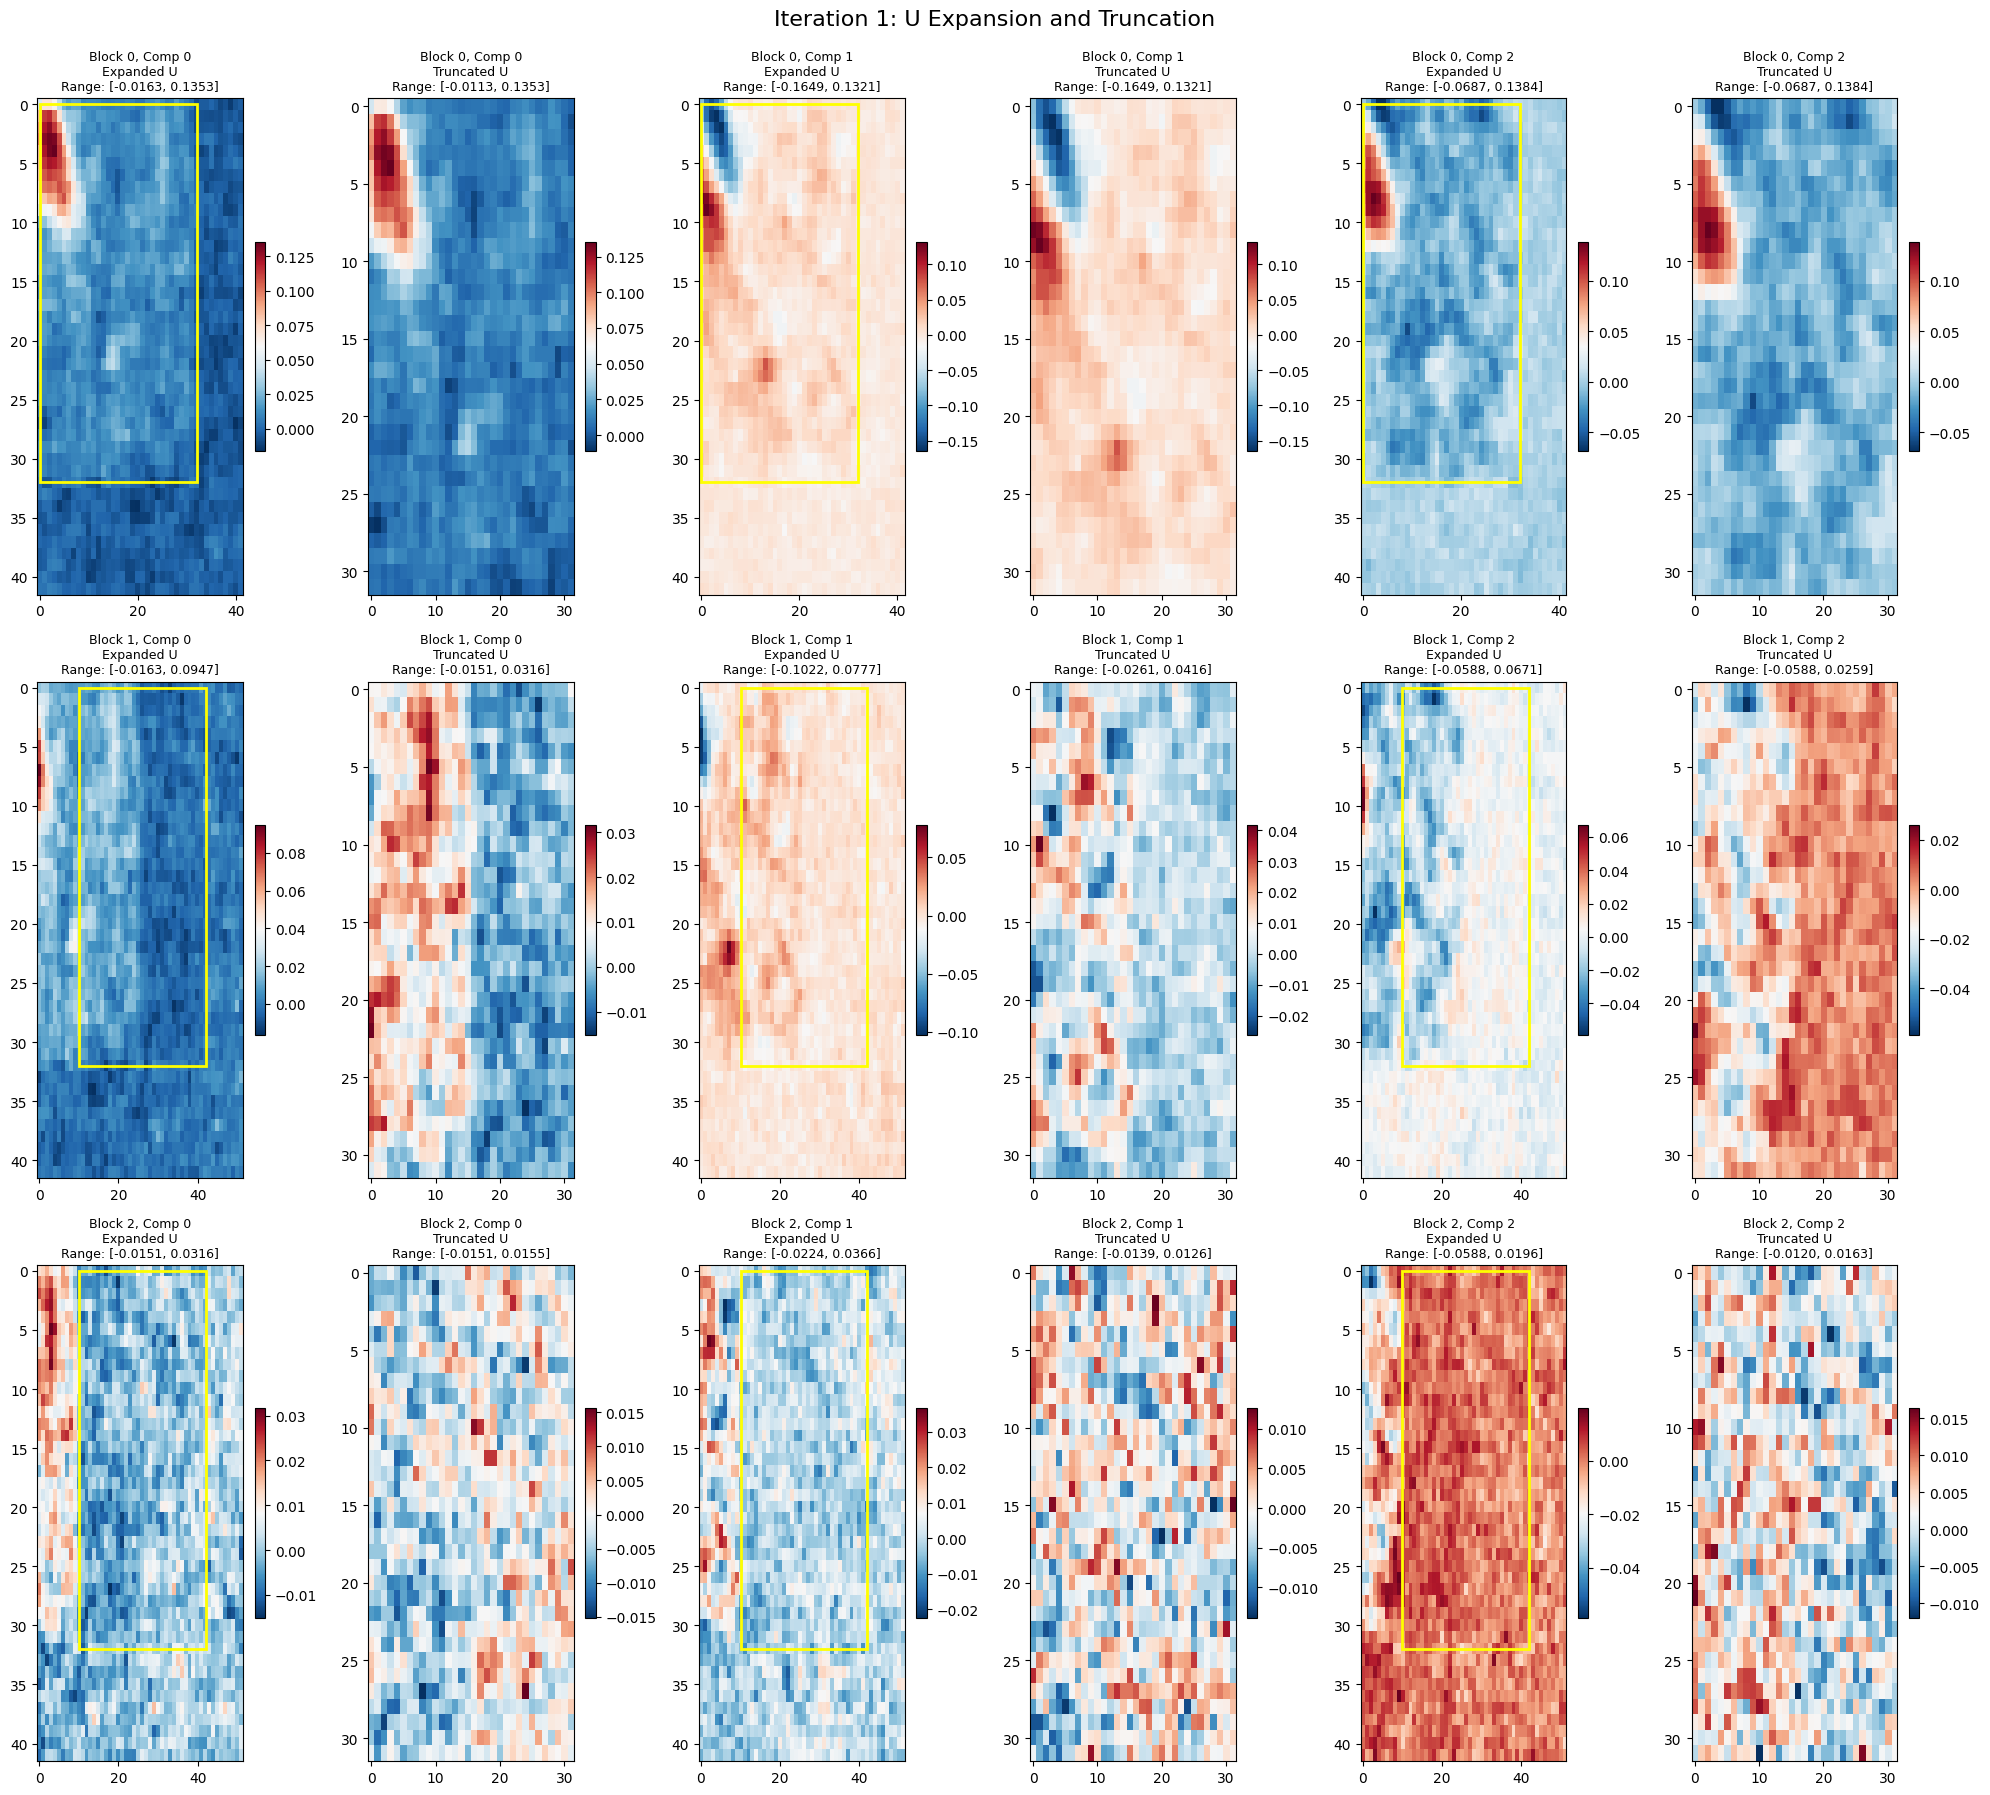

  Saved V top 10 visualization to /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/v_refinement_results_iter1_V_top10.png


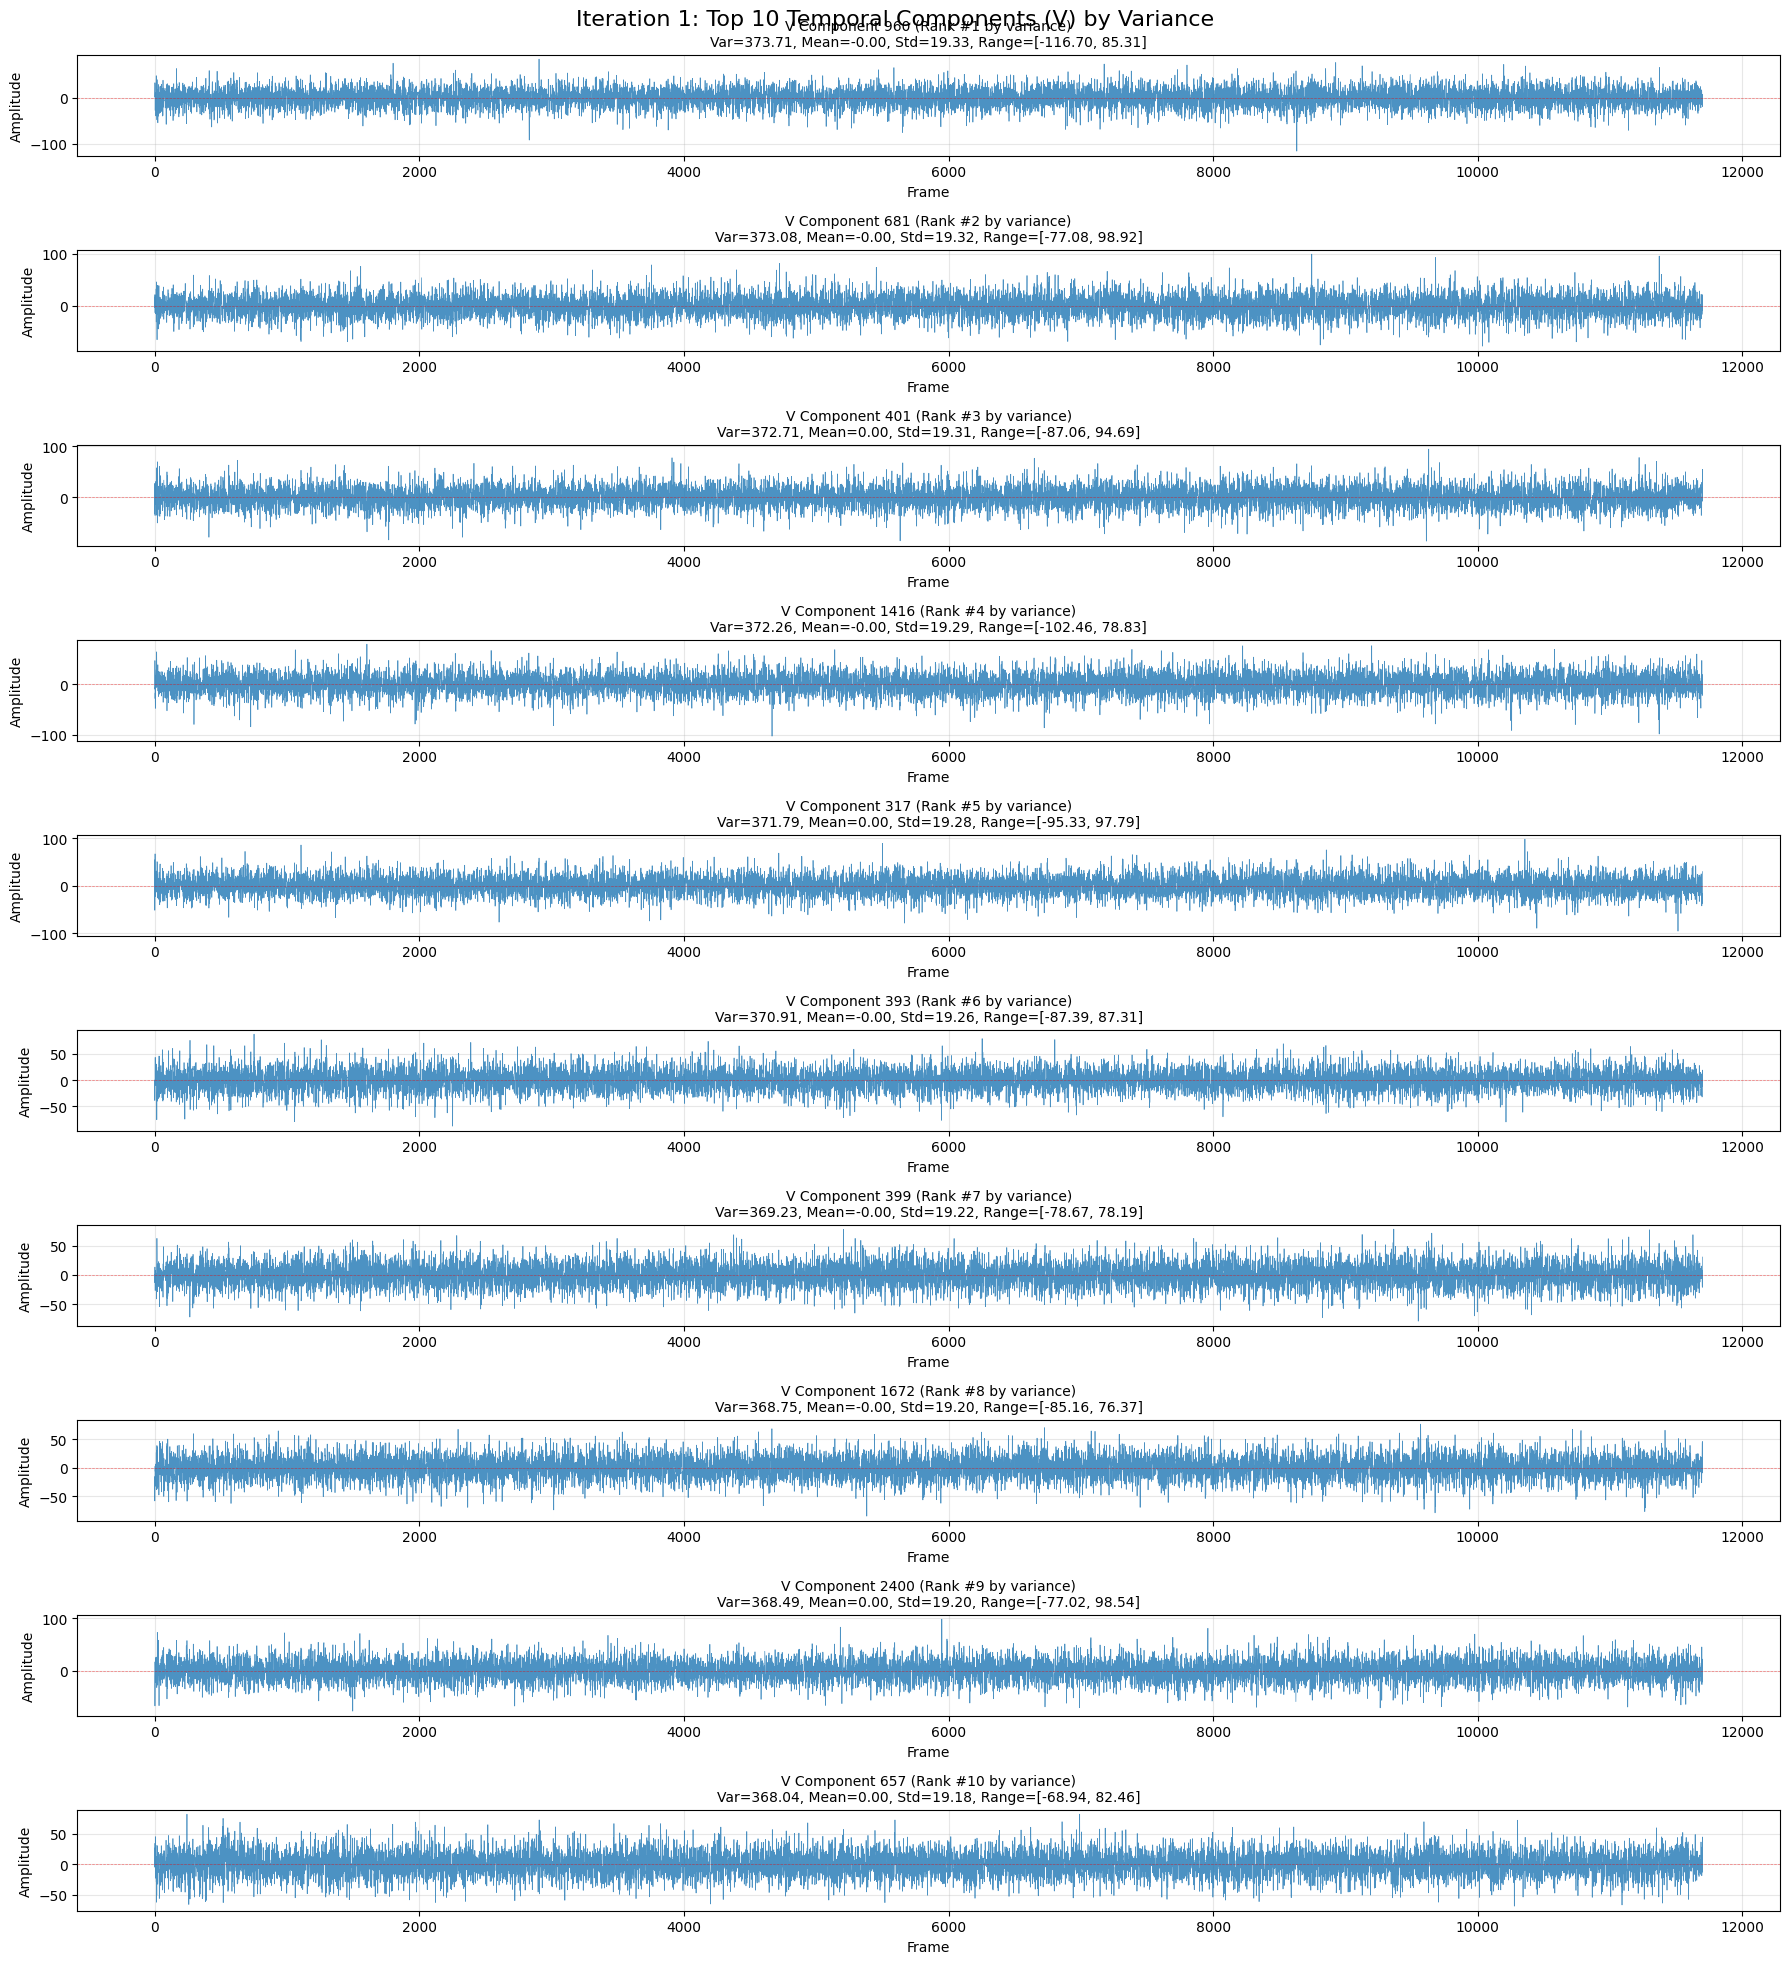

  Saved V analysis to /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/v_refinement_results_iter1_V_analysis.png


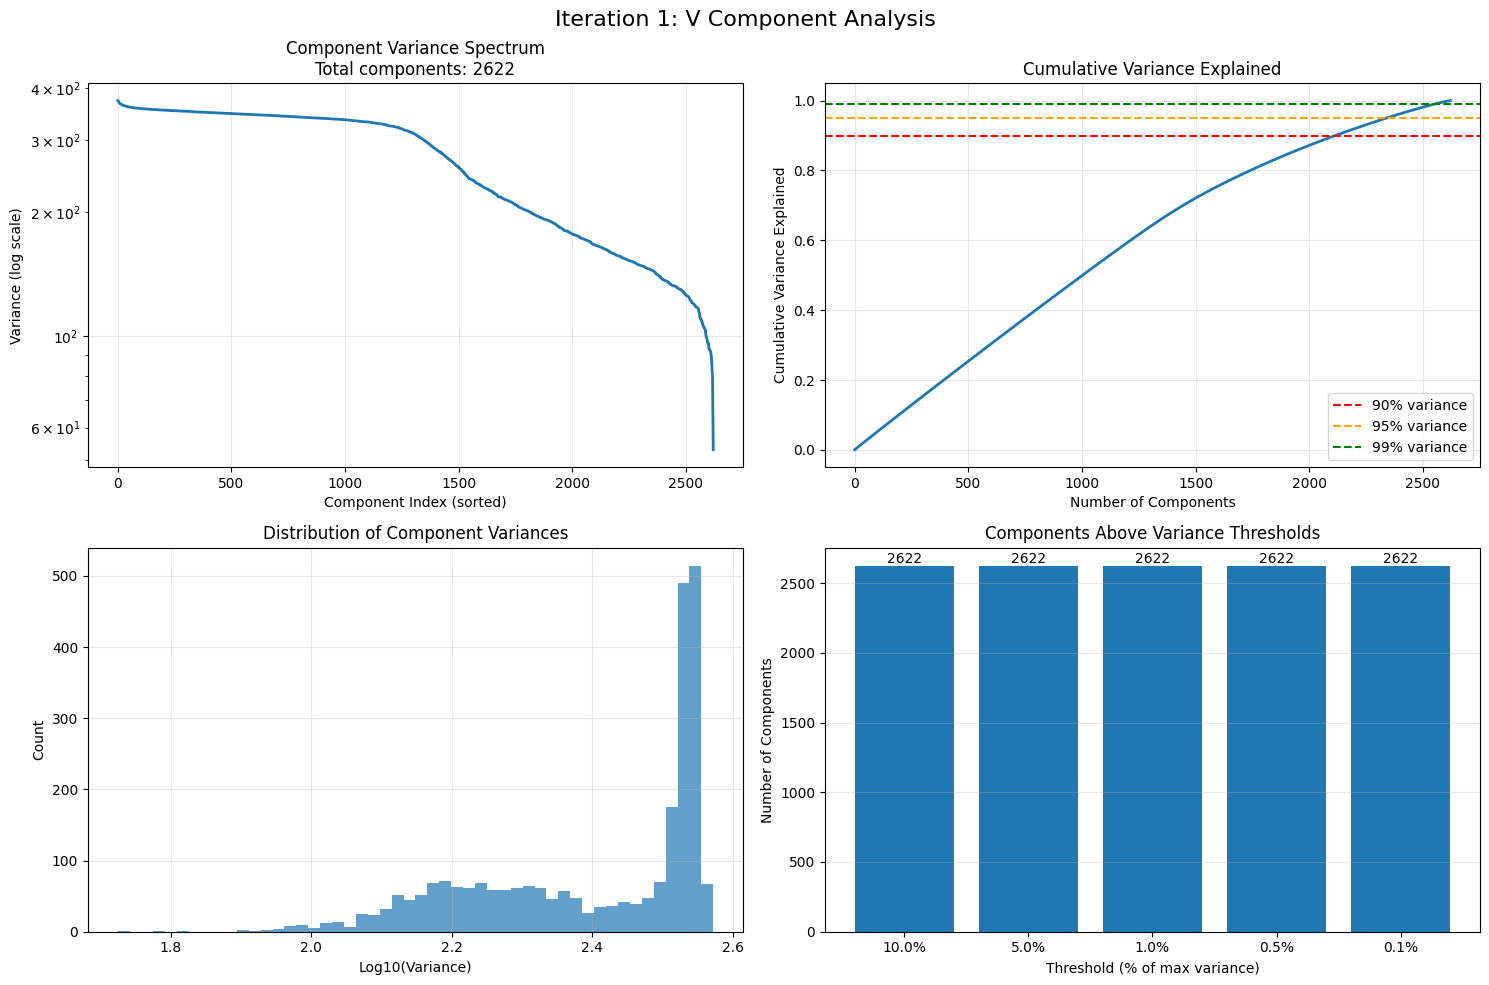

  Saved V samples to /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/v_refinement_results_iter1_V_samples.png


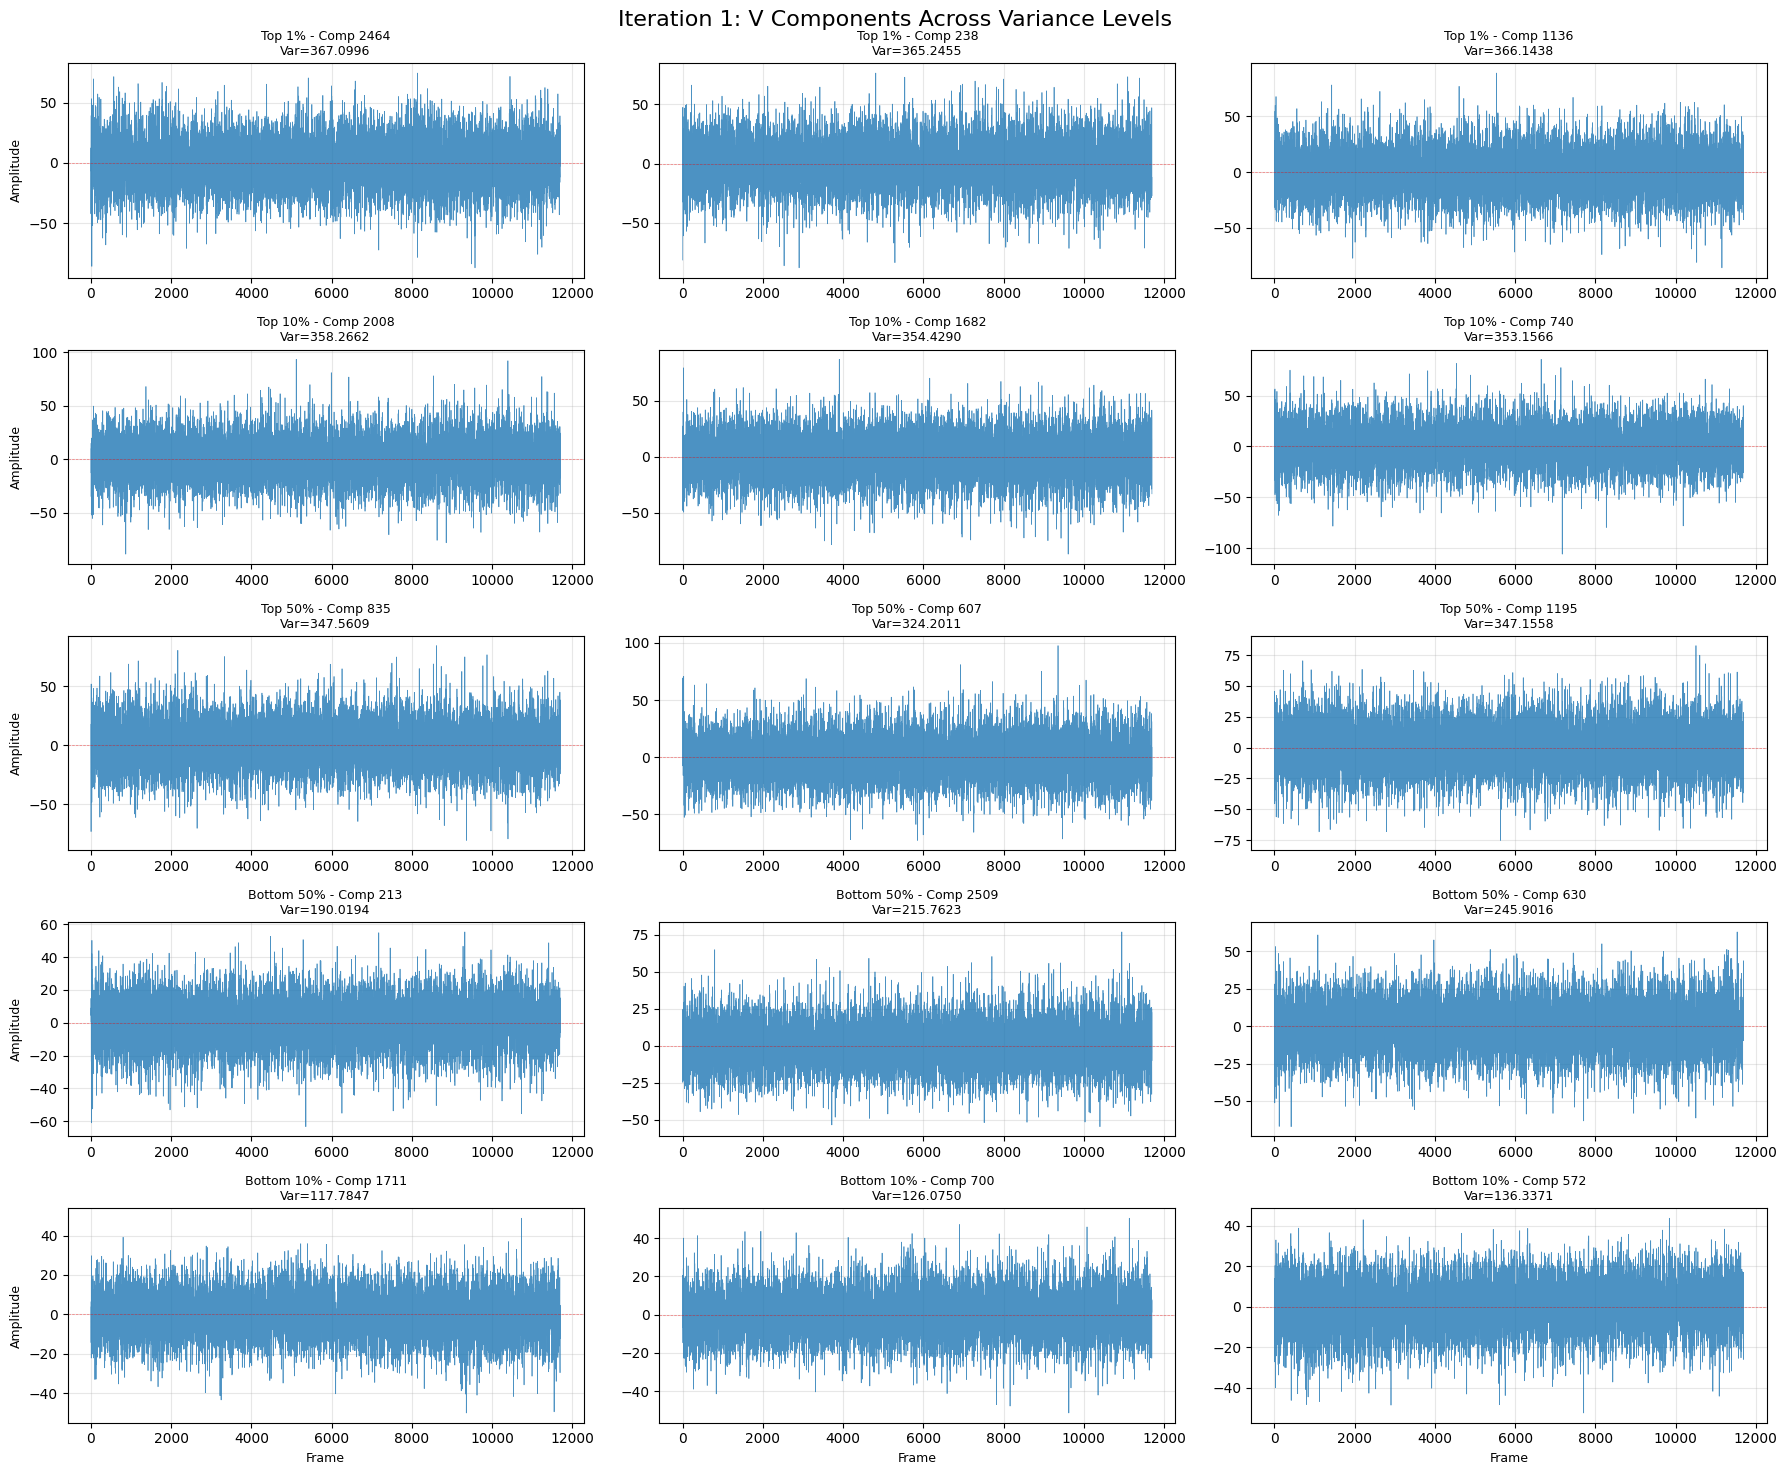

  Saved U statistics to /burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/v_refinement_results_iter1_U_stats.png


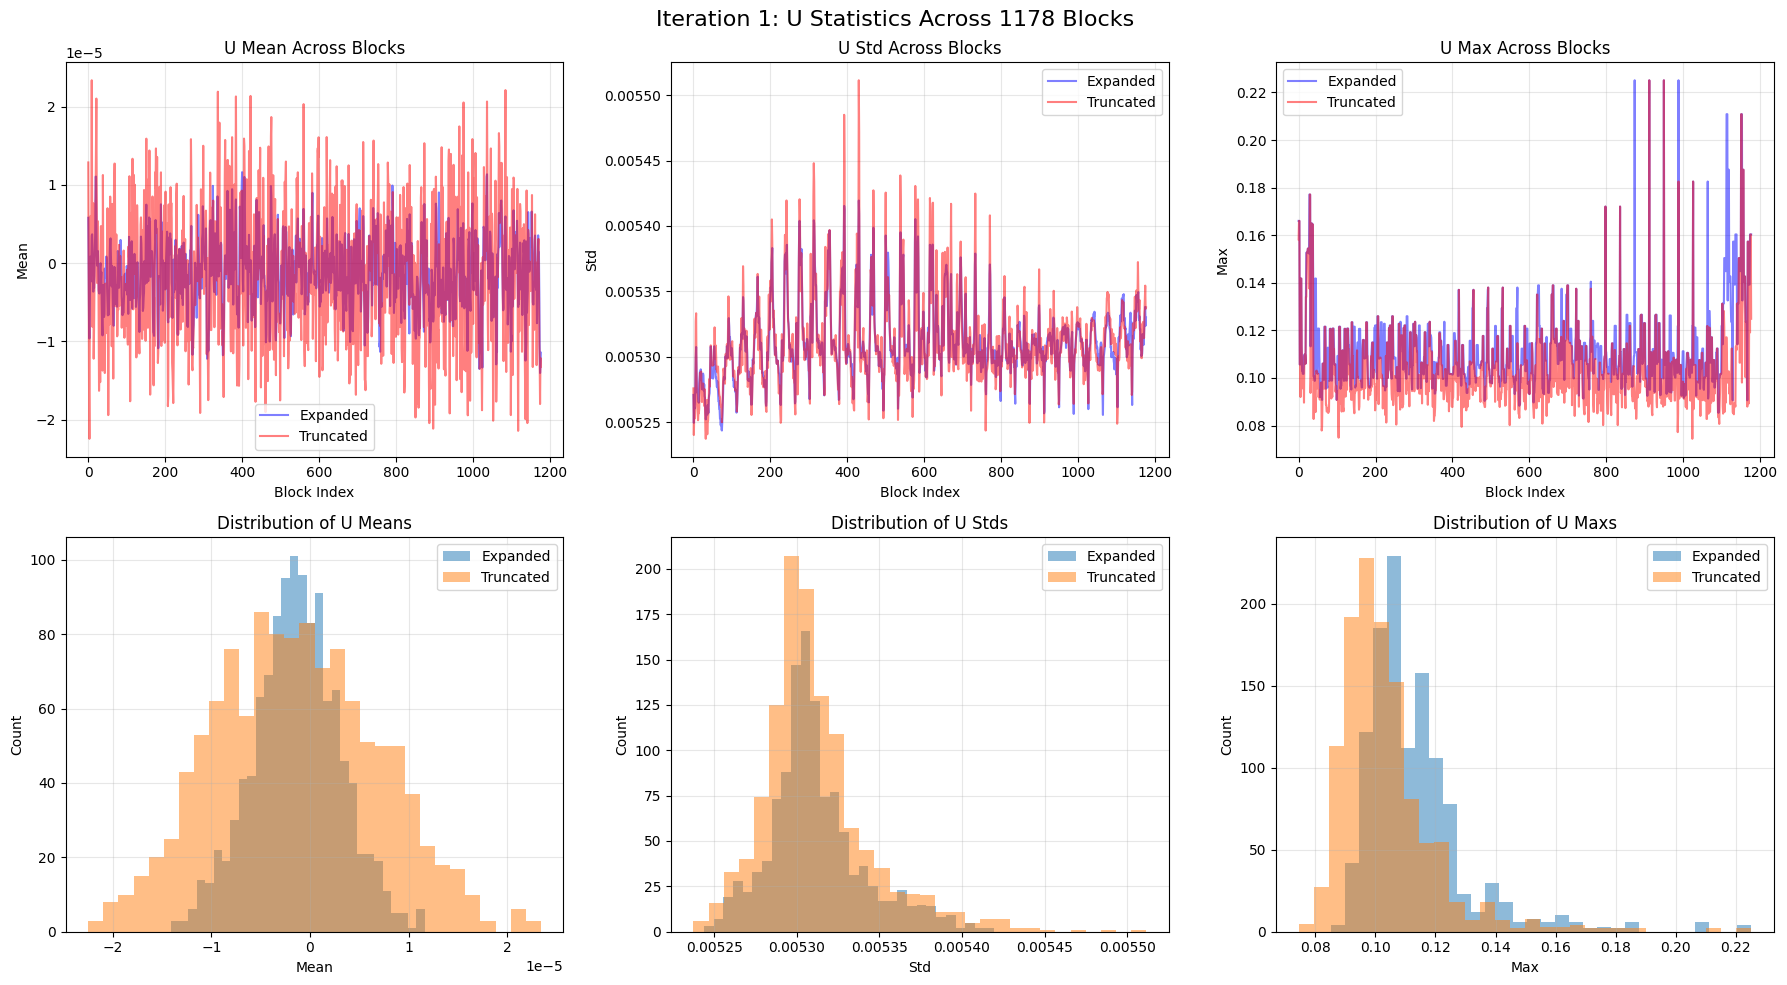


######################################################################
# V Refinement Complete!
######################################################################
Final V shape: torch.Size([2622, 11700])
Final V mean: -0.000000
Final V std: 16.318684
######################################################################

Original V shape: torch.Size([2622, 11700])
Refined V shape: torch.Size([2622, 11700])


In [14]:
    
# Now refine V using expanded block regression
v_refined = refine_v_from_pmd_array(
        pmd_arr=pmd_arr,
        dataset=my_data,
        block_sizes=(32, 32),
        overlap=(16, 16),
        expansion_factor=10,  # Expand blocks by 10 pixels in all directions
        spatial_denoiser=None,  # Add your denoiser if available
        num_iterations=1,
        frame_batch_size=1000,
        device="cuda" if torch.cuda.is_available() else "cpu",
        visualize=True,
        save_path="/burg-archive/home/lm3879/masknmf-toolbox/masknmf/compression/v_refinement_results"
    )
    
print(f"Original V shape: {pmd_arr.v.shape}")
print(f"Refined V shape: {v_refined.shape}")


In [18]:
import os
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
import masknmf
from typing import *
import fastplotlib as fpl
config = {
    'bin_file_path': '/burg-archive/home/lm3879/plane4/data.bin',
    'ops_file_path': '/burg-archive/home/lm3879/plane4/ops.npy',
    'out_path': '/burg-archive/home/lm3879/masknmf-toolbox/ibl_denoised_output/pmd_spatial_results.npz',
    'block_size': (32, 32),
    'max_components': 20,
    'device': 'cuda',
    'spatial_epochs': 15,
    'spatial_batch_size': 32,
    'spatial_lr': 1e-4,
    'temporal_epochs': 5,
    'temporal_batch_size': 128,
    'temporal_lr': 1e-4,
    'noise_quantile': 0.7,
    'patch_h': 40,
    'patch_w': 40,
}

cfg = OmegaConf.create(config)
print(f"Using device: {cfg.device}")

# Load data
my_data = MotionBinDataset(cfg.bin_file_path, cfg.ops_file_path)
print(f"Loaded data with shape (T,H,W): {my_data.shape}")
pmd_initial = masknmf.CompressStrategy(
    dataset=my_data,
    block_sizes=cfg.block_size,
    max_components=cfg.max_components,
    device=cfg.device
).compress()

Using device: cuda
Loaded data with shape (T,H,W): (11700, 500, 620)
[26-01-26 02:10:27]: Starting compression
[26-01-26 02:10:27]: sampled from the following regions: [0]
[26-01-26 02:10:27]: We are initializing on a total of 11700 frames
[26-01-26 02:12:08]: Loading data to estimate complete spatial basis
[26-01-26 02:12:08]: skipping the pruning step for frame cutoff
[26-01-26 02:12:09]: Finding spatiotemporal roughness thresholds


100%|██████████| 250/250 [00:05<00:00, 42.22it/s] 


[26-01-26 02:12:15]: Running Blockwise Decompositions
[26-01-26 02:12:55]: Constructed U matrix. Rank of U is 2573
[26-01-26 02:12:56]: PMD Objected constructed


In [31]:
import numpy as np
import torch
from tqdm import tqdm

def reconstruct_denoised_stack_from_v(
    dataset,                 # (T,H,W) 的 LazyFrameLoader / np / torch
    v_refined,               # (K,T)
    mean_img,                # (H,W)  pmd_arr.mean_img
    noise_img,               # (H,W)  pmd_arr.var_img（注意：确认它到底是 std 还是 variance）
    frame_batch_size=500,
    device="cuda",
    dtype=torch.float32,
    spatial_denoiser=None,   # 可选：对 U 做空间去噪的函数/模型，输入(H,W,K)输出(H,W,K)
    out_path=None,           # 可选：写到磁盘 .npy/.dat；否则直接返回 numpy (可能很大)
):
    T, H, W = dataset.shape
    v = v_refined.to(device=device, dtype=dtype)

    mean_t = mean_img.to(device=device, dtype=dtype)
    noise_t = noise_img.to(device=device, dtype=dtype)

    # 1) 回归整幅图的 U：形状 (H*W, K)
    u_flat = regress_expanded_block_for_u(
        dataset=dataset,
        v=v,
        start_h=0, end_h=H,
        start_w=0, end_w=W,
        dataset_mean=mean_t,
        dataset_noise_variance=noise_t,
        frame_batch_size=frame_batch_size,
        dtype=dtype,
        device=device,
    )

    # reshape -> (H,W,K)
    K = v.shape[0]
    u = u_flat.reshape(H, W, K)

    if spatial_denoiser is not None:
        u = spatial_denoiser(u)

    # 3) 分 batch 重建 movie：
    # 标准化空间下：Xhat_std = U_flat @ V
    # 还原到原空间：Xhat = Xhat_std * noise + mean
    mean_flat = mean_t.reshape(-1, 1)
    noise_flat = noise_t.reshape(-1, 1)
    u_flat2 = u.reshape(-1, K)

    if out_path is not None:
        # 用 memmap 写出 (T,H,W)
        out = np.memmap(out_path, dtype=np.float32, mode="w+", shape=(T, H, W))
    else:
        out = np.empty((T, H, W), dtype=np.float32)

    for s in tqdm(range(0, T, frame_batch_size), desc="Reconstruct denoised stack"):
        e = min(T, s + frame_batch_size)
        v_batch = v[:, s:e]                           # (K, b)
        xhat_std = (u_flat2 @ v_batch)                # (H*W, b)
        xhat = xhat_std * noise_flat + mean_flat      # (H*W, b)
        xhat = xhat.reshape(H, W, e - s).permute(2, 0, 1).detach().cpu().numpy()
        out[s:e] = xhat

    if isinstance(out, np.memmap):
        out.flush()
        return None, u.detach().cpu(), v_refined  # movie 写盘了
    else:
        return out, u.detach().cpu(), v_refined

denoised_stack, u_full, v_final = reconstruct_denoised_stack_from_v(
    dataset=my_data,
    v_refined=v_refined,
    mean_img=pmd_arr.mean_img,
    noise_img=pmd_arr.var_img,
    frame_batch_size=500,
    device="cuda" if torch.cuda.is_available() else "cpu",
    spatial_denoiser=None,
    out_path=None, 
)

print("done.")
if denoised_stack is not None:
    print("denoised_stack:", denoised_stack.shape)
print("u_full:", u_full.shape, "v_final:", v_final.shape)


Reconstruct denoised stack: 100%|██████████| 24/24 [00:49<00:00,  2.04s/it]


done.
denoised_stack: (11700, 500, 620)
u_full: torch.Size([500, 620, 2622]) v_final: torch.Size([2622, 11700])


RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
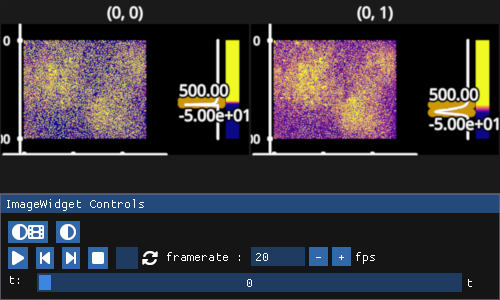

In [33]:
iw = fpl.ImageWidget(
    data=[
        my_data[:,:,:],denoised_stack
    ]
)

for g in iw.managed_graphics:
    g.vmin = -50
    g.vmax = +500

iw.show()

In [ ]:
##################################

In [40]:
import math
import numpy as np
import torch
from tqdm import tqdm
from typing import Optional, Tuple, List, Union, Dict

# ========= 1) 更稳的 V 回归：带 ridge，并且支持 temporal_denoiser =========
@torch.no_grad()
def regress_for_v_from_blocks_ridge(
    dataset: Union[np.ndarray, torch.Tensor],
    u_blocks: list,                # list of (block_h, block_w, K) torch tensors, CORE blocks only
    block_locations: list,         # list of (start_h, start_w, block_h, block_w)
    dataset_mean: torch.Tensor,    # (H,W)
    dataset_noise_std: torch.Tensor,  # (H,W)  注意：std
    frame_batch_size: int,
    dtype: torch.dtype,
    device: str,
    ridge_v: float = 1e-3,         # 关键：稳定性
    temporal_denoiser: Optional[torch.nn.Module] = None,
) -> torch.Tensor:
    """
    固定 U_core，回归 V： V = argmin ||X - U V||^2 + ridge_v ||V||^2
    在 whitened 空间下相当于：
      令 Xw = (X-mean)/std, Uw = U/std
      V = (Uw^T Uw + ridge_v I)^(-1) Uw^T Xw
    """
    num_frames, H, W = dataset.shape
    K = u_blocks[0].shape[2]

    dataset_mean = dataset_mean.to(device=device, dtype=dtype)
    dataset_noise_std = dataset_noise_std.to(device=device, dtype=dtype)

    # --- 先把所有 core block 融合成一个全 FOV 的 U_sum/weight（和你原 regress_for_v_from_blocks 类似）
    weight_sum = torch.zeros((H, W), device=device, dtype=dtype)
    u_sum = torch.zeros((H, W, K), device=device, dtype=dtype)

    for u_blk, (sh, sw, bh, bw) in zip(u_blocks, block_locations):
        u_blk = u_blk.to(device=device, dtype=dtype)
        u_sum[sh:sh+bh, sw:sw+bw, :] += u_blk
        weight_sum[sh:sh+bh, sw:sw+bw] += 1.0

    u_full = u_sum / weight_sum[:, :, None].clamp_min(1e-6)   # (H,W,K)

    # whiten 权重：Uw = U/std
    std_full = dataset_noise_std.clamp_min(1e-8)
    Uw = (u_full / std_full[:, :, None]).reshape(H*W, K)      # (P,K)
    mean_flat = dataset_mean.reshape(H*W, 1)                  # (P,1)
    std_flat  = std_full.reshape(H*W, 1)                      # (P,1)

    # 预计算 A = (Uw^T Uw + ridge I)^(-1) Uw^T   —— 但 P 很大，直接算 Uw^T Uw 还可以
    gram = Uw.T @ Uw
    gram = gram + ridge_v * torch.eye(K, device=device, dtype=dtype)
    gram_inv = torch.linalg.pinv(gram)

    # 预计算 Uw^T * (-mean/std)
    mean_w = (mean_flat / std_flat)
    mean_proj = Uw.T @ mean_w   # (K,1)

    v_list = []
    num_iters = math.ceil(num_frames / frame_batch_size)

    for bi in tqdm(range(num_iters), desc="Regress V (ridge)"):
        s = bi * frame_batch_size
        e = min(num_frames, s + frame_batch_size)

        x = dataset[s:e]  # (b,H,W)
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(x)
        x = x.to(device=device, dtype=dtype)
        x = x.permute(1, 2, 0).reshape(H*W, -1)          # (P,b)
        xw = (x - mean_flat) / std_flat                  # (P,b)

        rhs = Uw.T @ xw                                   # (K,b)
        rhs = rhs                                         # already mean-subtracted via xw
        v_b = gram_inv @ rhs                              # (K,b)

        v_list.append(v_b)

    V = torch.cat(v_list, dim=1)  # (K,T)

    if temporal_denoiser is not None:
        temporal_denoiser = temporal_denoiser.to(device)
        V = temporal_denoiser(V)

    return V


# ========= 2) Extended-U 闭环迭代：导师那 5 步 =========
@torch.no_grad()
def extended_u_pmd_iterate(
    dataset: Union[np.ndarray, torch.Tensor],
    v_init: torch.Tensor,                # (K,T) 初始 V（来自 PMD/PCA）
    block_locations: list,               # [(start_h, start_w, block_h, block_w), ...]
    expansion: int,                      # halo 像素
    dataset_mean: torch.Tensor,          # (H,W)
    dataset_noise_std: torch.Tensor,     # (H,W)  std
    spatial_denoiser: Optional[torch.nn.Module] = None,
    temporal_denoiser: Optional[torch.nn.Module] = None,
    num_iterations: int = 3,
    frame_batch_size: int = 1000,
    ridge_u: float = 1e-2,               # U 回归 ridge（建议别为 0）
    ridge_v: float = 1e-3,               # V 回归 ridge
    dtype: torch.dtype = torch.float32,
    device: str = "cuda",
    verbose: bool = True,
) -> Tuple[torch.Tensor, List[torch.Tensor]]:
    """
    返回：
      V_refined: (K,T)
      U_blocks_core: list of CORE U blocks, each (block_h, block_w, K)
    """
    T, H, W = dataset.shape
    V = v_init.to(device=device, dtype=dtype).clone()

    dataset_mean = dataset_mean.to(device=device, dtype=dtype)
    dataset_noise_std = dataset_noise_std.to(device=device, dtype=dtype)

    if spatial_denoiser is not None:
        spatial_denoiser = spatial_denoiser.to(device)
    if temporal_denoiser is not None:
        temporal_denoiser = temporal_denoiser.to(device)

    # --- 初始化：先用 core block 回归一次 U_core（不扩展也行，但这里直接用扩展->截回更一致）
    U_core_blocks = None

    for it in range(num_iterations):
        if verbose:
            print(f"\n========== Extended-U Iter {it+1}/{num_iterations} ==========")

        # (A) Compute V：用上一轮的 U_core 回归 V
        #     第 1 轮如果还没有 U_core，就先跳过，用 v_init；否则用 U_core 更新
        if U_core_blocks is not None:
            V = regress_for_v_from_blocks_ridge(
                dataset=dataset,
                u_blocks=U_core_blocks,
                block_locations=block_locations,
                dataset_mean=dataset_mean,
                dataset_noise_std=dataset_noise_std,
                frame_batch_size=frame_batch_size,
                dtype=dtype,
                device=device,
                ridge_v=ridge_v,
                temporal_denoiser=temporal_denoiser,
            )
        else:
            if temporal_denoiser is not None:
                V = temporal_denoiser(V)

        # (B) Regress U on expanded blocks -> denoise -> truncate
        U_core_blocks_new = []
        for (sh, sw, bh, bw) in tqdm(block_locations, desc="Update U (expand->denoise->crop)"):
            # expanded bounds
            eh = min(H, sh + bh)
            ew = min(W, sw + bw)
            ex_sh = max(0, sh - expansion)
            ex_sw = max(0, sw - expansion)
            ex_eh = min(H, eh + expansion)
            ex_ew = min(W, ew + expansion)

            ex_h = ex_eh - ex_sh
            ex_w = ex_ew - ex_sw
            K = V.shape[0]

            # --- 回归 U_ext：用你已有的 regress_expanded_block_for_u
            U_ext_flat = regress_expanded_block_for_u(
                dataset=dataset,
                v=V,
                start_h=ex_sh, end_h=ex_eh,
                start_w=ex_sw, end_w=ex_ew,
                dataset_mean=dataset_mean,
                dataset_noise_variance=dataset_noise_std,  # 这里你的函数名叫 variance，但你说实际是 std：保持一致传入
                frame_batch_size=frame_batch_size,
                dtype=dtype,
                device=device,
            )  # (ex_h*ex_w, K)

            # --- 给 U 回归加 ridge：U = U_raw @ inv(VV^T + ridge_u I)
            #     你的 regress_expanded_block_for_u 里用的是 pinv(VV^T)，这里再做一次 ridge 更稳
            VVt = V @ V.T
            VVt = VVt + ridge_u * torch.eye(K, device=device, dtype=dtype)
            VVt_inv = torch.linalg.pinv(VVt)
            U_ext_flat = U_ext_flat @ (VVt @ VVt_inv)  # 数值上相当于“稳一点”的投影（可留可去）
            # 更直接也可以：U_ext_flat = U_ext_flat @ VVt_inv  （但你的函数内部已乘过 pinv，所以这里保守不再重写）

            # reshape (ex_h, ex_w, K)
            U_ext = U_ext_flat.reshape(ex_h, ex_w, K)

            # --- 空间去噪（expanded U images）
            if spatial_denoiser is not None:
                U_ext = spatial_denoiser(U_ext)

            # --- truncate back to core
            rel_sh = sh - ex_sh
            rel_sw = sw - ex_sw
            U_core = U_ext[rel_sh:rel_sh+bh, rel_sw:rel_sw+bw, :]  # (bh,bw,K)

            U_core_blocks_new.append(U_core)

        U_core_blocks = U_core_blocks_new

    return V, U_core_blocks


# ========= 3) 用 (U_blocks_core, V) overlap-add 重建 denoised stack =========
@torch.no_grad()
def reconstruct_from_blocks(
    V: torch.Tensor,                 # (K,T)
    U_core_blocks: list,             # list of (bh,bw,K)
    block_locations: list,
    out_shape: Tuple[int,int,int],   # (T,H,W)
    device: str = "cuda",
    dtype: torch.dtype = torch.float32,
    out_path: Optional[str] = None,
    frame_batch_size: int = 500,
    dataset_mean: Optional[torch.Tensor] = None,        # (H,W) 用于 unwhiten（可选）
    dataset_noise_std: Optional[torch.Tensor] = None,   # (H,W) 用于 unwhiten（可选）
):
    """
    直接用 U,V 生成 X_hat（whitened 或 unwhitened）。
    如果给了 mean/std，就输出到原始尺度：X = Xw*std + mean。
    """
    T, H, W = out_shape
    V = V.to(device=device, dtype=dtype)

    # 输出缓冲
    if out_path is not None:
        out = np.memmap(out_path, dtype=np.float32, mode="w+", shape=(T, H, W))
    else:
        out = np.zeros((T, H, W), dtype=np.float32)

    # overlap 权重 & 累加器（只需要一次性构造）
    weight = torch.zeros((H, W), device=device, dtype=dtype)
    # 先构造一个平滑 window，减少 block 边界拼接痕迹（可选但强烈建议）
    def cosine_window(h, w, eps=1e-6):
        yy = torch.linspace(0, math.pi, h, device=device, dtype=dtype)
        xx = torch.linspace(0, math.pi, w, device=device, dtype=dtype)
        wy = torch.sin(yy).clamp_min(eps)
        wx = torch.sin(xx).clamp_min(eps)
        return (wy[:, None] * wx[None, :])

    # 预存每个 block 的 window（避免重复算）
    windows = []
    for (sh, sw, bh, bw) in block_locations:
        windows.append(cosine_window(bh, bw))

    # 预先累加 weight
    for win, (sh, sw, bh, bw) in zip(windows, block_locations):
        weight[sh:sh+bh, sw:sw+bw] += win
    weight = weight.clamp_min(1e-6)

    if dataset_mean is not None and dataset_noise_std is not None:
        mean = dataset_mean.to(device=device, dtype=dtype)
        std  = dataset_noise_std.to(device=device, dtype=dtype).clamp_min(1e-8)
    else:
        mean = None
        std = None

    num_iters = math.ceil(T / frame_batch_size)

    for bi in tqdm(range(num_iters), desc="Reconstruct (overlap-add)"):
        s = bi * frame_batch_size
        e = min(T, s + frame_batch_size)
        b = e - s

        # accumulator for this batch
        acc = torch.zeros((b, H, W), device=device, dtype=dtype)

        Vb = V[:, s:e]  # (K,b)

        # 每个 block 做 U_block @ Vb，乘 window，累加到 acc
        for U_blk, win, (sh, sw, bh, bw) in zip(U_core_blocks, windows, block_locations):
            U_blk = U_blk.to(device=device, dtype=dtype)  # (bh,bw,K)
            # (bh*bw,K) @ (K,b) -> (bh*bw,b) -> (b,bh,bw)
            Xb_blk = (U_blk.reshape(-1, V.shape[0]) @ Vb).T.reshape(b, bh, bw)
            Xb_blk = Xb_blk * win[None, :, :]
            acc[:, sh:sh+bh, sw:sw+bw] += Xb_blk

        # normalize overlap
        acc = acc / weight[None, :, :]

        # unwhiten if requested
        if mean is not None and std is not None:
            acc = acc * std[None, :, :] + mean[None, :, :]

        acc_np = acc.detach().cpu().numpy().astype(np.float32)
        out[s:e] = acc_np

    if isinstance(out, np.memmap):
        out.flush()
        return None
    return out


# ========= 4) 一键跑：extended-U 迭代 + 重建 denoised stack =========
def extended_u_denoise_stack(
    dataset,
    v_init,
    block_locations,
    expansion,
    mean_img,
    noise_std_img,
    spatial_denoiser=None,
    temporal_denoiser=None,
    num_iterations=3,
    frame_batch_size=1000,
    ridge_u=1e-2,
    ridge_v=1e-3,
    device="cuda",
    dtype=torch.float32,
    out_path=None,
    recon_batch_size=500,
):
    V_ref, U_core_blocks = extended_u_pmd_iterate(
        dataset=dataset,
        v_init=v_init,
        block_locations=block_locations,
        expansion=expansion,
        dataset_mean=mean_img,
        dataset_noise_std=noise_std_img,
        spatial_denoiser=spatial_denoiser,
        temporal_denoiser=temporal_denoiser,
        num_iterations=num_iterations,
        frame_batch_size=frame_batch_size,
        ridge_u=ridge_u,
        ridge_v=ridge_v,
        dtype=dtype,
        device=device,
        verbose=True,
    )

    denoised = reconstruct_from_blocks(
        V=V_ref,
        U_core_blocks=U_core_blocks,
        block_locations=block_locations,
        out_shape=dataset.shape,
        device=device,
        dtype=dtype,
        out_path=out_path,
        frame_batch_size=recon_batch_size,
        dataset_mean=mean_img,
        dataset_noise_std=noise_std_img,
    )
    return V_ref, U_core_blocks, denoised


In [49]:
V_ref, U_blocks, denoised_stack = extended_u_denoise_stack(
    dataset=my_data,
    v_init=pmd_arr.v,
    block_locations=block_locations,
    expansion=10,
    mean_img=pmd_arr.mean_img,
    noise_std_img=pmd_arr.var_img,
    spatial_denoiser=None,      # 可选
    temporal_denoiser=None,    # 可选
    num_iterations=3,
    frame_batch_size=1000,
    ridge_u=1e-2,
    ridge_v=1e-3,
    device="cuda",
    out_path=None,                          # 大数据建议给路径 memmap
)



========== Extended-U Iter 1/3 ==========


Update U (expand->denoise->crop):  25%|██▌       | 299/1178 [14:36<42:56,  2.93s/it] 


KeyboardInterrupt: 

In [46]:
def build_block_locations(
    fov_shape,
    block_sizes,
    overlap,
):
    """
    Parameters
    ----------
    fov_shape : tuple
        (H, W)
    block_sizes : tuple
        (block_h, block_w)
    overlap : tuple
        (overlap_h, overlap_w)

    Returns
    -------
    block_locations : list of tuples
        Each element is (start_h, start_w, block_h, block_w)
    """
    fov_dim1, fov_dim2 = fov_shape
    block_h, block_w = block_sizes
    overlap_h, overlap_w = overlap

    print("Building block locations...")

    block_locations = []

    # dimension 1 (height)
    dim_1_iters = list(
        range(0, fov_dim1 - block_h + 1, block_h - overlap_h)
    )
    if (
        dim_1_iters
        and dim_1_iters[-1] != fov_dim1 - block_h
        and fov_dim1 - block_h != 0
    ):
        dim_1_iters.append(fov_dim1 - block_h)

    # dimension 2 (width)
    dim_2_iters = list(
        range(0, fov_dim2 - block_w + 1, block_w - overlap_w)
    )
    if (
        dim_2_iters
        and dim_2_iters[-1] != fov_dim2 - block_w
        and fov_dim2 - block_w != 0
    ):
        dim_2_iters.append(fov_dim2 - block_w)

    for i in dim_1_iters:
        for j in dim_2_iters:
            block_locations.append((i, j, block_h, block_w))

    print(f"Created {len(block_locations)} blocks")
    return block_locations

T, H, W = my_data.shape

block_locations = build_block_locations(
    fov_shape=(H, W),
    block_sizes=(32,32),    # e.g. (64, 64)
    overlap=(16,16),            # e.g. (16, 16)
)


Building block locations...
Created 1178 blocks
